# Fake detector variations while waiting for detvar production

**_must run with dfs created with the 2-PFP cut_**

Fake detvar effects on PID by

- cuttig on PID score from different planes, comparing the resulting distribution

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm

# local imports
sys.path.append('../../')
from variable_configs import VariableConfig
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from makedf.constants import *

plt.style.use("presentation.mplstyle")
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

# suppress performance warnings
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
def match_trkdf_to_slcdf(trkdf, slcdf):
    # trkdf: df to match
    # slcdf: df to match to
    matched_trkdf = trkdf.reset_index(level=[3]).loc[slcdf.index].reset_index().set_index(trkdf.index.names)
    return matched_trkdf


In [3]:
def mag3d(df1, df2):
    return np.sqrt((df1.x - df2.x)**2 + (df1.y - df2.y)**2 + (df1.z - df2.z)**2)

In [4]:
save_fig = False
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/2prong_variables"

# Load dfs

In [5]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/NuINT2025"
## -- MC 
mc_file = path.join(file_dir, "MC_bnb_cosmics_2prong_haddedfiles.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

## -- Data
data_file = path.join(file_dir, "Data_dev_2prong.df")
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

## -- Intime Data
intime_file = "/exp/sbnd/data/users/munjung/xsec/2025B/Data_intime-2prong.df"
intime_split_df = pd.read_hdf(intime_file, key="split")
intime_n_split = get_n_split(intime_file)
print("intime_n_split: %d" %(intime_n_split))
print_keys(intime_file)

mc_n_split: 2
Keys: ['/evt_0', '/evt_1', '/hdr_0', '/hdr_1', '/split']
data_n_split: 1
Keys: ['/bnbpot_0', '/evt_0', '/hdr_0', '/split']
intime_n_split: 1
Keys: ['/bnbpot_0', '/evt_0', '/hdr_0', '/split']


In [6]:
# concat dfs 
n_max_concat = 10

mc_keys2load = ['hdr', 'evt'] 
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']

data_keys2load = ['evt', 'hdr']
data_dfs = load_dfs(data_file, data_keys2load, n_max_concat=n_max_concat)
data_evt_df = data_dfs['evt']
data_hdr_df = data_dfs['hdr']

intime_keys2load = ['hdr', 'evt']
intime_dfs = load_dfs(intime_file, intime_keys2load, n_max_concat=n_max_concat)
intime_hdr_df = intime_dfs['hdr']
intime_evt_df = intime_dfs['evt']

In [7]:
## total pot - scale to data POT

# BNB data
data_tot_pot = data_hdr_df['pot'].sum()
print("data_tot_pot: %.3e" %(data_tot_pot))
pot_str = "7.37 $\\times 10^{18}$"
data_evt_df["pot_weight"] = np.ones(len(data_evt_df))
data_gates = data_hdr_df.nbnbinfo.sum()
print("data tot gates : %.3e" %(data_gates))

# BNB MC
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))
mc_pot_scale = data_tot_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

# Intime Data
# intime_gates = intime_hdr.noffbeambnb.sum()
intime_gates = intime_hdr_df[intime_hdr_df['first_in_subrun'] == 1]['noffbeambnb'].sum()
print("intime cosmics data gates: {:.2e}".format(intime_gates))
f = 0.073
scale_intime_to_lightdata = (1-f)*data_gates/intime_gates
print("goal scale: {:.2f}".format(scale_intime_to_lightdata))
intime_evt_df["gates_weight"] = scale_intime_to_lightdata * np.ones(len(intime_evt_df))

data_tot_pot: 7.370e+18
data tot gates : 1.561e+06
mc_tot_pot: 5.856e+20
mc_pot_scale: 1.259e-02
intime cosmics data gates: 1.36e+08
goal scale: 0.01


# Plotter

In [8]:
nu_cosmics_labels = ["Cosmic", r"Out-FV $\nu$", r"FV $\nu$"]
# nu_cosmics_colors = ["#ED5564", "#FFCE54", "#A0D568"]
nu_cosmics_colors = ["gray", "C0", "C1"]

topology_labels = ["Cosmic", r"Out-FV $\nu$", r"FV other $\nu$", r"FV $\nu_{\mu}$ NC",  
                  r"FV $\nu_{\mu}$ CC Other", r"FV $\nu_{\mu}$ CC Np0$\pi$", r"FV $\nu_{\mu}$ CC 1p0$\pi$"]
topology_colors = ["gray", "sienna", "crimson", "darkgreen", 
                  "coral", "darkslateblue", "mediumslateblue"]

genie_labels = ["Cosmic", r"Out-FV $\nu$", r"FV $\nu$ Other", r"FV $\nu_{\mu}$ NC",
                r"FV $\nu_{\mu}$ CC Other", r"FV $\nu_{\mu}$ CC DIS",
                r"FV $\nu_{\mu}$ CC RES", r"FV $\nu_{\mu}$ CC MEC",
                r"FV $\nu_{\mu}$ CC QE"]
genie_colors = ["gray", "sienna", "crimson", "darkgreen",
                "#BFB17C", "#D88A3B", "#2c7c94",
                "#390C1E", "#9b5580"]

In [9]:
def hist_plot(type,
              evtdf, vardf, 
              vardf_data, var_intime,
              bins,
              plot_labels=["", "", ""],
              ratio = True,
              vline = None,
              save_fig=False, save_name=None): 

    assert len(evtdf) == len(vardf)

    tot_mc_count = len(evtdf)
    tot_data_count = len(vardf_data)

    if type == "nu_cosmics":
        labels = nu_cosmics_labels
        colors = nu_cosmics_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv = IsNuInFV(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv]

    elif type == "topology":
        labels = topology_labels
        colors = topology_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        cut_nu_infv_numu_cc_other = IsNuInFV_NumuCC_Other(evtdf)
        cut_nu_infv_numu_cc_np0pi = IsNuInFV_NumuCC_Np0pi(evtdf)
        cut_nu_infv_numu_cc_1p0pi = IsNuInFV_NumuCC_1p0pi(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_cc_other, cut_nu_infv_numu_cc_np0pi, cut_nu_infv_numu_cc_1p0pi]

    elif type == "genie":
        labels = genie_labels
        colors = genie_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        print("numu NC", cut_nu_infv_numu_nc.sum())
        # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
        cut_nu_infv_numu_othermode = IsNuInFV_NumuCC_OtherMode(evtdf)
        cut_nu_infv_numu_cc_dis = IsNuInFV_NumuCC_DIS(evtdf)
        cut_nu_infv_numu_cc_res = IsNuInFV_NumuCC_RES(evtdf)
        cut_nu_infv_numu_cc_me = IsNuInFV_NumuCC_MEC(evtdf)
        cut_nu_infv_numu_cc_qe = IsNuInFV_NumuCC_QE(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_othermode, cut_nu_infv_numu_cc_dis, cut_nu_infv_numu_cc_res, 
                cut_nu_infv_numu_cc_me, cut_nu_infv_numu_cc_qe]
        

    else:
        raise ValueError("Invalid type: %s, please choose between [nu_cosmics, topolgy, or genie]" % type)

    # --- Plot template
    if ratio:
        fig, axs = plt.subplots(2, 1, figsize=(8.5, 8), 
                               sharex=True, gridspec_kw={'height_ratios': [4, 1]})
        fig.subplots_adjust(hspace=0.05)
        ax = axs[0]
        ax_r = axs[1]
    else:
        fig, ax = plt.subplots()

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- Data
    total_data, bins = np.histogram(vardf_data, bins=bins)
    data_err = np.sqrt(total_data)
    ax.errorbar(bin_centers, total_data, yerr=data_err, 
                fmt='o', color='black')  # error bars

    # --- MC
    # collect all MC + intime
    var_categ = [var_intime] + [vardf[i] for i in cuts]
    scale_mc = evtdf.pot_weight.unique()[0]
    # TODO:
    scale_intime = scale_intime_to_lightdata
    weights_categ = [scale_intime*np.ones_like(var_intime)] + [scale_mc*np.ones_like(vardf[i]) for i in cuts] 
    colors = ["silver"] + colors
    labels = ["Cosmic\n(In-time)"] + labels

    mc_stack, _, _ = ax.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                label=labels,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')


    # ---- MC stat err
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(var_categ, weights_categ):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)

    ax.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='dimgray',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc. ({})'.format(tot_mc_count)
    )


    ax.set_xlim(bins[0], bins[-1])
    if ratio == False: # only plot xlabel if we're not plotting the ratio panel
        ax_r.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_title(plot_labels[2])

    if ratio:
        # MC stat err
        mc_stat_err_ratio = mc_stat_err / total_mc
        mc_content_ratio = total_mc / total_mc
        mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
        mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
        ax_r.bar(
            bin_centers,
            2*mc_stat_err_ratio,
            width=np.diff(bins),
            bottom=mc_content_ratio - mc_stat_err_ratio,
            facecolor='none',             # transparent fill
            edgecolor='dimgray',          # outline color of the hatching
            hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
            linewidth=0.0,
            label='MC Stat. Unc.'
        )

        # data/MC ratio err
        data_eylow, data_eyhigh = return_data_stat_err(total_data)

        data_ratio = total_data / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_r.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black')
                #   , label='Data')
                #   markersize=5, capsize=3, linewidth=1.5)
        
        # if highest value is greater than 2.0, set ylim to 2.0
        ax_r.axhline(1.0, color='red', linestyle='--', linewidth=1)
        
        ax_r.grid(True)
        ax_r.minorticks_on()
        ax_r.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

        ax_r.set_xlabel(plot_labels[0])
        ax_r.set_ylabel("Data/MC")

        if np.max(data_ratio + data_ratio_eyhigh) > 2.0:
            ax_r.set_ylim(0., 2.0)

    # --- Legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(labels[::-1], fractions[::-1])]
    legend_labels += ["Data ({})".format(tot_data_count), "MC Stat. Unc. ({})".format(tot_mc_count)]
    leg = ax.legend(legend_labels, 
                    loc='upper left', 
                    fontsize=10, 
                    frameon=False, 
                    ncol=3, 
                    bbox_to_anchor=(0.015, 0.985))
    leg_height = leg.get_bbox_to_anchor().height
    max_data_with_err = np.max(total_data + data_eyhigh)
    # ax.set_ylim(0., 1.05 * max_data_with_err + leg_height)
    ax.set_ylim(0., 1.4 * max_data_with_err)

    if vline is not None:
        # Draw a vertical line from y=0 up to the max value of the histogram
        for v in vline:
            ymax = ax.get_ylim()[1]
            ax.vlines(x=v, ymin=0, ymax=ymax*0.75, color='red', linestyle='--')


    if save_fig:
        plt.savefig(save_name, bbox_inches='tight') #, dpi=300)
    plt.show()

    # bolder figure lines?
    # ax.tick_params(width=2, length=10)
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2)
    
    ret_dict = {"cuts": cuts}
    return ret_dict

In [10]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from matplotlib.offsetbox import AnchoredOffsetbox, DrawingArea, HPacker, VPacker, TextArea
from matplotlib.legend import Legend

In [11]:
def hist_plot_genie_sb(type,
              evtdf, vardf, 
              vardf_data, var_intime,
              bins,
              plot_labels=["", "", ""],
              ratio = True,
              vline = None,
              save_fig=False, save_name=None): 

    assert len(evtdf) == len(vardf)

    tot_mc_count = len(evtdf)
    tot_data_count = len(vardf_data)

    # repeat later numu labels twice
    labels = genie_labels[:4] 
    for i in range(4, len(genie_labels)):
        labels += [genie_labels[i]] * 2
    colors = genie_colors[:4]
    for i in range(4, len(genie_colors)):
        colors += [genie_colors[i]] * 2
# 
    cut_cosmic = IsCosmic(evtdf)
    cut_nu_outfv = IsNuOutFV(evtdf)
    cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
    cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
    print("numu NC", cut_nu_infv_numu_nc.sum())
    # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
    # break down numu modes into signal and background
    cut_nu_infv_numu_othermode_s = IsNuInFV_NumuCC_OtherMode(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_othermode_b = IsNuInFV_NumuCC_OtherMode(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_dis_s = IsNuInFV_NumuCC_DIS(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_dis_b = IsNuInFV_NumuCC_DIS(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_res_s = IsNuInFV_NumuCC_RES(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_res_b = IsNuInFV_NumuCC_RES(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_mec_s = IsNuInFV_NumuCC_MEC(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_mec_b = IsNuInFV_NumuCC_MEC(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_qe_s = IsNuInFV_NumuCC_QE(evtdf) & IsNuInFV_NumuCC_1p0pi(evtdf)
    cut_nu_infv_numu_cc_qe_b = IsNuInFV_NumuCC_QE(evtdf) & ~IsNuInFV_NumuCC_1p0pi(evtdf)
    cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
            cut_nu_infv_numu_othermode_b, cut_nu_infv_numu_othermode_s,
            cut_nu_infv_numu_cc_dis_b, cut_nu_infv_numu_cc_dis_s,
            cut_nu_infv_numu_cc_res_b, cut_nu_infv_numu_cc_res_s,
            cut_nu_infv_numu_cc_mec_b, cut_nu_infv_numu_cc_mec_s,
            cut_nu_infv_numu_cc_qe_b, cut_nu_infv_numu_cc_qe_s]
        

    # --- Plot template
    if ratio:
        fig, axs = plt.subplots(2, 1, figsize=(8.5, 8), 
                               sharex=True, gridspec_kw={'height_ratios': [4, 1]})
        fig.subplots_adjust(hspace=0.05)
        ax = axs[0]
        ax_r = axs[1]
    else:
        fig, ax = plt.subplots()

    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- Data
    total_data, bins = np.histogram(vardf_data, bins=bins)
    data_err = np.sqrt(total_data)
    ax.errorbar(bin_centers, total_data, yerr=data_err, 
                fmt='o', color='black')  # error bars

    # --- MC
    # collect all MC + intime
    var_categ = [var_intime] + [vardf[i] for i in cuts]
    scale_mc = evtdf.pot_weight.unique()[0]
    # TODO:
    scale_intime = scale_intime_to_lightdata
    weights_categ = [scale_intime*np.ones_like(var_intime)] + [scale_mc*np.ones_like(vardf[i]) for i in cuts] 
    colors = ["silver"] + colors
    labels = ["Cosmic\n(In-time)"] + labels
    hatches = [None] * len(labels)
    for i in range(5, len(labels), 2):
        hatches[i] = '////'
    # hatches = ['*'] * len(colors)

    mc_stack, _, _ = ax.hist(var_categ,
                                bins=bins,
                                weights=weights_categ,
                                stacked=True,
                                color=colors,
                                label=labels,
                                edgecolor='none',
                                linewidth=0,
                                density=False,
                                histtype='stepfilled')

    # Switch to stacked bar plots using ax.bar for hatches
    bottom = np.zeros(len(bins) - 1)
    for i, (data, w, color, label, hatch) in enumerate(zip(var_categ, weights_categ, colors, labels, hatches)):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        ax.bar(
            bin_centers,
            hist_vals,
            width=np.diff(bins),
            bottom=bottom,
            color='none',
            hatch=hatch,
            edgecolor='white',
            linewidth=0.0,
            align='center'
        )
        bottom += hist_vals


    # ---- MC stat err
    each_mc_hist_data = []
    each_mc_hist_err2 = []  # sum of squared weights for error

    for data, w in zip(var_categ, weights_categ):
        hist_vals, _ = np.histogram(data, bins=bins, weights=w)
        hist_err2, _ = np.histogram(data, bins=bins, weights=np.square(w))
        each_mc_hist_data.append(hist_vals)
        each_mc_hist_err2.append(hist_err2)

    total_mc = np.sum(each_mc_hist_data, axis=0)
    total_mc_err2 = np.sum(each_mc_hist_err2, axis=0)
    mc_stat_err = np.sqrt(total_mc_err2)

    ax.bar(
       bin_centers,
        2 * mc_stat_err,
        width=np.diff(bins),
        bottom=total_mc - mc_stat_err,
        facecolor='none',             # transparent fill
        edgecolor='dimgray',            # outline color of the hatching
        hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
        linewidth=0.0,
        label='MC Stat. Unc. ({})'.format(tot_mc_count)
    )


    ax.set_xlim(bins[0], bins[-1])
    if ratio == False: # only plot xlabel if we're not plotting the ratio panel
        ax_r.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_title(plot_labels[2])

    if ratio:
        # MC stat err
        mc_stat_err_ratio = mc_stat_err / total_mc
        mc_content_ratio = total_mc / total_mc
        mc_stat_err_ratio = np.nan_to_num(mc_stat_err_ratio, nan=0.)
        mc_content_ratio = np.nan_to_num(mc_content_ratio, nan=-999.)
        ax_r.bar(
            bin_centers,
            2*mc_stat_err_ratio,
            width=np.diff(bins),
            bottom=mc_content_ratio - mc_stat_err_ratio,
            facecolor='none',             # transparent fill
            edgecolor='dimgray',          # outline color of the hatching
            hatch='xxxx',                 # hatch pattern similar to ROOT's 3004
            linewidth=0.0,
            label='MC Stat. Unc.'
        )

        # data/MC ratio err
        data_eylow, data_eyhigh = return_data_stat_err(total_data)

        data_ratio = total_data / total_mc
        data_ratio_eylow = data_eylow / total_mc
        data_ratio_eyhigh = data_eyhigh / total_mc
        data_ratio = np.nan_to_num(data_ratio, nan=-999.)
        data_ratio_eylow = np.nan_to_num(data_ratio_eylow, nan=0.)
        data_ratio_eyhigh = np.nan_to_num(data_ratio_eyhigh, nan=0.)
        
        #data_ratio_errors = data_ratio_eylow + data_ratio_eyhigh
        #ax_ratio.errorbar(bin_centers, data_ratio, yerr=data_ratio_errors,
        #                 fmt='o', color='black', label='Data',
        #                 markersize=5, capsize=3, linewidth=1.5)

        ax_r.errorbar(bin_centers, data_ratio,
                  yerr=np.vstack((data_ratio_eylow, data_ratio_eyhigh)),
                  fmt='o', color='black')
                #   , label='Data')
                #   markersize=5, capsize=3, linewidth=1.5)
        
        # if highest value is greater than 2.0, set ylim to 2.0
        ax_r.axhline(1.0, color='red', linestyle='--', linewidth=1)
        
        ax_r.grid(True)
        ax_r.minorticks_on()
        ax_r.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)

        ax_r.set_xlabel(plot_labels[0])
        ax_r.set_ylabel("Data/MC")

        if np.max(data_ratio + data_ratio_eyhigh) > 2.0:
            ax_r.set_ylim(0., 2.0)

    # --- Legend
    # dummy plot for legend
    accum_sum = [np.sum(data) for data in mc_stack]
    accum_sum = [0.] + accum_sum
    total_sum = accum_sum[-1]
    individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
    fractions = [(count / total_sum) * 100 for count in individual_sums]
    legend_labels = []
    for lidx in range(5):
        legend_labels.append("{}\n({:0.1f}%/{:0.1f}%)".format(genie_labels[::-1][lidx], fractions[::-1][lidx*2], fractions[::-1][lidx*2+1]))
    for label, frac in zip(genie_labels[::-1][5:], fractions[::-1][10:]):
        legend_labels.append("{}\n({:0.1f}%)".format(label, frac))
    legend_labels += ["Cosmic (In-time)\n({:0.1f}%)".format(fractions[0])]
    legend_labels += ["Data\n({})".format(tot_data_count), "MC Stat. Unc.\n({})".format(tot_mc_count)]

    # Set up legend handles with matching colors
    genie_colors_reversed = genie_colors[::-1]
    genie_labels_reversed = genie_labels[::-1]

    # Handles for the first 5 (with two fractions)
    handles = []
    for lidx in range(5):
        handles.append(Patch(facecolor=genie_colors_reversed[lidx], edgecolor='none'))
    # Handles for the rest of the genie categories (single fraction)
    for cidx in range(5, len(genie_labels_reversed)):
        handles.append(Patch(facecolor=genie_colors_reversed[cidx], edgecolor='none'))
    # Cosmic (In-time) color: assumed to be the last color in genie_colors
    handles.append(Patch(facecolor="silver", edgecolor='none'))
    # Data: black marker
    handles.append(Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=7, label='Data'))
    # MC Stat. Unc.: hatched box, gray edge, no fill
    handles.append(Patch(facecolor='none', edgecolor='dimgray', hatch='xxxx', linewidth=0, label='MC Stat. Unc.'))

    leg = ax.legend(handles, legend_labels, 
                    loc='upper left', 
                    fontsize=10, 
                    frameon=False, 
                    ncol=4, 
                    bbox_to_anchor=(0.015, 0.995))
    leg_height = leg.get_bbox_to_anchor().height
    max_data_with_err = np.max(total_data + data_eyhigh)
    ax.set_ylim(0., 1.4 * max_data_with_err)

    if vline is not None:
        for v in vline:
            ymax = ax.get_ylim()[1]
            ax.vlines(x=v, ymin=0, ymax=ymax*0.75, color='red', linestyle='--')


    # separate legend box with S / B hatches
    example_signal = Patch(facecolor="black", edgecolor='white', label='Signal')
    example_background = Patch(facecolor="black", edgecolor='white', hatch='////', linewidth=0, label='Background')
    box_ax = ax.inset_axes([0.15, 0.45, 0.13, 0.13], transform=ax.transAxes)
    box_ax.axis('off')
    mini_legend = Legend(
        box_ax,
        handles=[example_signal, example_background],
        labels=['Signal', 'Background'],
        loc='center',
        fontsize=10,
        frameon=False,
        borderpad=0.7,
        handlelength=2,
        handleheight=1.5,
        ncol=2,
        fancybox=True,
        framealpha=1.0
    )
    box_ax.add_artist(mini_legend)

    if save_fig:
        plt.savefig(save_name, bbox_inches='tight') #, dpi=300)
    plt.show()

    # bolder figure lines?
    # ax.tick_params(width=2, length=10)
    # for spine in ax.spines.values():
    #     spine.set_linewidth(2)
    
    ret_dict = {"cuts": cuts}
    return ret_dict

In [12]:
def bar_plot(type,
             evtdf,
             plot_labels=["", "", ""],
             save_fig=False, save_name=None): #, scale, stage):

    if type == "nu_cosmics":
        ncateg = 3
        labels = nu_cosmics_labels
        colors = nu_cosmics_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_intfv = IsNu(evtdf) & InFV(evtdf.slc.truth.position)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_intfv]

    elif type == "topology":
        ncateg = 7
        labels = topology_labels
        colors = topology_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        cut_nu_infv_numu_cc_other = IsNuInFV_NumuCC_Other(evtdf)
        cut_nu_infv_numu_cc_np0pi = IsNuInFV_NumuCC_Np0pi(evtdf)
        cut_nu_infv_numu_cc_1p0pi = IsNuInFV_NumuCC_1p0pi(evtdf)

        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_cc_other, cut_nu_infv_numu_cc_np0pi, cut_nu_infv_numu_cc_1p0pi]

    elif type == "genie":
        ncateg = 9
        labels = genie_labels
        colors = genie_colors

        cut_cosmic = IsCosmic(evtdf)
        cut_nu_outfv = IsNuOutFV(evtdf)
        cut_nu_infv_nu_other = IsNuInFV_NuOther(evtdf)
        cut_nu_infv_numu_nc = IsNuInFV_NumuNC(evtdf)
        # cut_nu_infv_numu_coh = IsNuInFV_NumuCC_COH(evtdf)
        cut_nu_infv_numu_othermode = IsNuInFV_NumuCC_OtherMode(evtdf)
        cut_nu_infv_numu_cc_dis = IsNuInFV_NumuCC_DIS(evtdf)
        cut_nu_infv_numu_cc_res = IsNuInFV_NumuCC_RES(evtdf)
        cut_nu_infv_numu_cc_me = IsNuInFV_NumuCC_MEC(evtdf)
        cut_nu_infv_numu_cc_qe = IsNuInFV_NumuCC_QE(evtdf)
        cuts = [cut_cosmic, cut_nu_outfv, cut_nu_infv_nu_other, cut_nu_infv_numu_nc, 
                cut_nu_infv_numu_othermode, cut_nu_infv_numu_cc_dis, cut_nu_infv_numu_cc_res, 
                cut_nu_infv_numu_cc_me, cut_nu_infv_numu_cc_qe]

    else:
        raise ValueError("Invalid type: %s, please choose between [nu_cosmics, topolgy, or genie]" % type)


    fig, ax = plt.subplots(figsize = (6, ncateg*0.6))

    scale = evtdf.pot_weight.unique()[0]
    size = [scale*len(evtdf[i]) for i in cuts]
    # size = []

    # # make sure that the categories don't overlap
    # for i in range(len(cuts)):
    #     for j in range(i+1, len(cuts)):
    #         if (cuts[i] & cuts[j]).sum() > 0:
    #             print("Categories overlap:", labels[i], labels[j])
    # # and check if the categories cover all events
    # if not np.array(size).sum() == len(evtdf):
    #     print("Categories do not cover all events")
    #     print("Total events:", len(evtdf))
    #     print("Sum of categories:", np.array(size).sum())

    bars = plt.barh(labels, size, align='center', color = colors)
    tot_count = np.array(size).sum()
    
    perc_list = []
    for bar in bars:
        width = bar.get_width()
        label_y_pos = bar.get_y() + bar.get_height() / 2
        perc = 100*(width+0.)/(tot_count+0.)
        ax.text(width+1, label_y_pos, s= ("%0.1f"%(100*(width+0.)/(tot_count+0.)) + "%"), va='center')
        perc_list.append(perc)

    plt.xlabel(plot_labels[0])
    plt.xlim(0, 1.12 * np.max(size))

    if save_fig:
        plt.savefig(save_name, bbox_inches="tight")

    ret_dict = {"cuts": cuts,
                "perc_list": perc_list}
    return ret_dict

In [13]:
plot_labels_bar = ["Events (POT={})".format(pot_str), "", ""]
plot_labels_hist = ["", "Events (POT={})".format(pot_str), ""]

# Collect Through Selection for Summary Plots

In [52]:
df_dict = {} # for efficiency plot
df_dict_data = {} # for efficiency plot
df_dict_intime = {} # for efficiency plot
perc_dict_topo = {} # for topo break-down plot
perc_dict_genie = {} # for genie break-down plot

df_detvar_dict = {}
df_detvar_dict_data = {}
df_detvar_dict_intime = {}
detvar_dict_topo = {}
detvar_dict_genie = {}

# Selection

In [53]:
## slice vertex in FV
mc_evt_df = mc_evt_df[InFV(mc_evt_df.slc.vertex)]

In [54]:
mc_track1 = mc_evt_df.t1
mc_track2 = mc_evt_df.t2
data_track1 = data_evt_df.t1
data_track2 = data_evt_df.t2
intime_track1 = intime_evt_df.t1
intime_track2 = intime_evt_df.t2

In [55]:
trk_indexnames = list(mc_track1.index.names) + [("pfp", "tindex", "", "", "", "", "")]
mc_trk_df_2prong = pd.concat([mc_track1.reset_index().set_index(trk_indexnames),
                              mc_track2.reset_index().set_index(trk_indexnames)])
data_trk_df_2prong = pd.concat([data_track1.reset_index().set_index(trk_indexnames),
                              data_track2.reset_index().set_index(trk_indexnames)])
intime_trk_df_2prong = pd.concat([intime_track1.reset_index().set_index(trk_indexnames),
                              intime_track2.reset_index().set_index(trk_indexnames)])

mc_trk_df_2prong["pot_weight"] = np.ones(len(mc_trk_df_2prong))*mc_pot_scale
data_trk_df_2prong["pot_weight"] = np.ones(len(data_trk_df_2prong))*mc_pot_scale
intime_trk_df_2prong["pot_weight"] = np.ones(len(intime_trk_df_2prong))*mc_pot_scale

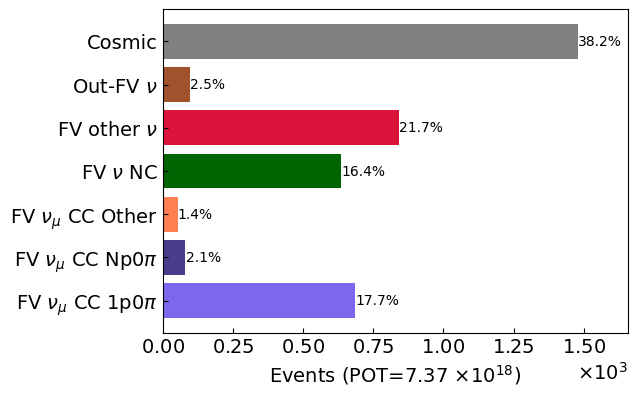

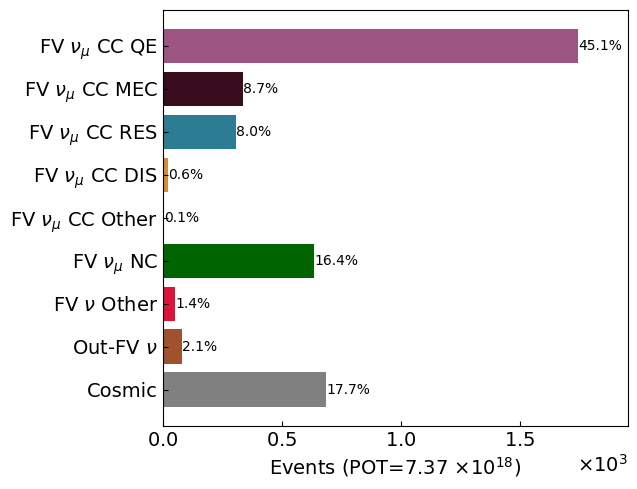

In [56]:
stage_key = "2prong-contained"
mc_mask = InFV(mc_track1.pfp.trk.end) & InFV(mc_track2.pfp.trk.end)
mc_evt_df_2prong = mc_evt_df[mc_mask]
data_mask = InFV(data_track1.pfp.trk.end) & InFV(data_track2.pfp.trk.end)
data_evt_df_2prong = data_evt_df[data_mask]
intime_mask = InFV(intime_track1.pfp.trk.end) & InFV(intime_track2.pfp.trk.end)
intime_evt_df_2prong = intime_evt_df[intime_mask]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_2prong
df_dict_data[stage_key] = data_evt_df_2prong
df_dict_intime[stage_key] = intime_evt_df_2prong
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]


/tmp/ipykernel_2517148/2378054513.py:136: RuntimeWarning: invalid value encountered in divide
  mc_stat_err_ratio = mc_stat_err / total_mc
/tmp/ipykernel_2517148/2378054513.py:137: RuntimeWarning: invalid value encountered in divide
  mc_content_ratio = total_mc / total_mc
/tmp/ipykernel_2517148/2378054513.py:155: RuntimeWarning: invalid value encountered in divide
  data_ratio = total_data / total_mc
/tmp/ipykernel_2517148/2378054513.py:156: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eylow = data_eylow / total_mc
/tmp/ipykernel_2517148/2378054513.py:157: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eyhigh = data_eyhigh / total_mc
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/matplotlib/axes/_base.py:2982: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin


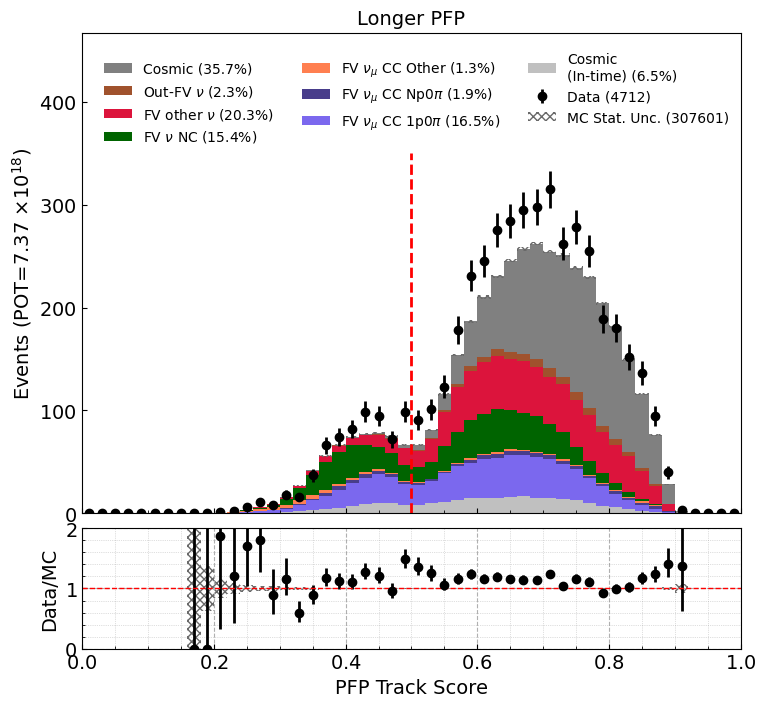

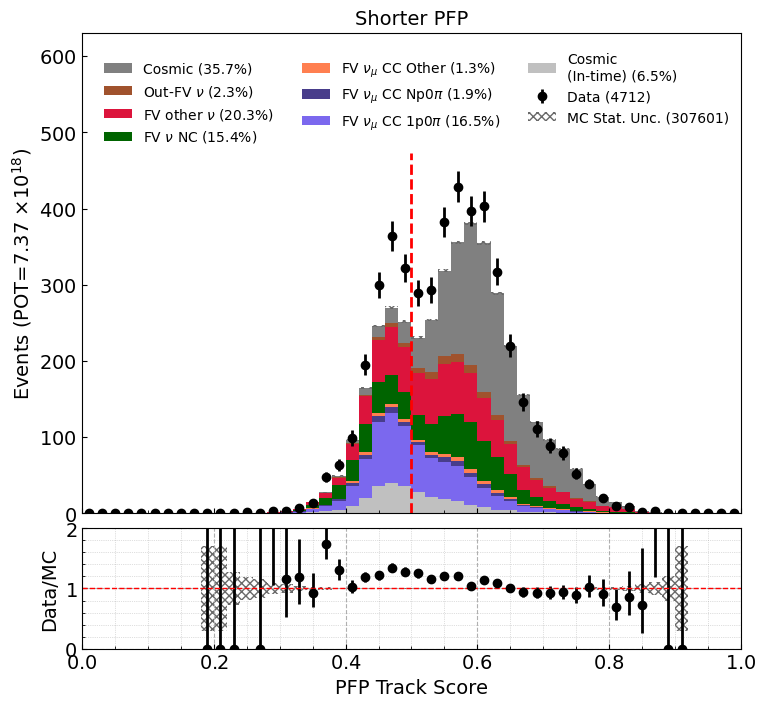

In [57]:
# ==== PID scores for tracks in 2-prong slices ====
plot_type = "topology"
bins = np.linspace(0, 1, 51)
vline = [0.5]

evtdf = mc_evt_df_2prong
vardf = mc_evt_df_2prong.t1.pfp.trackScore
vardf_data = data_evt_df_2prong.t1.pfp.trackScore
vardf_intime = intime_evt_df_2prong.t1.pfp.trackScore
plot_labels = ["PFP Track Score", 
               "Events (POT={})".format(pot_str), "Longer PFP"]

save_name = save_fig_dir + "/pfp_trackscore_{}_t1.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df_2prong
vardf = mc_evt_df_2prong.t2.pfp.trackScore
vardf_data = data_evt_df_2prong.t2.pfp.trackScore
vardf_intime = intime_evt_df_2prong.t2.pfp.trackScore
plot_labels = ["PFP Track Score", 
               "Events (POT={})".format(pot_str), "Shorter PFP"]

save_name = save_fig_dir + "/pfp_trackscore_{}_t2.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


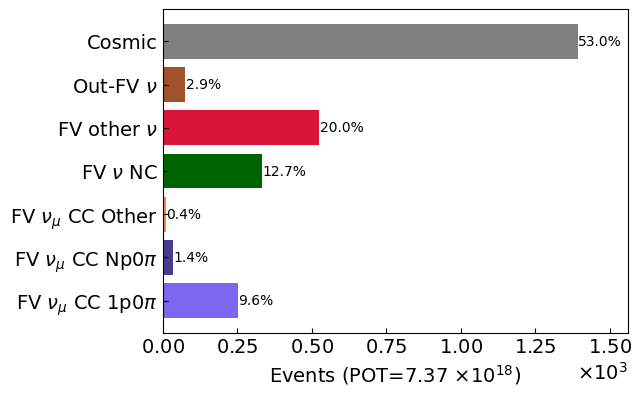

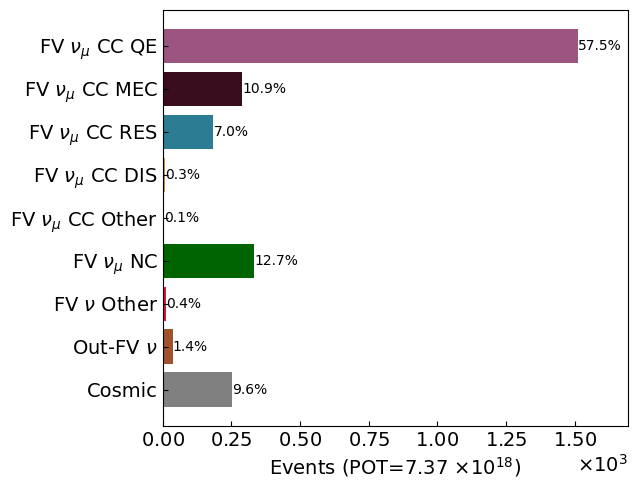

In [58]:
# both track have trackscore > 0.5
stage_key = "2prong-trackscore"
trackscore_th = 0.5
mc_mask = mc_mask & (mc_track1.pfp.trackScore > trackscore_th) & (mc_track2.pfp.trackScore > trackscore_th)
mc_evt_df_2prong = mc_evt_df[mc_mask]
data_mask = data_mask & (data_track1.pfp.trackScore > trackscore_th) & (data_track2.pfp.trackScore > trackscore_th)
data_evt_df_2prong = data_evt_df[data_mask]
intime_mask = intime_mask & (intime_track1.pfp.trackScore > trackscore_th) & (intime_track2.pfp.trackScore > trackscore_th)
intime_evt_df_2prong = intime_evt_df[intime_mask]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_2prong
df_dict_data[stage_key] = data_evt_df_2prong
df_dict_intime[stage_key] = intime_evt_df_2prong
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

mc_trk_df_2prong = mc_trk_df_2prong.reset_index(level=[3]).loc[mc_evt_df_2prong.index].reset_index().set_index(trk_indexnames)
data_trk_df_2prong = data_trk_df_2prong.reset_index(level=[3]).loc[data_evt_df_2prong.index].reset_index().set_index(trk_indexnames)
intime_trk_df_2prong = intime_trk_df_2prong.reset_index(level=[3]).loc[intime_evt_df_2prong.index].reset_index().set_index(trk_indexnames)

In [59]:
eps = 1e-8

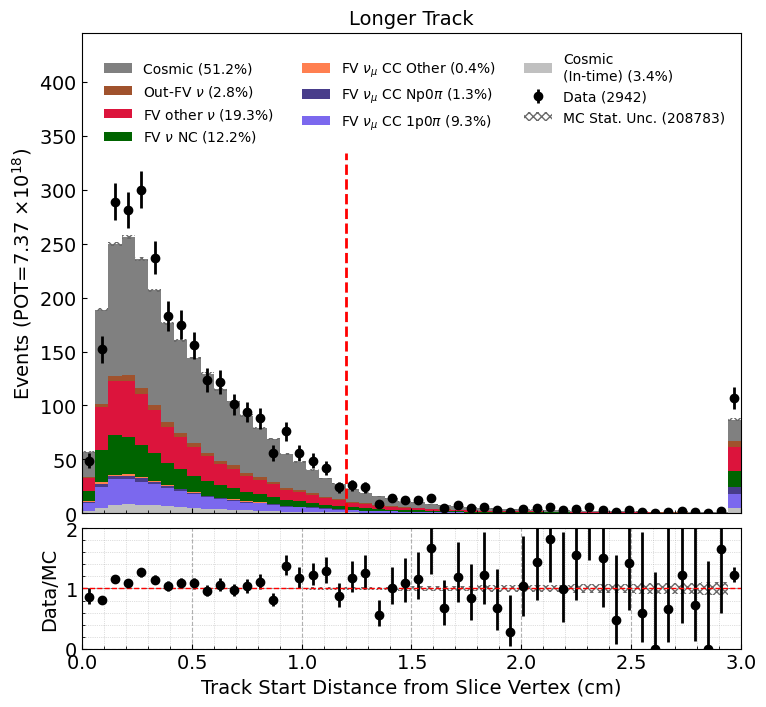

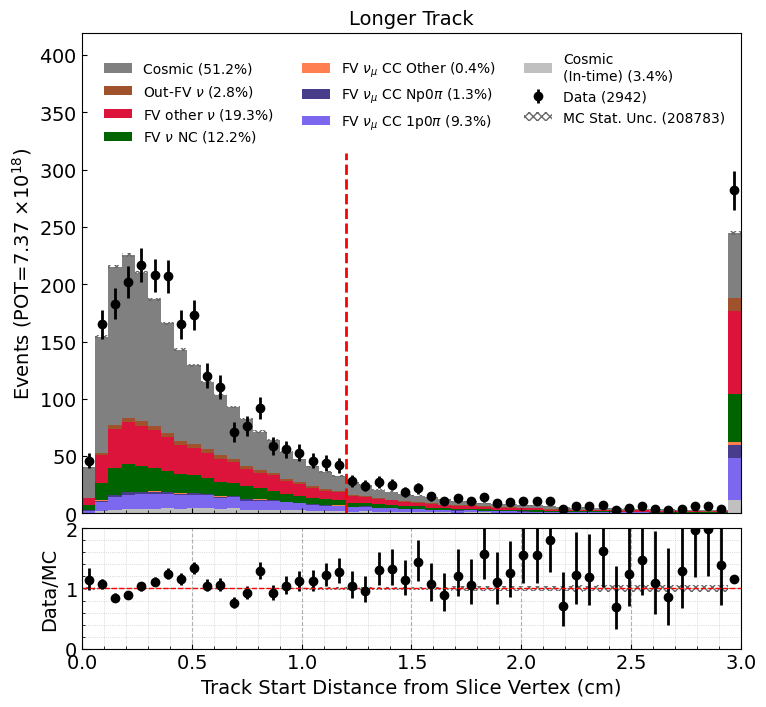

In [60]:
# ==== PID scores for tracks in 2-prong slices ====

plot_type = "topology"
bins = np.linspace(0, 3, 51)
vline = [1.2]

evtdf = mc_evt_df_2prong
vardf = mag3d(mc_evt_df_2prong.t1.pfp.trk.start, mc_evt_df_2prong.slc.vertex)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = mag3d(data_evt_df_2prong.t1.pfp.trk.start, data_evt_df_2prong.slc.vertex)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = mag3d(intime_evt_df_2prong.t1.pfp.trk.start, intime_evt_df_2prong.slc.vertex)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Track Start Distance from Slice Vertex (cm)", 
               "Events (POT={})".format(pot_str), "Longer Track"]

save_name = save_fig_dir + "/start_vertex_dist_{}_t1.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df_2prong
vardf = mag3d(mc_evt_df_2prong.t2.pfp.trk.start, mc_evt_df_2prong.slc.vertex)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = mag3d(data_evt_df_2prong.t2.pfp.trk.start, data_evt_df_2prong.slc.vertex)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = mag3d(intime_evt_df_2prong.t2.pfp.trk.start, intime_evt_df_2prong.slc.vertex)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Track Start Distance from Slice Vertex (cm)", 
               "Events (POT={})".format(pot_str), "Longer Track"]

save_name = save_fig_dir + "/start_vertex_dist_{}_t2.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)

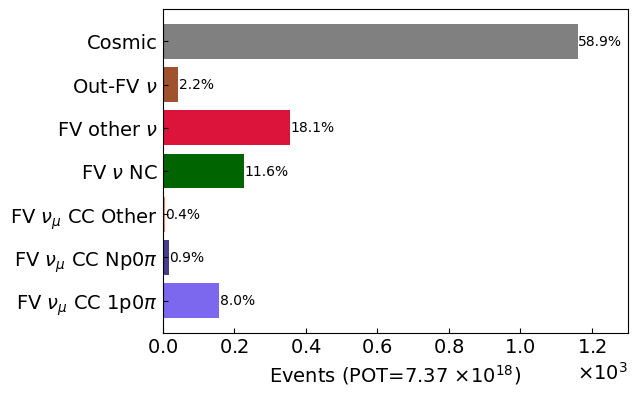

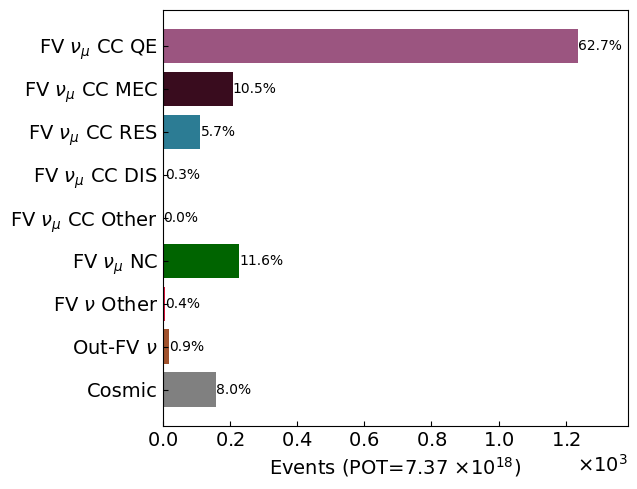

In [61]:
# both start (position - vertex) < 1 cm
stage_key = "2prong-start_vertex_dist"
dist_th = 1.2
mc_mask = mc_mask & (mag3d(mc_track1.pfp.trk.start, mc_evt_df.slc.vertex) < dist_th) & (mag3d(mc_track2.pfp.trk.start, mc_evt_df.slc.vertex) < dist_th)
mc_evt_df_2prong = mc_evt_df[mc_mask]
data_mask = data_mask & (mag3d(data_track1.pfp.trk.start, data_evt_df.slc.vertex) < dist_th) & (mag3d(data_track2.pfp.trk.start, data_evt_df.slc.vertex) < dist_th)
data_evt_df_2prong = data_evt_df[data_mask]
intime_mask = intime_mask & (mag3d(intime_track1.pfp.trk.start, intime_evt_df.slc.vertex) < dist_th) & (mag3d(intime_track2.pfp.trk.start, intime_evt_df.slc.vertex) < dist_th)
intime_evt_df_2prong = intime_evt_df[intime_mask]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong,
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_2prong, 
                        plot_labels=plot_labels_bar,
                        save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_2prong
df_dict_data[stage_key] = data_evt_df_2prong
df_dict_intime[stage_key] = intime_evt_df_2prong
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]


# tracks that belong to the slices that paseed the above cuts
# mc_track dfs have the same index levels as slc dfs
mc_track1 = mc_track1.loc[mc_evt_df_2prong.index]
mc_track2 = mc_track2.loc[mc_evt_df_2prong.index]
data_track1 = data_track1.loc[data_evt_df_2prong.index]
data_track2 = data_track2.loc[data_evt_df_2prong.index]
intime_track1 = intime_track1.loc[intime_evt_df_2prong.index]
intime_track2 = intime_track2.loc[intime_evt_df_2prong.index]

# PID
- cut on track length & chi2 scores
- (MCS fwd P - MCS bwd P)
- quality cut on (range P - MCS P)
- TODO: number of daughter particles?

In [62]:
# compbine longer & shorter tracks into one df
trk_indexnames = list(mc_track1.index.names) + [("pfp", "tindex", "", "", "", "", "")]
mc_trk_df_2prong = pd.concat([mc_track1.reset_index().set_index(trk_indexnames),
                              mc_track2.reset_index().set_index(trk_indexnames)])
data_trk_df_2prong = pd.concat([data_track1.reset_index().set_index(trk_indexnames),
                              data_track2.reset_index().set_index(trk_indexnames)])
intime_trk_df_2prong = pd.concat([intime_track1.reset_index().set_index(trk_indexnames),
                              intime_track2.reset_index().set_index(trk_indexnames)])

## Selection

In [63]:
def avg_chi2(df, var_name):
    planes = ['I0', 'I1', 'I2']
    chi2_vals = []
    for plane in planes:
        chi2 = df['pfp']['trk']['chi2pid'][plane][var_name]
        chi2_vals.append(chi2)
    chi2_df = pd.concat(chi2_vals, axis=1)
    # fill 0 with nan
    chi2_df = chi2_df.replace(0, np.nan)
    avg = chi2_df.mean(axis=1, skipna=True)
    return avg

### data vs. MC

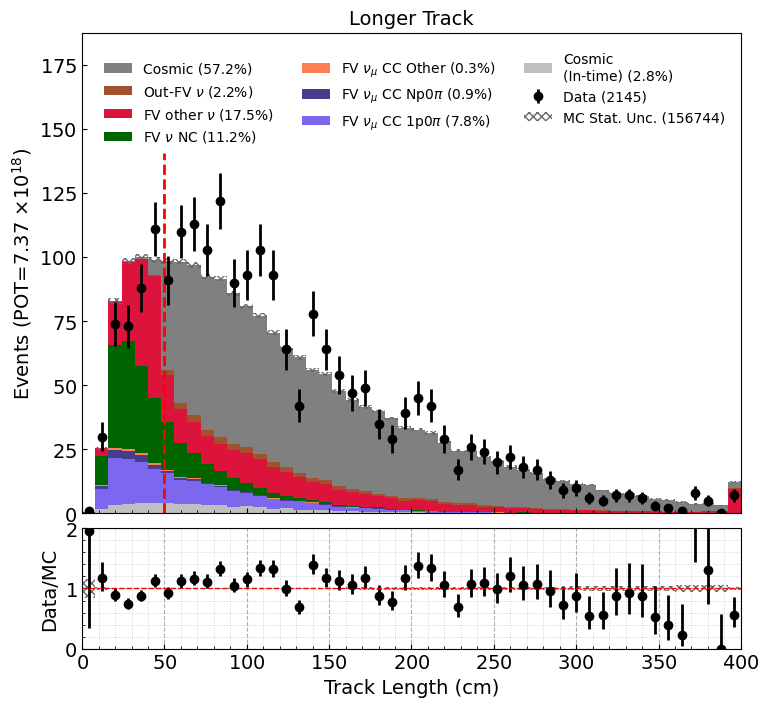

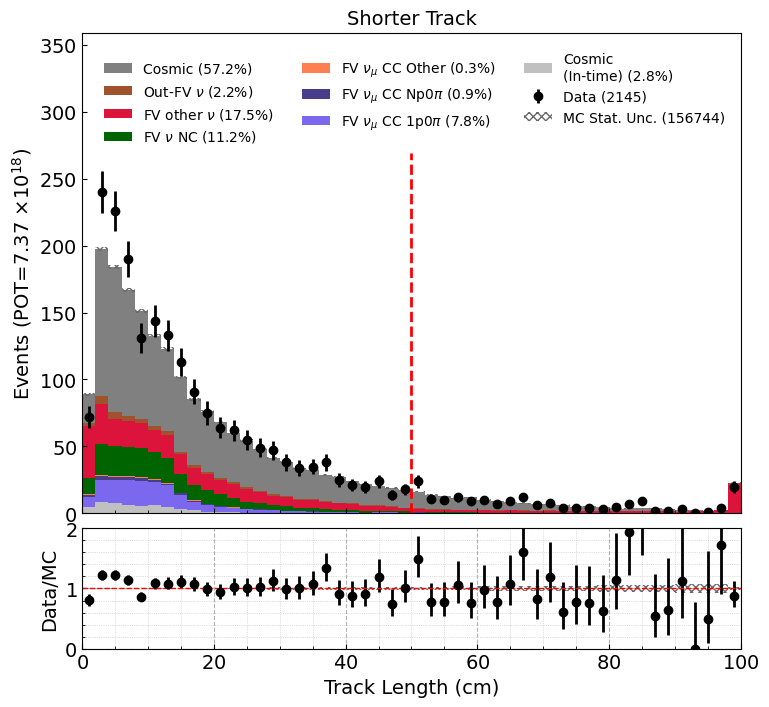

In [64]:
plot_type = "topology"
bins = np.linspace(0., 400, 51)
vline = [50]
evtdf = mc_evt_df_2prong

vardf = mc_evt_df_2prong.t1.pfp.trk.len
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = data_evt_df_2prong.t1.pfp.trk.len
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = intime_evt_df_2prong.t1.pfp.trk.len
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Track Length (cm)", 
               "Events (POT={})".format(pot_str), "Longer Track"]

save_name = save_fig_dir + "/length_{}_t1.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


bins = np.linspace(0., 100, 51)
vardf = mc_evt_df_2prong.t2.pfp.trk.len
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = data_evt_df_2prong.t2.pfp.trk.len
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = intime_evt_df_2prong.t2.pfp.trk.len
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Track Length (cm)", 
               "Events (POT={})".format(pot_str), "Shorter Track"]

save_name = save_fig_dir + "/length_{}_t2.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)

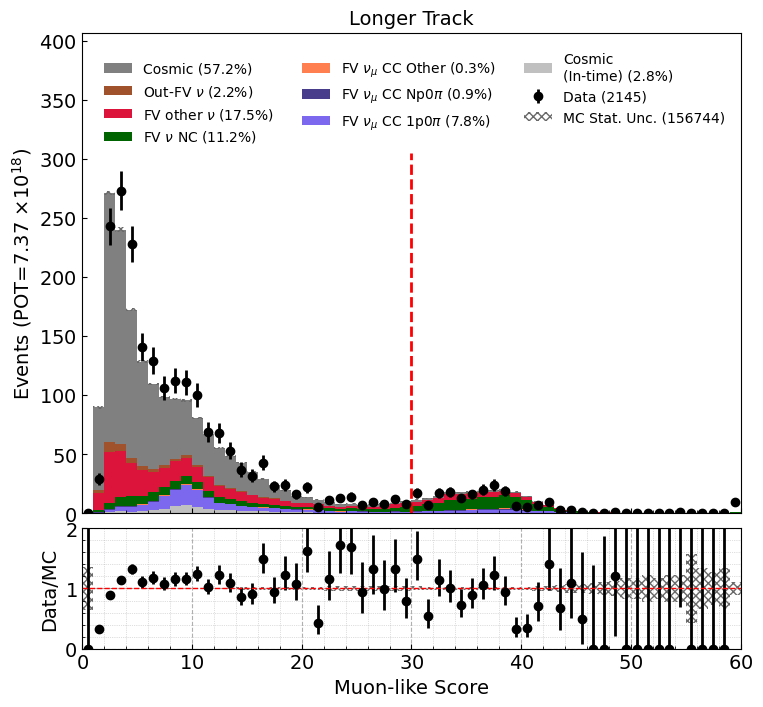

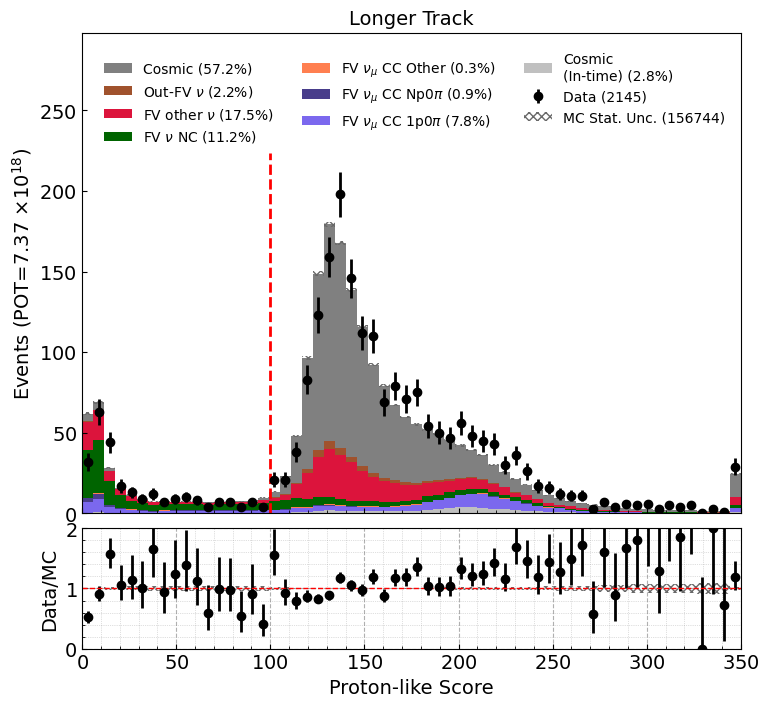

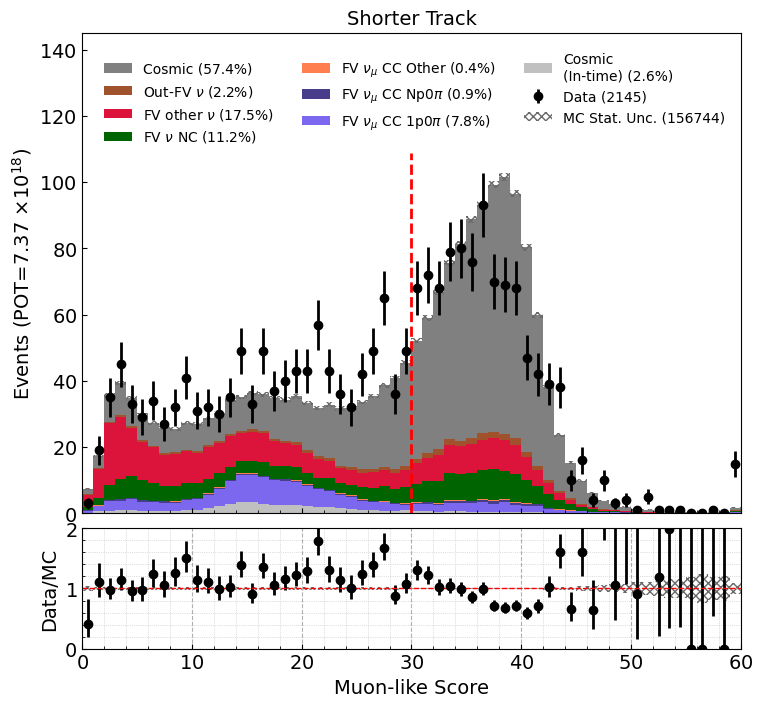

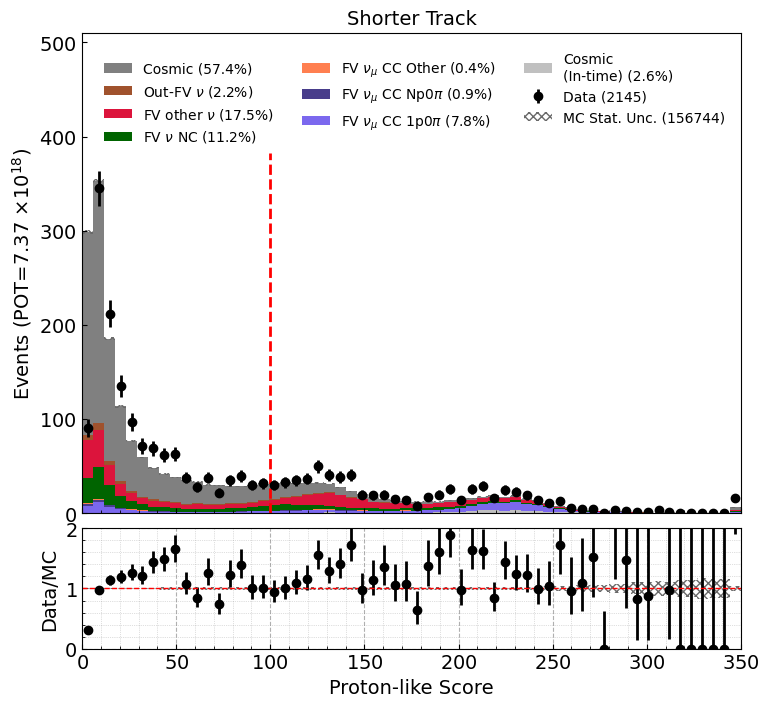

In [65]:
# mu_chi2mu_th = 35
# mu_chi2p_th = 100
# mu_len_th = 50
# mc_mu_cut = mc_mu_cut & (mc_chimu_avg / mc_chipi_avg < 1) 
# mc_mu_cut = mc_mu_cut & (np.abs((mc_trk_df_2prong.pfp.trk.rangeP.p_muon - mc_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / mc_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)
# ==== PID scores for tracks in 2-prong slices, after contained track requirement ====

# --- shorter track ---
plot_type = "topology"
bins = np.linspace(0, 60, 61)
vline = [30]
evtdf = mc_evt_df_2prong
vardf = avg_chi2(mc_evt_df_2prong.t1, "chi2_muon")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong.t1, "chi2_muon")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong.t1, "chi2_muon")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Muon-like Score", 
               "Events (POT={})".format(pot_str), "Longer Track"]

save_name = save_fig_dir + "/chi2muon_{}_t1.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)
plot_type = "topology"
bins = np.linspace(0, 350, 61)
vline = [100]
evtdf = mc_evt_df_2prong
vardf = avg_chi2(mc_evt_df_2prong.t1, "chi2_proton")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong.t1, "chi2_proton")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong.t1, "chi2_proton")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Proton-like Score", 
               "Events (POT={})".format(pot_str), "Longer Track"]

save_name = save_fig_dir + "/chi2proton_{}_t1.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


# --- shorter track ---
plot_type = "topology"
bins = np.linspace(0, 60, 61)
vline = [30]
evtdf = mc_evt_df_2prong
vardf = avg_chi2(mc_evt_df_2prong.t2, "chi2_muon")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong.t2, "chi2_muon")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong.t2, "chi2_muon")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Muon-like Score", 
               "Events (POT={})".format(pot_str), "Shorter Track"]

save_name = save_fig_dir + "/chi2muon_{}_t2.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)

plot_type = "topology"
bins = np.linspace(0, 350, 61)
vline = [100]
evtdf = mc_evt_df_2prong
vardf = avg_chi2(mc_evt_df_2prong.t2, "chi2_proton")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong.t2, "chi2_proton")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong.t2, "chi2_proton")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Proton-like Score", 
               "Events (POT={})".format(pot_str), "Shorter Track"]

save_name = save_fig_dir + "/chi2proton_{}_t2.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


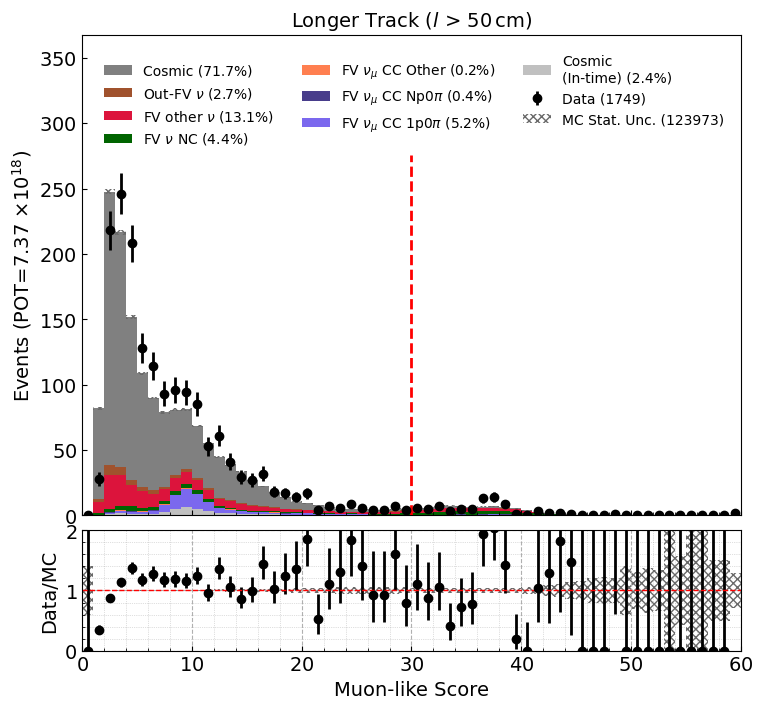

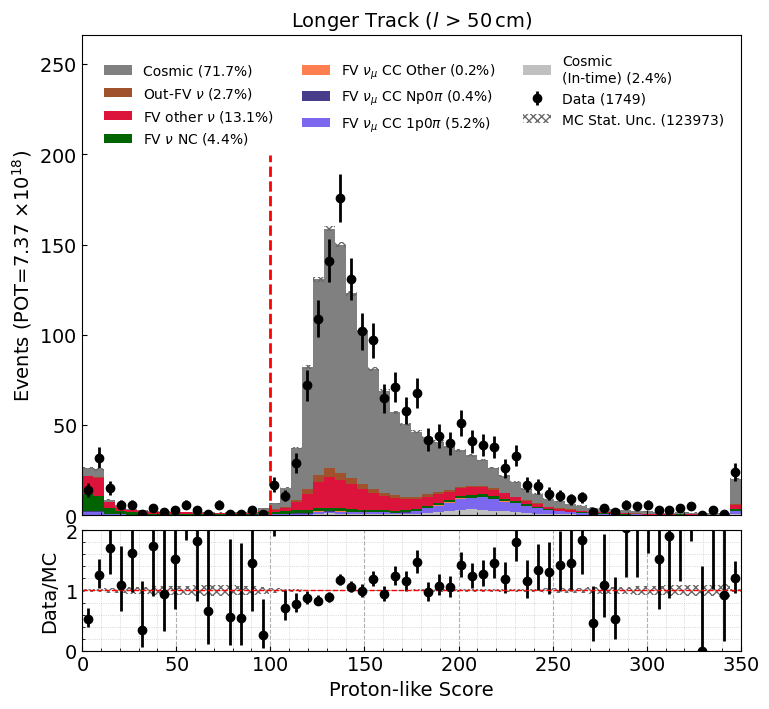

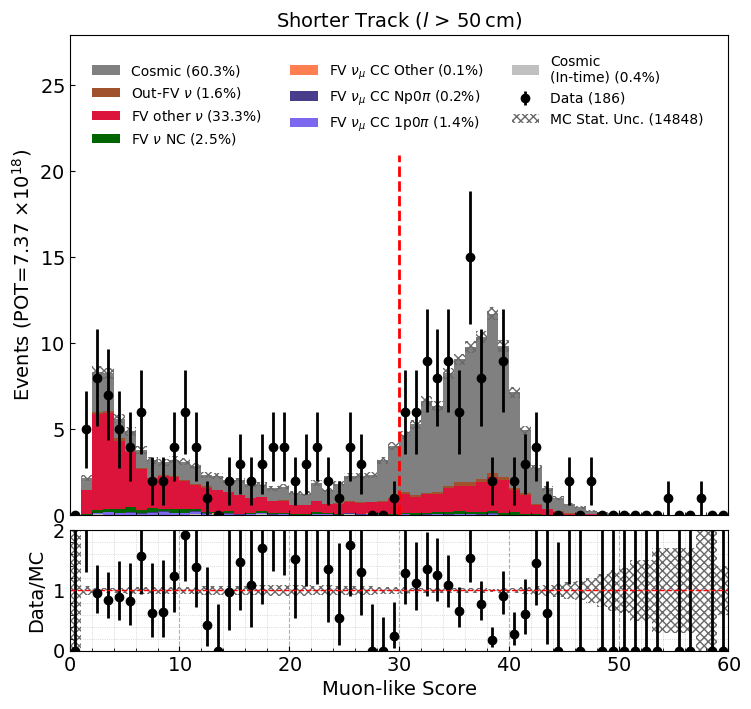

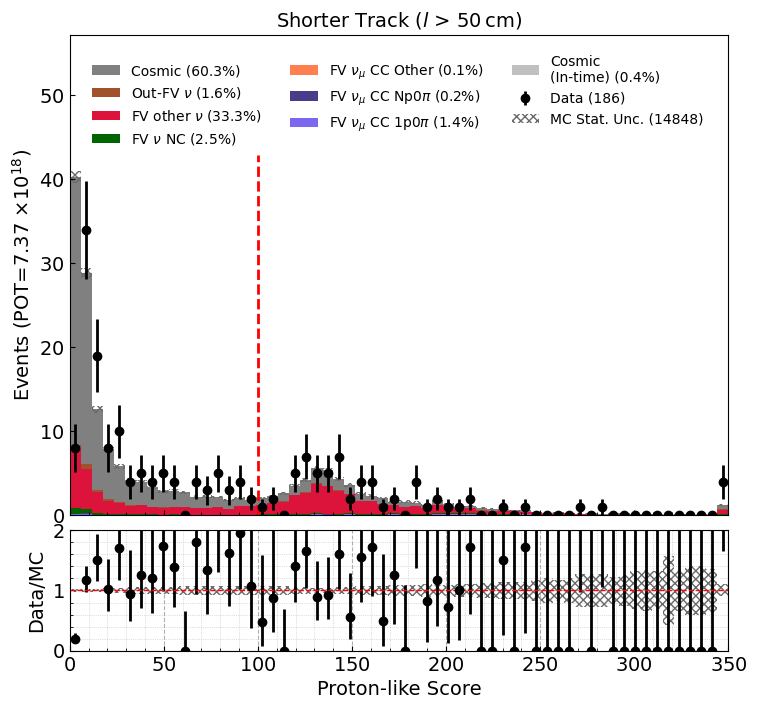

In [66]:
# mu_chi2mu_th = 35
# mu_chi2p_th = 100
# mu_len_th = 50
# mc_mu_cut = mc_mu_cut & (mc_chimu_avg / mc_chipi_avg < 1) 
# mc_mu_cut = mc_mu_cut & (np.abs((mc_trk_df_2prong.pfp.trk.rangeP.p_muon - mc_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / mc_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)
# ==== PID scores for tracks in 2-prong slices, after contained track requirement ====

# --- shorter track ---
plot_type = "topology"
bins = np.linspace(0, 60, 61)
vline = [30]
evtdf = mc_evt_df_2prong[mc_evt_df_2prong.t1.pfp.trk.len > 50]
vardf = avg_chi2(mc_evt_df_2prong[mc_evt_df_2prong.t1.pfp.trk.len > 50].t1, "chi2_muon")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong[data_evt_df_2prong.t1.pfp.trk.len > 50].t1, "chi2_muon")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong[intime_evt_df_2prong.t1.pfp.trk.len > 50].t1, "chi2_muon")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Muon-like Score", 
               "Events (POT={})".format(pot_str), r"Longer Track ($l$ > 50$\,$cm)"]

save_name = save_fig_dir + "/chi2muon_{}_t1_l50.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)
plot_type = "topology"
bins = np.linspace(0, 350, 61)
vline = [100]
evtdf = mc_evt_df_2prong[mc_evt_df_2prong.t1.pfp.trk.len > 50]
vardf = avg_chi2(mc_evt_df_2prong[mc_evt_df_2prong.t1.pfp.trk.len > 50].t1, "chi2_proton")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong[data_evt_df_2prong.t1.pfp.trk.len > 50].t1, "chi2_proton")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong[intime_evt_df_2prong.t1.pfp.trk.len > 50].t1, "chi2_proton")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Proton-like Score", 
               "Events (POT={})".format(pot_str), r"Longer Track ($l$ > 50$\,$cm)"]

save_name = save_fig_dir + "/chi2proton_{}_t1_l50.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


# --- shorter track ---
plot_type = "topology"
bins = np.linspace(0, 60, 61)
vline = [30]
evtdf = mc_evt_df_2prong[mc_evt_df_2prong.t2.pfp.trk.len > 50]
vardf = avg_chi2(mc_evt_df_2prong[mc_evt_df_2prong.t2.pfp.trk.len > 50].t2, "chi2_muon")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong[data_evt_df_2prong.t2.pfp.trk.len > 50].t2, "chi2_muon")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong[intime_evt_df_2prong.t2.pfp.trk.len > 50].t2, "chi2_muon")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Muon-like Score", 
               "Events (POT={})".format(pot_str), r"Shorter Track ($l$ > 50$\,$cm)"]

save_name = save_fig_dir + "/chi2muon_{}_t2_l50.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)

plot_type = "topology"
bins = np.linspace(0, 350, 61)
vline = [100]
evtdf = mc_evt_df_2prong[mc_evt_df_2prong.t2.pfp.trk.len > 50]
vardf = avg_chi2(mc_evt_df_2prong[mc_evt_df_2prong.t2.pfp.trk.len > 50].t2, "chi2_proton")
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = avg_chi2(data_evt_df_2prong[data_evt_df_2prong.t2.pfp.trk.len > 50].t2, "chi2_proton")
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = avg_chi2(intime_evt_df_2prong[intime_evt_df_2prong.t2.pfp.trk.len > 50].t2, "chi2_proton")
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["Proton-like Score", 
               "Events (POT={})".format(pot_str), r"Shorter Track ($l$ > 50$\,$cm)"]

save_name = save_fig_dir + "/chi2proton_{}_t2_l50.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)


In [67]:
# # mc_mu_cut = mc_mu_cut & (mc_chimu_avg / mc_chipi_avg < 1) 
# # mc_mu_cut = mc_mu_cut & (mc_trk_df_2prong.pfp.trk.len > 50)
# # mc_mu_cut = mc_mu_cut & (np.abs((mc_trk_df_2prong.pfp.trk.rangeP.p_muon - mc_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / mc_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)

# # --- shorter track ---
# plot_type = "topology"
# bins = np.linspace(0.3, 1.3, 61)
# vline = [1]
# evtdf = mc_evt_df_2prong

# vardf = avg_chi2(mc_evt_df_2prong.t1, "chi2_muon") / avg_chi2(mc_evt_df_2prong.t1, "chi2_pion")
# vardf = np.clip(vardf, bins[0], bins[-1] - eps)
# vardf_data = avg_chi2(data_evt_df_2prong.t1, "chi2_muon") / avg_chi2(data_evt_df_2prong.t1, "chi2_pion")
# vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
# vardf_intime = avg_chi2(intime_evt_df_2prong.t1, "chi2_muon") / avg_chi2(intime_evt_df_2prong.t1, "chi2_pion")
# vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
# plot_labels = ["Muon-like Score / Pion-like Score", 
#                "Events (POT={})".format(pot_str), "Longer Track"]

# save_name = save_fig_dir + "/chi2muon_pion_{}_t1.png".format(plot_type)
# ret_hist_topo = hist_plot(plot_type,
#                           evtdf, vardf, 
#                           vardf_data, vardf_intime,
#                           bins,
#                           plot_labels,
#                           vline=vline,
#                           save_fig=save_fig, save_name=save_name)

# vardf = avg_chi2(mc_evt_df_2prong.t2, "chi2_muon") / avg_chi2(mc_evt_df_2prong.t2, "chi2_pion")
# vardf = np.clip(vardf, bins[0], bins[-1] - eps)
# vardf_data = avg_chi2(data_evt_df_2prong.t2, "chi2_muon") / avg_chi2(data_evt_df_2prong.t2, "chi2_pion")
# vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
# vardf_intime = avg_chi2(intime_evt_df_2prong.t2, "chi2_muon") / avg_chi2(intime_evt_df_2prong.t2, "chi2_pion")
# vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
# plot_labels = ["Muon-like Score / Pion-like Score", 
#                "Events (POT={})".format(pot_str), "Shorter Track"]

# save_name = save_fig_dir + "/chi2muon_pion_{}_t2.png".format(plot_type)
# ret_hist_topo = hist_plot(plot_type,
#                           evtdf, vardf, 
#                           vardf_data, vardf_intime,
#                           bins,
#                           plot_labels,
#                           vline=vline,
#                           save_fig=save_fig, save_name=save_name)

In [68]:
def range_p_mcs_p(df):
    frac_diff = (df.pfp.trk.rangeP.p_muon - df.pfp.trk.mcsP.fwdP_muon) / df.pfp.trk.rangeP.p_muon
    return frac_diff

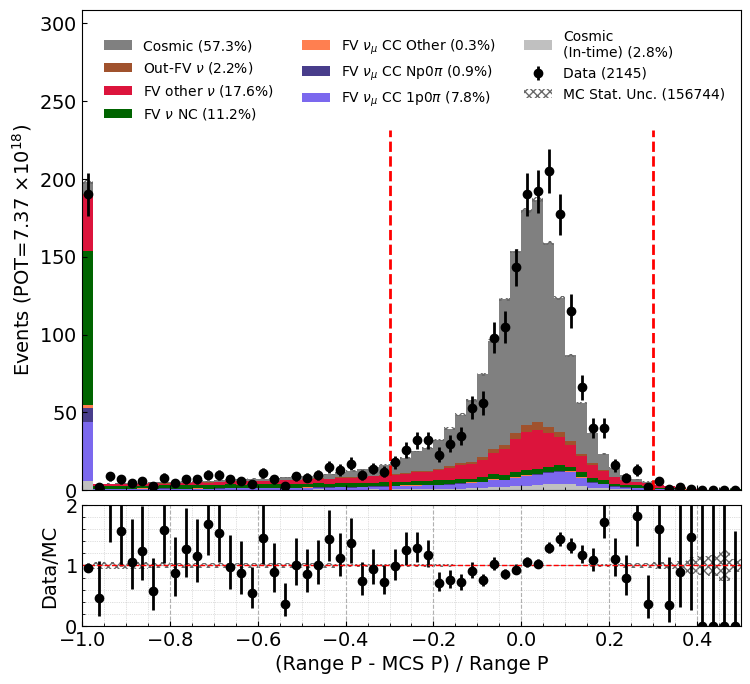

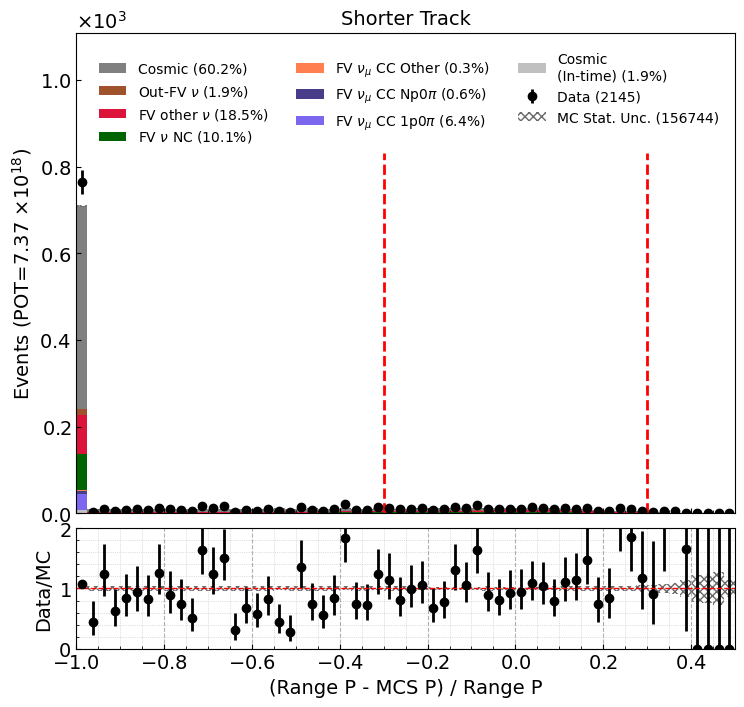

In [69]:
# mc_mu_cut = mc_mu_cut & (np.abs((mc_trk_df_2prong.pfp.trk.rangeP.p_muon - mc_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / mc_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)

# --- shorter track ---
plot_type = "topology"
bins = np.linspace(-1, 0.5, 61)
vline = [-0.3, 0.3]
evtdf = mc_evt_df_2prong

vardf = range_p_mcs_p(mc_evt_df_2prong.t1)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = range_p_mcs_p(data_evt_df_2prong.t1)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = range_p_mcs_p(intime_evt_df_2prong.t1)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["(Range P - MCS P) / Range P", 
               "Events (POT={})".format(pot_str), ""]

save_name = save_fig_dir + "/range_p_mcs_p_{}_t1.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)

vardf = range_p_mcs_p(mc_evt_df_2prong.t2)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = range_p_mcs_p(data_evt_df_2prong.t2)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = range_p_mcs_p(intime_evt_df_2prong.t2)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = ["(Range P - MCS P) / Range P", 
               "Events (POT={})".format(pot_str), "Shorter Track"]

save_name = save_fig_dir + "/range_p_mcs_p_{}_t2.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins,
                          plot_labels,
                          vline=vline,
                          save_fig=save_fig, save_name=save_name)

### PID scores per truth pdg

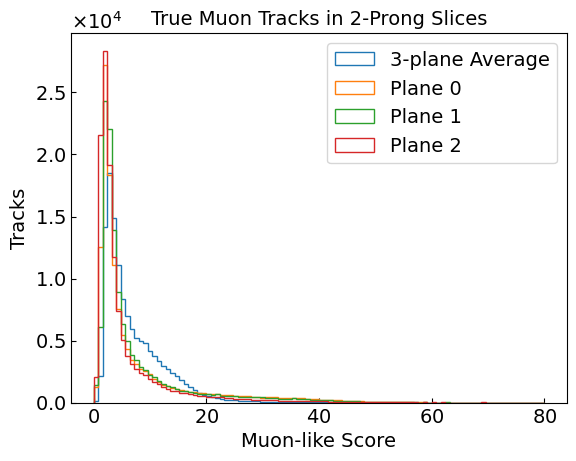

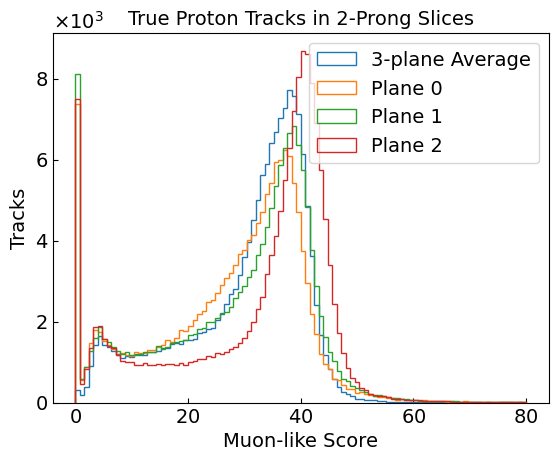

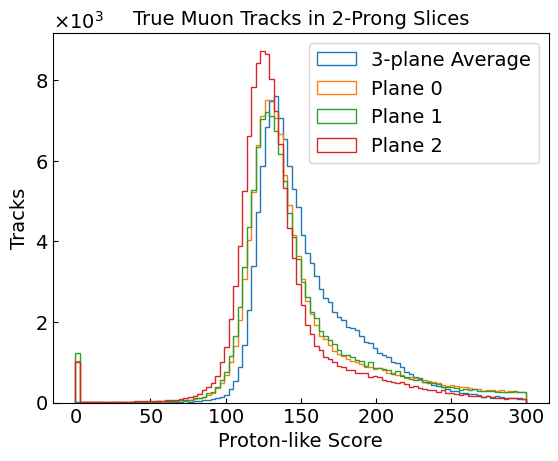

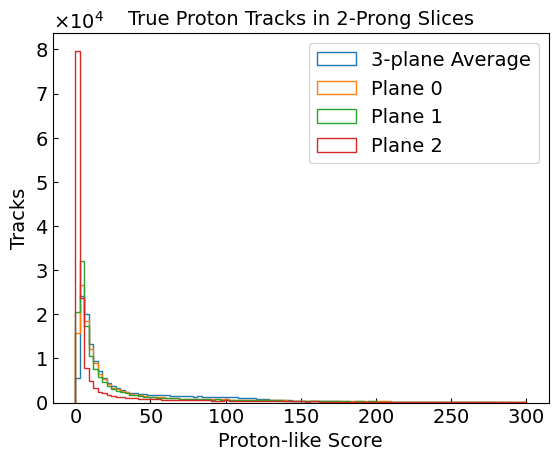

In [70]:
bins = np.linspace(0, 80, 101)
var = avg_chi2(mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13], "chi2_muon")
plt.hist(var, bins=bins, histtype="step", label="3-plane Average")
for i in range(3):
    var = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13].pfp.trk.chi2pid["I{}".format(i)].chi2_muon
    plt.hist(var, bins=bins, histtype="step", label="Plane {}".format(i))
plt.legend()
plt.xlabel("Muon-like Score")
plt.ylabel("Tracks")
plt.title("True Muon Tracks in 2-Prong Slices")
save_name = save_fig_dir + "/muon_chi2_muon_avg.png"
if save_fig:
    plt.savefig(save_name)
plt.show()

var = avg_chi2(mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 2212], "chi2_muon")
plt.hist(var, bins=bins, histtype="step", label="3-plane Average")
for i in range(3):
    var = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 2212].pfp.trk.chi2pid["I{}".format(i)].chi2_muon
    plt.hist(var, bins=bins, histtype="step", label="Plane {}".format(i))
plt.legend()
plt.xlabel("Muon-like Score")
plt.ylabel("Tracks")
plt.title("True Proton Tracks in 2-Prong Slices")
save_name = save_fig_dir + "/proton_chi2_muon_avg.png"
if save_fig:
    plt.savefig(save_name)
plt.show()

bins = np.linspace(0, 300, 101)
var = avg_chi2(mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13], "chi2_proton")
plt.hist(var, bins=bins, histtype="step", label="3-plane Average")
for i in range(3):
    var = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13].pfp.trk.chi2pid["I{}".format(i)].chi2_proton
    plt.hist(var, bins=bins, histtype="step", label="Plane {}".format(i))
plt.legend()
plt.xlabel("Proton-like Score")
plt.ylabel("Tracks")
plt.title("True Muon Tracks in 2-Prong Slices")
save_name = save_fig_dir + "/muon_chi2_proton_avg.png"
if save_fig:
    plt.savefig(save_name)
plt.show()

var = avg_chi2(mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 2212], "chi2_proton")
plt.hist(var, bins=bins, histtype="step", label="3-plane Average")
for i in range(3):
    var = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 2212].pfp.trk.chi2pid["I{}".format(i)].chi2_proton
    plt.hist(var, bins=bins, histtype="step", label="Plane {}".format(i))
plt.legend()
plt.xlabel("Proton-like Score")
plt.ylabel("Tracks")
plt.title("True Proton Tracks in 2-Prong Slices")
save_name = save_fig_dir + "/proton_chi2_proton_avg.png"
if save_fig:
    plt.savefig(save_name)
plt.show()

In [ ]:
# TODO: average score over planes
# ---- find muon candidate from all tracks
# purity scan
mc_chimu_avg = avg_chi2(mc_trk_df_2prong, "chi2_muon")
# mc_chipi_avg = avg_chi2(mc_trk_df_2prong, "chi2_pion")
mc_chip_avg = avg_chi2(mc_trk_df_2prong, "chi2_proton")
data_chimu_avg = avg_chi2(data_trk_df_2prong, "chi2_muon")
# data_chipi_avg = avg_chi2(data_trk_df_2prong, "chi2_pion")
data_chip_avg = avg_chi2(data_trk_df_2prong, "chi2_proton")
intime_chimu_avg = avg_chi2(intime_trk_df_2prong, "chi2_muon")
# intime_chipi_avg = avg_chi2(intime_trk_df_2prong, "chi2_pion")
intime_chip_avg = avg_chi2(intime_trk_df_2prong, "chi2_proton")


# --- optimized cut
mu_chi2mu_th = 30
mu_chi2p_th = 100
mu_len_th = 50

# mc_mu_cut = (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon > 0) & (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon < mu_chi2mu_th) & (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_proton > mu_chi2p_th)
mc_mu_cut = (mc_chimu_avg > 0) & (mc_chimu_avg < mu_chi2mu_th) & (mc_chip_avg > mu_chi2p_th)
mc_mu_cut = mc_mu_cut & (mc_trk_df_2prong.pfp.trk.len > 50)
mc_mu_candidates = mc_trk_df_2prong[mc_mu_cut]
mc_mu_candidates_prequal = mc_mu_candidates

# data_mu_cut = (data_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon > 0) & (data_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon < mu_chi2mu_th) & (data_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_proton > mu_chi2p_th)
data_mu_cut = (data_chimu_avg > 0) & (data_chimu_avg < mu_chi2mu_th) & (data_chip_avg > mu_chi2p_th)
data_mu_cut = data_mu_cut & (data_trk_df_2prong.pfp.trk.len > 50)
data_mu_candidates = data_trk_df_2prong[data_mu_cut]
data_mu_candidates_prequal = data_mu_candidates

# intime_mu_cut = (intime_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon > 0) & (intime_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon < mu_chi2mu_th) & (intime_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_proton > mu_chi2p_th)
intime_mu_cut = (intime_chimu_avg > 0) & (intime_chimu_avg < mu_chi2mu_th) & (intime_chip_avg > mu_chi2p_th)
intime_mu_cut = intime_mu_cut & (intime_trk_df_2prong.pfp.trk.len > 50)
intime_mu_candidates = intime_trk_df_2prong[intime_mu_cut]
intime_mu_candidates_prequal = intime_mu_candidates

# more muon-like than pion-like
# mu_cut = mu_cut & (mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_muon < mc_trk_df_2prong.pfp.trk.chi2pid.I2.chi2_pion * 0.9)

# muon quality cut
qual_th = 0.3
mc_mu_cut = mc_mu_cut & (np.abs((mc_trk_df_2prong.pfp.trk.rangeP.p_muon - mc_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / mc_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)
# mc_mu_cut = mc_mu_cut & (mc_chimu_avg / mc_chipi_avg < 1) 
mc_mu_candidates = mc_trk_df_2prong[mc_mu_cut]
data_mu_cut = data_mu_cut & (np.abs((data_trk_df_2prong.pfp.trk.rangeP.p_muon - data_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / data_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)
# data_mu_cut = data_mu_cut & (data_chimu_avg / data_chipi_avg < 1)
data_mu_candidates = data_trk_df_2prong[data_mu_cut]
intime_mu_cut = intime_mu_cut & (np.abs((intime_trk_df_2prong.pfp.trk.rangeP.p_muon - intime_trk_df_2prong.pfp.trk.mcsP.fwdP_muon) / intime_trk_df_2prong.pfp.trk.rangeP.p_muon) < qual_th)
# intime_mu_cut = intime_mu_cut & (intime_chimu_avg / intime_chipi_avg < 1)
intime_mu_candidates = intime_trk_df_2prong[intime_mu_cut]

# if multiple mu candidates in a slice, choose the longer one
mc_mu_candidates = mc_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
mc_mu_candidate = mc_mu_candidates.groupby(level=[0,1,2]).nth(0)
data_mu_candidates = data_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
data_mu_candidate = data_mu_candidates.groupby(level=[0,1,2]).nth(0)
intime_mu_candidates = intime_mu_candidates.sort_values(by=('pfp', 'trk', 'len'), ascending=False)
intime_mu_candidate = intime_mu_candidates.groupby(level=[0,1,2]).nth(0)

mc_mu_eff = len(mc_mu_candidates[mc_mu_candidates.pfp.trk.truth.p.pdg == 13])/len(mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13])
mc_mu_purity = len(mc_mu_candidate[mc_mu_candidate.pfp.trk.truth.p.pdg == 13])/len(mc_mu_candidate)
print("chimu: {}, chip: {}, muon efficiency: {}, purity: {}".format(mu_chi2mu_th, mu_chi2p_th, mc_mu_eff, mc_mu_purity))

chimu: 20, chip: 100, muon efficiency: 0.7950107706205267, purity: 0.9478309786417795


In [ ]:
mc_trk_idx = mc_trk_df_2prong.index.difference(mc_mu_candidate.index)
mc_not_mu_candidate = mc_trk_df_2prong.loc[mc_trk_idx]
mc_chimu_avg = avg_chi2(mc_not_mu_candidate, "chi2_muon")
mc_chip_avg = avg_chi2(mc_not_mu_candidate, "chi2_proton")
data_trk_idx = data_trk_df_2prong.index.difference(data_mu_candidate.index)
data_not_mu_candidate = data_trk_df_2prong.loc[data_trk_idx]
data_chimu_avg = avg_chi2(data_not_mu_candidate, "chi2_muon")
data_chip_avg = avg_chi2(data_not_mu_candidate, "chi2_proton")
intime_trk_idx = intime_trk_df_2prong.index.difference(intime_mu_candidate.index)
intime_not_mu_candidate = intime_trk_df_2prong.loc[intime_trk_idx]
intime_chimu_avg = avg_chi2(intime_not_mu_candidate, "chi2_muon")
intime_chip_avg = avg_chi2(intime_not_mu_candidate, "chi2_proton")

# ---- in leftovers, find proton candidates
p_chi2p_th = 90

# mc_p_cut = (mc_not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton > 0) & (mc_not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton < p_chi2p_th)
mc_p_cut = (mc_chip_avg > 0) & (mc_chip_avg < p_chi2p_th)
mc_p_candidates = mc_not_mu_candidate[mc_p_cut]

# data_p_cut = (data_not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton > 0) & (data_not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton < p_chi2p_th)
data_p_cut = (data_chip_avg > 0) & (data_chip_avg < p_chi2p_th)
data_p_candidates = data_not_mu_candidate[data_p_cut]

# intime_p_cut = (intime_not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton > 0) & (intime_not_mu_candidate.pfp.trk.chi2pid.I2.chi2_proton < p_chi2p_th)
intime_p_cut = (intime_chip_avg > 0) & (intime_chip_avg < p_chi2p_th)
intime_p_candidates = intime_not_mu_candidate[intime_p_cut]

print("proton efficiency", len(mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212])/len(mc_not_mu_candidate[mc_not_mu_candidate.pfp.trk.truth.p.pdg == 2212]))
print("proton purity", len(mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212])/len(mc_p_candidates))

proton efficiency 0.8107385982294097
proton purity 0.9937088194047274


mc_mu_idx 107604
mc_p_idx 111923
mc_mu_p_idx 75651
data_mu_idx 1515
data_p_idx 1386
data_mu_p_idx 964
intime_mu_idx 3036
intime_p_idx 572
intime_mu_p_idx 55


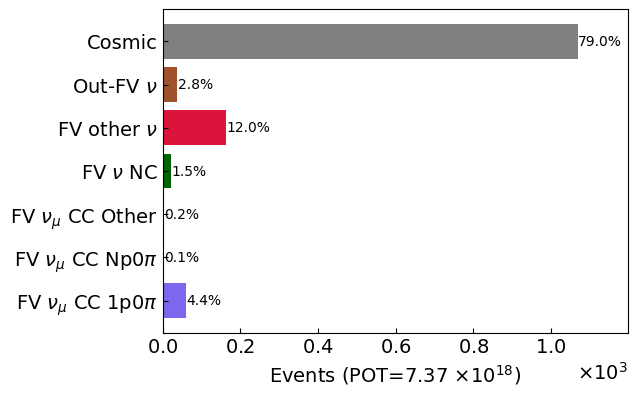

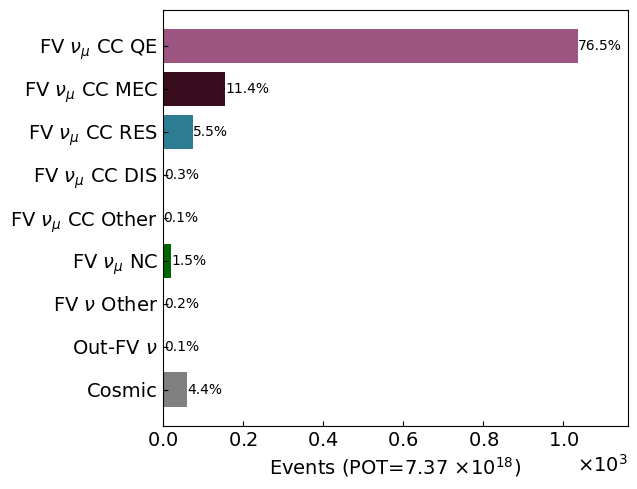

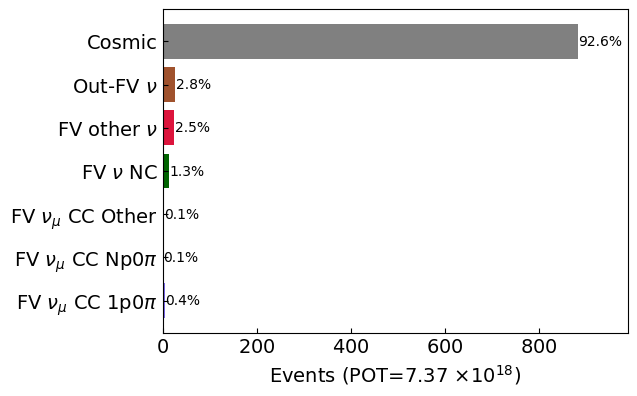

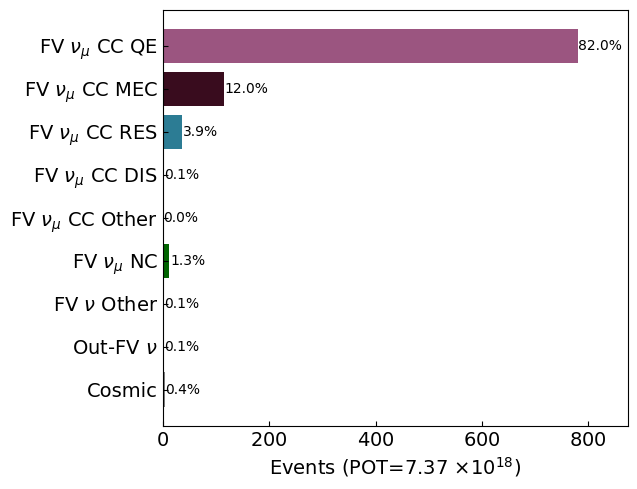

In [ ]:
# ---- limit to the target kinematic range 
MASS_MUON = 0.1056583745
mu_low_th = 0.22
mu_hi_th = 1

mc_mu_candidate_nopcut = mc_mu_candidate
mc_mu_kin_cut = (mc_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
mc_mu_kin_cut = mc_mu_kin_cut & (mc_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
mc_mu_candidate = mc_mu_candidate[mc_mu_kin_cut]
data_mu_kin_cut = (data_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
data_mu_kin_cut = data_mu_kin_cut & (data_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
data_mu_candidate = data_mu_candidate[data_mu_kin_cut]
intime_mu_kin_cut = (intime_mu_candidate.pfp.trk.rangeP.p_muon > mu_low_th)
intime_mu_kin_cut = intime_mu_kin_cut & (intime_mu_candidate.pfp.trk.rangeP.p_muon < mu_hi_th)
intime_mu_candidate = intime_mu_candidate[intime_mu_kin_cut]

MASS_PROTON = 0.938272081
p_low_th = 0.3
p_hi_th = 1

mc_p_candidates_nopcut = mc_p_candidates
mc_p_kin_cut = (mc_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
mc_p_kin_cut = mc_p_kin_cut & (mc_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
mc_p_candidates = mc_p_candidates[mc_p_kin_cut]
data_p_kin_cut = (data_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
data_p_kin_cut = data_p_kin_cut & (data_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
data_p_candidates = data_p_candidates[data_p_kin_cut]
intime_p_kin_cut = (intime_p_candidates.pfp.trk.rangeP.p_proton > p_low_th)
intime_p_kin_cut = intime_p_kin_cut & (intime_p_candidates.pfp.trk.rangeP.p_proton < p_hi_th)
intime_p_candidates = intime_p_candidates[intime_p_kin_cut]

# select mu-X slice
stage_key = "2prong-muX"
mc_mu_idx = mc_mu_candidate.reset_index(level=[3]).index.unique()
mc_evt_df_muX = mc_evt_df_2prong.loc[mc_mu_idx]
data_mu_idx = data_mu_candidate.reset_index(level=[3]).index.unique()
data_evt_df_muX = data_evt_df_2prong.loc[data_mu_idx]
intime_mu_idx = intime_mu_candidate.reset_index(level=[3]).index.unique()
intime_evt_df_muX = intime_evt_df_2prong.loc[intime_mu_idx]

bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_muX,
                     plot_labels=plot_labels_bar,
                     save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_muX, 
                      plot_labels=plot_labels_bar,
                      save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_muX
df_dict_data[stage_key] = data_evt_df_muX
df_dict_intime[stage_key] = intime_evt_df_muX
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# select mu-p slice
stage_key = "2prong-mup"
mc_p_idx = mc_p_candidates.reset_index(level=[3]).index.unique()
mc_mu_p_idx = mc_mu_idx.intersection(mc_p_idx)
print("mc_mu_idx", len(mc_mu_idx))
print("mc_p_idx", len(mc_p_idx))
print("mc_mu_p_idx", len(mc_mu_p_idx))
data_p_idx = data_p_candidates.reset_index(level=[3]).index.unique()
data_mu_p_idx = data_mu_idx.intersection(data_p_idx)
print("data_mu_idx", len(data_mu_idx))
print("data_p_idx", len(data_p_idx))
print("data_mu_p_idx", len(data_mu_p_idx))
intime_p_idx = intime_p_candidates.reset_index(level=[3]).index.unique()
intime_mu_p_idx = intime_mu_idx.intersection(intime_p_idx)
print("intime_mu_idx", len(intime_mu_idx))
print("intime_p_idx", len(intime_p_idx))
print("intime_mu_p_idx", len(intime_mu_p_idx))

mc_evt_df_mup = mc_evt_df_2prong.loc[mc_mu_p_idx]
data_evt_df_mup = data_evt_df_2prong.loc[data_mu_p_idx]
intime_evt_df_mup = intime_evt_df_2prong.loc[intime_mu_p_idx]
bar_type = "topology"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_topo = bar_plot(type=bar_type, evtdf=mc_evt_df_mup,
                     plot_labels=plot_labels_bar,
                     save_fig=save_fig, save_name=save_name)

bar_type = "genie"
save_name = save_fig_dir + "/bar_plot-{}-{}.png".format(bar_type, stage_key)
ret_genie = bar_plot(type=bar_type, evtdf=mc_evt_df_mup, 
                      plot_labels=plot_labels_bar,
                      save_fig=save_fig, save_name=save_name)

df_dict[stage_key] = mc_evt_df_mup
df_dict_data[stage_key] = data_evt_df_mup
df_dict_intime[stage_key] = intime_evt_df_mup
perc_dict_topo[stage_key] = ret_topo["perc_list"]
perc_dict_genie[stage_key] = ret_genie["perc_list"]

# match tracks to slices
mc_mu_df = match_trkdf_to_slcdf(mc_mu_candidate, mc_evt_df_mup)
mc_p_df = match_trkdf_to_slcdf(mc_p_candidates, mc_evt_df_mup)
data_mu_df = match_trkdf_to_slcdf(data_mu_candidate, data_evt_df_mup)
data_p_df = match_trkdf_to_slcdf(data_p_candidates, data_evt_df_mup)
intime_mu_df = match_trkdf_to_slcdf(intime_mu_candidate, intime_evt_df_mup)
intime_p_df = match_trkdf_to_slcdf(intime_p_candidates, intime_evt_df_mup)


var_key = "nom"
df_detvar_dict[var_key] = mc_evt_df_mup
df_detvar_dict[var_key+"_mu"] = mc_mu_df
df_detvar_dict[var_key+"_p"] = mc_p_df
df_detvar_dict_data[var_key] = data_evt_df_mup
df_detvar_dict_intime[var_key] = intime_evt_df_mup


# Detvar Comparison

In [ ]:
colors = ["k", "C0", "C2", "C3", "C4"]
labels = ["30 & 100, 90", "20 & 100, 90", "40 & 100, 90", "20 & 100, 100", "20 & 100, 80"]
df_detvar_dict.keys()


dict_keys(['30', '30_mu', '30_p', '40', '40_mu', '40_p', '20', '20_mu', '20_p', '30_nopcut', '30_nopcut_mu', '30_nopcut_p', '20_100', '20_100_mu', '20_100_p', '20_80', '20_80_mu', '20_80_p'])

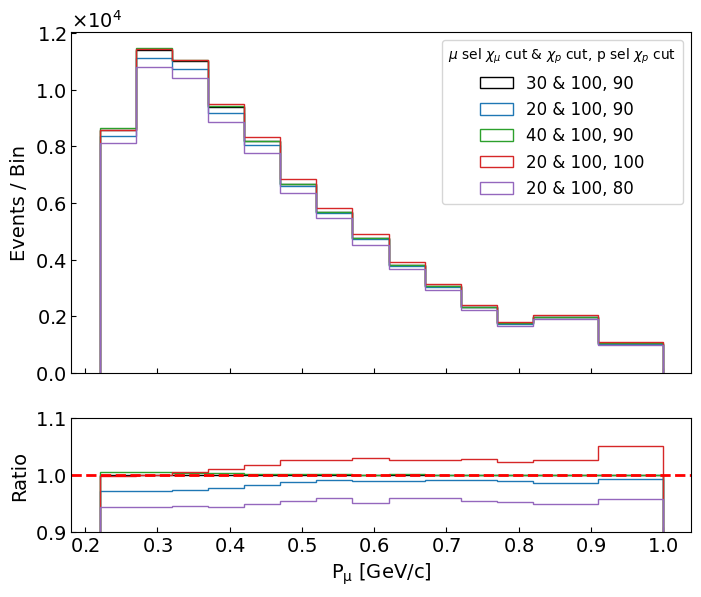

In [ ]:
var_config = VariableConfig.muon_momentum()
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True, gridspec_kw={"height_ratios": [3, 1]})
n_list = []
for i, k in enumerate(["30", "20", "40", "20_100", "20_80"]):
    this_df = df_detvar_dict[k]
    this_mu_df = df_detvar_dict[k+"_mu"]
    topo_categ = get_int_category(this_df)
    this_df_sig = this_df #[topo_categ==1]
    this_mu_df_sig = this_mu_df.reset_index(level=[3]).loc[this_df_sig.index]
    var = this_mu_df_sig.pfp.trk.rangeP.p_muon
    bins = var_config.bins
    n, _, _ = ax[0].hist(var, bins=bins, histtype="step", label=labels[i], color=colors[i])
    n_list.append(n)
ax[0].set_ylabel("Events / Bin")
ax[0].legend(fontsize=12,title="$\mu$ sel $\chi_{\mu}$ cut & $\chi_{p}$ cut, p sel $\chi_{p}$ cut")
n_list = np.array(n_list)

for i in range(len(n_list)):
    ratios = n_list[i] / n_list[0]
    ax[1].hist(var_config.bin_centers, bins=var_config.bins, weights=ratios, histtype="step", color=colors[i], label=labels[i])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0.9, 1.1)
ax[1].axhline(1, color="red", linestyle="--")
plt.show()

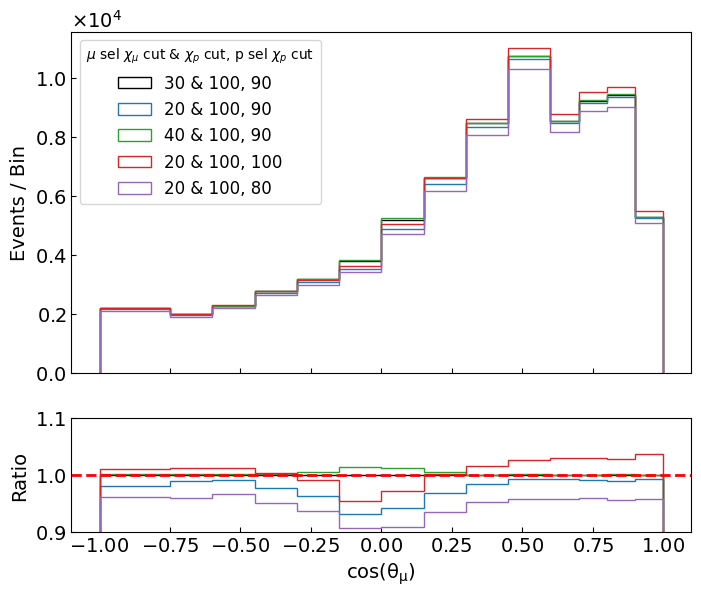

In [203]:
var_config = VariableConfig.muon_direction()
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True, gridspec_kw={"height_ratios": [3, 1]})
n_list = []
for i, k in enumerate(["30", "20", "40", "20_100", "20_80"]):
    this_df = df_detvar_dict[k]
    this_mu_df = df_detvar_dict[k+"_mu"]
    topo_categ = get_int_category(this_df)
    this_df_sig = this_df #[topo_categ==1]
    this_mu_df_sig = this_mu_df.reset_index(level=[3]).loc[this_df_sig.index]
    var = this_mu_df_sig.pfp.trk.dir.z
    bins = var_config.bins
    n, _ = np.histogram(var, bins=bins)
    n, _, _ = ax[0].hist(var_config.bin_centers, bins=bins, weights=n, histtype="step", label=labels[i], color=colors[i])
    n_list.append(n)
ax[0].set_ylabel("Events / Bin")
ax[0].legend(fontsize=12,title="$\mu$ sel $\chi_{\mu}$ cut & $\chi_{p}$ cut, p sel $\chi_{p}$ cut")
n_list = np.array(n_list)

for i in range(len(n_list)):
    ratios = n_list[i] / n_list[0]
    ax[1].hist(var_config.bin_centers, bins=var_config.bins, weights=ratios, histtype="step", color=colors[i], label=labels[i])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0.9, 1.1)
ax[1].axhline(1, color="red", linestyle="--")
plt.show()

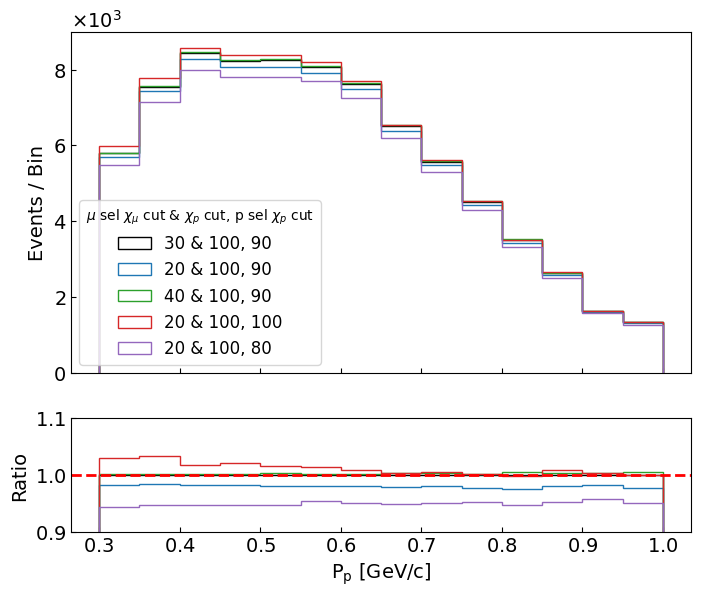

In [201]:
var_config = VariableConfig.proton_momentum()
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True, gridspec_kw={"height_ratios": [3, 1]})
n_list = []
for i, k in enumerate(["30", "20", "40", "20_100", "20_80"]):
    this_df = df_detvar_dict[k]
    this_p_df = df_detvar_dict[k+"_p"]
    topo_categ = get_int_category(this_df)
    this_df_sig = this_df #[topo_categ==1]
    this_p_df_sig = this_p_df.reset_index(level=[3]).loc[this_df_sig.index]
    var = this_p_df_sig.pfp.trk.rangeP.p_proton
    bins = var_config.bins
    n, _ = np.histogram(var, bins=bins)
    n, _, _ = ax[0].hist(var_config.bin_centers, bins=bins, weights=n, histtype="step", label=labels[i], color=colors[i])
    n_list.append(n)
ax[0].set_ylabel("Events / Bin")
ax[0].legend(fontsize=12,title="$\mu$ sel $\chi_{\mu}$ cut & $\chi_{p}$ cut, p sel $\chi_{p}$ cut")
n_list = np.array(n_list)

for i in range(len(n_list)):
    ratios = n_list[i] / n_list[0]
    ax[1].hist(var_config.bin_centers, bins=var_config.bins, weights=ratios, histtype="step", color=colors[i], label=labels[i])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0.9, 1.1)
ax[1].axhline(1, color="red", linestyle="--")
plt.show()

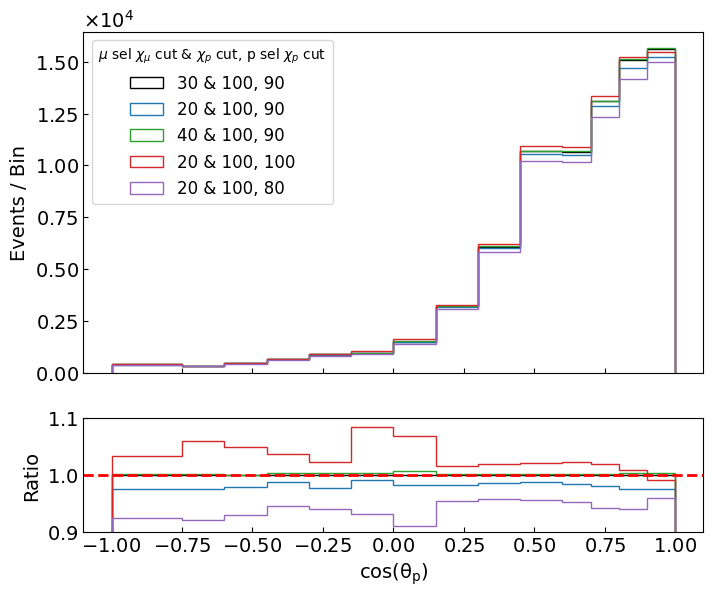

In [202]:
var_config = VariableConfig.proton_direction()
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True, gridspec_kw={"height_ratios": [3, 1]})
n_list = []
for i, k in enumerate(["30", "20", "40", "20_100", "20_80"]):
    this_df = df_detvar_dict[k]
    this_p_df = df_detvar_dict[k+"_p"]
    topo_categ = get_int_category(this_df)
    this_df_sig = this_df #[topo_categ==1]
    this_p_df_sig = this_p_df.reset_index(level=[3]).loc[this_df_sig.index]
    var = this_p_df_sig.pfp.trk.dir.z
    bins = var_config.bins
    n, _ = np.histogram(var, bins=bins)
    n, _, _ = ax[0].hist(var_config.bin_centers, bins=bins, weights=n, histtype="step", label=labels[i], color=colors[i])
    n_list.append(n)
ax[0].set_ylabel("Events / Bin")
ax[0].legend(fontsize=12,title="$\mu$ sel $\chi_{\mu}$ cut & $\chi_{p}$ cut, p sel $\chi_{p}$ cut")
n_list = np.array(n_list)

for i in range(len(n_list)):
    ratios = n_list[i] / n_list[0]
    ax[1].hist(var_config.bin_centers, bins=var_config.bins, weights=ratios, histtype="step", color=colors[i], label=labels[i])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0.9, 1.1)
ax[1].axhline(1, color="red", linestyle="--")
plt.show()



/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site

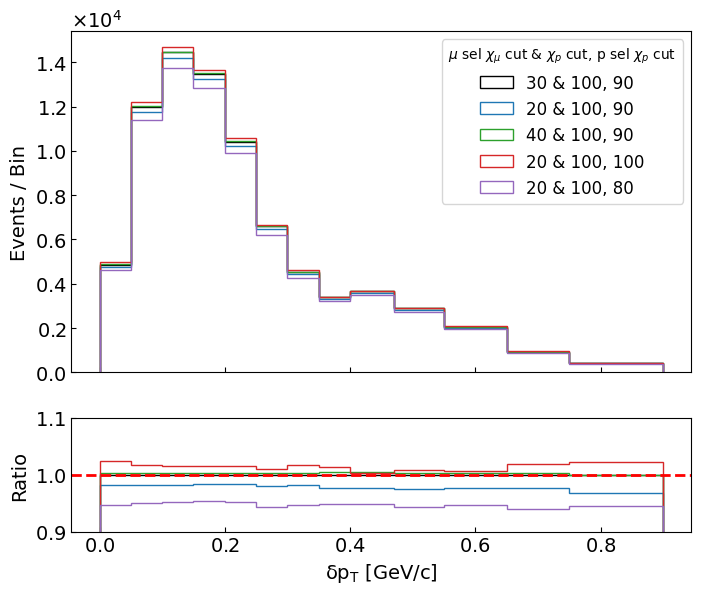

In [206]:
var_config = VariableConfig.tki_del_Tp()
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True, gridspec_kw={"height_ratios": [3, 1]})
n_list = []
for i, k in enumerate(["30", "20", "40", "20_100", "20_80"]):
    this_df = df_detvar_dict[k]
    this_p_df = df_detvar_dict[k+"_p"]
    this_mu_df = df_detvar_dict[k+"_mu"]
    mudf = this_mu_df.reset_index(level=[3])
    pdf = this_p_df.reset_index(level=[3])
    P_mu_col = pad_column_name(("rangeP", "p_muon"), mudf.pfp.trk)
    P_p_col = pad_column_name(("rangeP", "p_proton"), pdf.pfp.trk)
    ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

    topo_categ = get_int_category(this_df)
    this_df_sig = this_df #[topo_categ==1]
    this_p_df_sig = this_p_df.reset_index(level=[3]).loc[this_df_sig.index]
    var = ret_tki["del_Tp"]
    bins = var_config.bins
    n, _ = np.histogram(var, bins=bins)
    n, _, _ = ax[0].hist(var_config.bin_centers, bins=bins, weights=n, histtype="step", label=labels[i], color=colors[i])
    n_list.append(n)
ax[0].set_ylabel("Events / Bin")
ax[0].legend(fontsize=12,title="$\mu$ sel $\chi_{\mu}$ cut & $\chi_{p}$ cut, p sel $\chi_{p}$ cut")
n_list = np.array(n_list)

for i in range(len(n_list)):
    ratios = n_list[i] / n_list[0]
    ax[1].hist(var_config.bin_centers, bins=var_config.bins, weights=ratios, histtype="step", color=colors[i], label=labels[i])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0.9, 1.1)
ax[1].axhline(1, color="red", linestyle="--")
plt.show()

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site

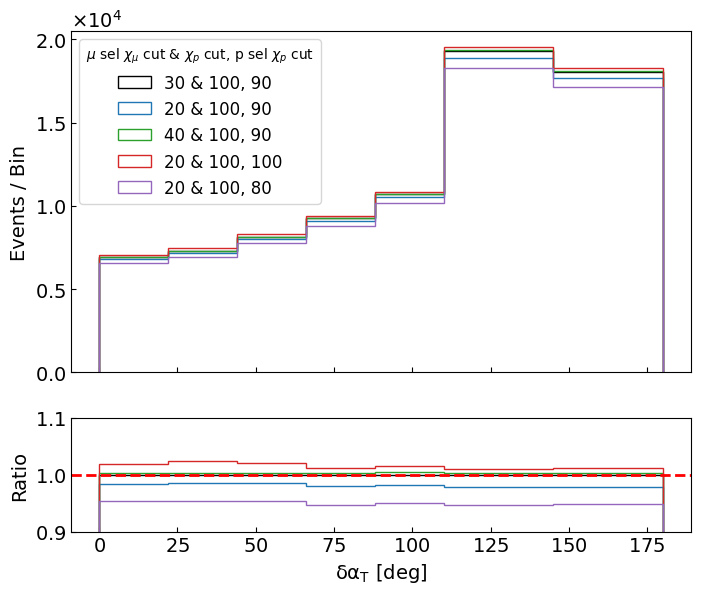

In [207]:
var_config = VariableConfig.tki_del_alpha()
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True, gridspec_kw={"height_ratios": [3, 1]})
n_list = []
for i, k in enumerate(["30", "20", "40", "20_100", "20_80"]):
    this_df = df_detvar_dict[k]
    this_p_df = df_detvar_dict[k+"_p"]
    this_mu_df = df_detvar_dict[k+"_mu"]
    mudf = this_mu_df.reset_index(level=[3])
    pdf = this_p_df.reset_index(level=[3])
    P_mu_col = pad_column_name(("rangeP", "p_muon"), mudf.pfp.trk)
    P_p_col = pad_column_name(("rangeP", "p_proton"), pdf.pfp.trk)
    ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

    topo_categ = get_int_category(this_df)
    this_df_sig = this_df #[topo_categ==1]
    this_p_df_sig = this_p_df.reset_index(level=[3]).loc[this_df_sig.index]
    var = ret_tki["del_alpha"]
    bins = var_config.bins
    n, _ = np.histogram(var, bins=bins)
    n, _, _ = ax[0].hist(var_config.bin_centers, bins=bins, weights=n, histtype="step", label=labels[i], color=colors[i])
    n_list.append(n)
ax[0].set_ylabel("Events / Bin")
ax[0].legend(fontsize=12,title="$\mu$ sel $\chi_{\mu}$ cut & $\chi_{p}$ cut, p sel $\chi_{p}$ cut")
n_list = np.array(n_list)

for i in range(len(n_list)):
    ratios = n_list[i] / n_list[0]
    ax[1].hist(var_config.bin_centers, bins=var_config.bins, weights=ratios, histtype="step", color=colors[i], label=labels[i])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0.9, 1.1)
ax[1].axhline(1, color="red", linestyle="--")
plt.show()

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site

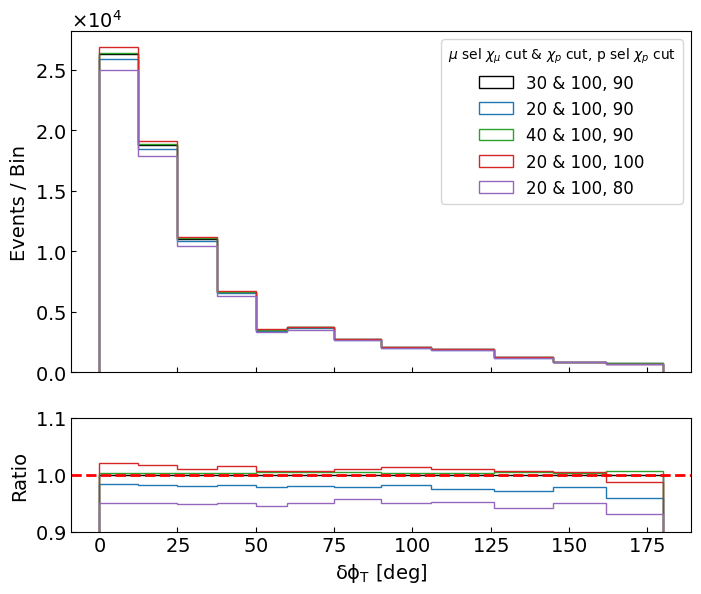

In [208]:
var_config = VariableConfig.tki_del_phi()
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True, gridspec_kw={"height_ratios": [3, 1]})
n_list = []
for i, k in enumerate(["30", "20", "40", "20_100", "20_80"]):
    this_df = df_detvar_dict[k]
    this_p_df = df_detvar_dict[k+"_p"]
    this_mu_df = df_detvar_dict[k+"_mu"]
    mudf = this_mu_df.reset_index(level=[3])
    pdf = this_p_df.reset_index(level=[3])
    P_mu_col = pad_column_name(("rangeP", "p_muon"), mudf.pfp.trk)
    P_p_col = pad_column_name(("rangeP", "p_proton"), pdf.pfp.trk)
    ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

    topo_categ = get_int_category(this_df)
    this_df_sig = this_df #[topo_categ==1]
    this_p_df_sig = this_p_df.reset_index(level=[3]).loc[this_df_sig.index]
    var = ret_tki["del_phi"]
    bins = var_config.bins
    n, _ = np.histogram(var, bins=bins)
    n, _, _ = ax[0].hist(var_config.bin_centers, bins=bins, weights=n, histtype="step", label=labels[i], color=colors[i])
    n_list.append(n)
ax[0].set_ylabel("Events / Bin")
ax[0].legend(fontsize=12,title="$\mu$ sel $\chi_{\mu}$ cut & $\chi_{p}$ cut, p sel $\chi_{p}$ cut")
n_list = np.array(n_list)

for i in range(len(n_list)):
    ratios = n_list[i] / n_list[0]
    ax[1].hist(var_config.bin_centers, bins=var_config.bins, weights=ratios, histtype="step", color=colors[i], label=labels[i])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0.9, 1.1)
ax[1].axhline(1, color="red", linestyle="--")
plt.show()

## Efficiency

/tmp/ipykernel_2517148/2459731404.py:17: RuntimeWarning: invalid value encountered in divide
  eff = n_postcut / n_precut
/tmp/ipykernel_2517148/2459731404.py:18: RuntimeWarning: invalid value encountered in divide
  eff_prepcut = n_postcut_prepcut / n_precut
/tmp/ipykernel_2517148/2459731404.py:19: RuntimeWarning: invalid value encountered in divide
  pur = n_postcut / n_postcut_all


threshold:  0.22499999999999998


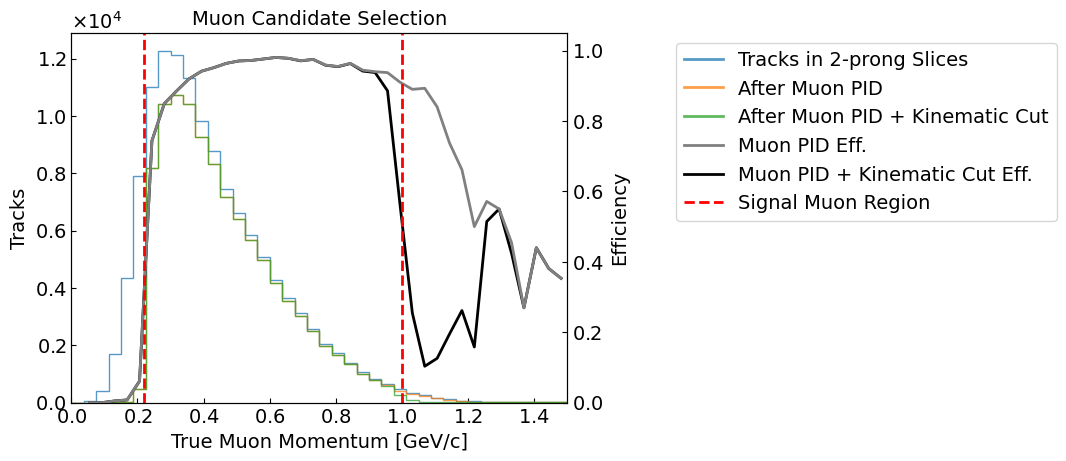

---- muon candidate selection ----
integrated efficiency: 0.81
integrated purity: 0.94
threshold:  0.3


/tmp/ipykernel_2517148/2459731404.py:69: RuntimeWarning: invalid value encountered in divide
  eff = n_postcut / n_precut
/tmp/ipykernel_2517148/2459731404.py:70: RuntimeWarning: invalid value encountered in divide
  eff_prepcut = n_postcut_prepcut / n_precut
/tmp/ipykernel_2517148/2459731404.py:71: RuntimeWarning: invalid value encountered in divide
  pur = n_postcut / n_postcut_all


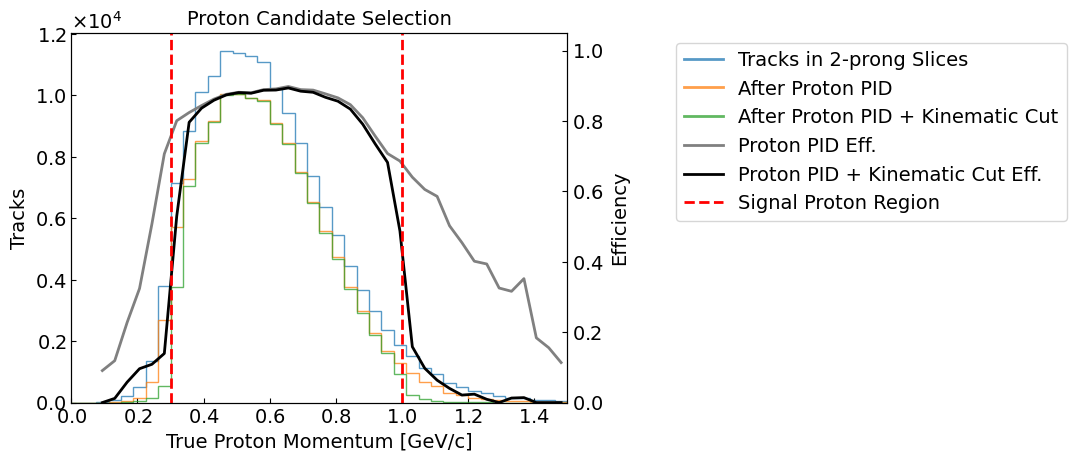

---- proton candidate selection ----
integrated efficiency: 0.78
integrated purity: 0.99
threshold:  0.275


/tmp/ipykernel_2517148/2459731404.py:119: RuntimeWarning: invalid value encountered in divide
  eff = n_postcut / n_precut
/tmp/ipykernel_2517148/2459731404.py:120: RuntimeWarning: invalid value encountered in divide
  pur = n_postcut / n_postcut_all


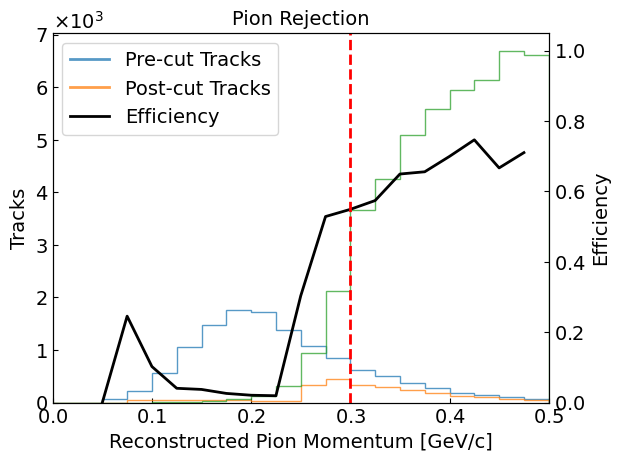

---- pion rejection ----
integrated efficiency: 0.20
integrated purity: 0.01


In [75]:
fig, ax = plt.subplots()
# var_name = ("pfp", "trk", "rangeP", "p_muon")
var_name = ("pfp", "trk", "truth", "p", "totp")
bins = np.linspace(0, 1.5, 41)
var_precut = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 13][var_name]
var_postcut_prepcut = mc_mu_candidate_nopcut[mc_mu_candidate_nopcut.pfp.trk.truth.p.pdg == 13][var_name]
var_postcut = mc_mu_candidate[mc_mu_candidate.pfp.trk.truth.p.pdg == 13][var_name]
var_postcut_all = mc_mu_candidate[var_name]
n_precut, _, _ = ax.hist(var_precut, bins=bins, histtype="step", alpha=0.75)
n_postcut_prepcut, _, _ = ax.hist(var_postcut_prepcut, bins=bins, histtype="step", alpha=0.75)
n_postcut, _, _ = ax.hist(var_postcut, bins=bins, histtype="step", alpha=0.75)
n_postcut_all, _ = np.histogram(var_postcut_all, bins=bins)
ax.set_xlabel("True Muon Momentum [GeV/c]")
ax.set_ylabel("Tracks")

ax_eff = ax.twinx()
eff = n_postcut / n_precut
eff_prepcut = n_postcut_prepcut / n_precut
pur = n_postcut / n_postcut_all
bin_centers = (bins[:-1] + bins[1:])/2
ax_eff.plot(bin_centers, eff, color="k")
ax_eff.plot(bin_centers, eff_prepcut, color="gray")
eff_threshold = bins[np.where(eff > 0.5)[0][0]]
print("threshold: ", eff_threshold)
ax_eff.axvline(0.22, color="red", linestyle="--")
ax_eff.axvline(1, color="red", linestyle="--")
# ax_eff.text(eff_threshold, 0.5, "50% Threshold={:.2f}".format(eff_threshold), color="red", fontsize=12)

ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)
plt.xlim(bins[0], bins[-1])

# legend using dummies
plt.plot([], [], label="Tracks in 2-prong Slices", alpha=0.75, color="C0")
plt.plot([], [], label="After Muon PID", alpha=0.75, color="C1")
plt.plot([], [], label="After Muon PID + Kinematic Cut", alpha=0.75, color="C2")
plt.plot([], [], label="Muon PID Eff.", color="gray")
plt.plot([], [], label="Muon PID + Kinematic Cut Eff.", color="k")
plt.plot([], [], label="Signal Muon Region", color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')
plt.title("Muon Candidate Selection")


save_name = save_fig_dir + "/muon_candidate_selection_eff.png"
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

print("---- muon candidate selection ----")
print("integrated efficiency: {:.2f}".format(n_postcut.sum() / n_precut.sum()))
print("integrated purity: {:.2f}".format(n_postcut.sum() / len(mc_mu_candidate)))


fig, ax = plt.subplots()
# var_name = ("pfp", "trk", "rangeP", "p_proton")
var_name = ("pfp", "trk", "truth", "p", "totp")
var_precut = mc_trk_df_2prong[mc_trk_df_2prong.pfp.trk.truth.p.pdg == 2212][var_name]
var_postcut_prepcut = mc_p_candidates_nopcut[mc_p_candidates_nopcut.pfp.trk.truth.p.pdg == 2212][var_name]
var_postcut = mc_p_candidates[mc_p_candidates.pfp.trk.truth.p.pdg == 2212][var_name]
var_postcut_all = mc_p_candidates[var_name]
n_precut, _, _ = ax.hist(var_precut, bins=bins, histtype="step", alpha=0.75)
n_postcut_prepcut, _, _ = ax.hist(var_postcut_prepcut, bins=bins, histtype="step", alpha=0.75)
n_postcut, _, _ = ax.hist(var_postcut, bins=bins, histtype="step", alpha=0.75)
n_postcut_all, _ = np.histogram(var_postcut_all, bins=bins)
ax.set_xlabel("True Proton Momentum [GeV/c]")
ax.set_ylabel("Tracks")

ax_eff = ax.twinx()
eff = n_postcut / n_precut
eff_prepcut = n_postcut_prepcut / n_precut
pur = n_postcut / n_postcut_all
bin_centers = (bins[:-1] + bins[1:])/2
ax_eff.plot(bin_centers, eff_prepcut, color="gray")
ax_eff.plot(bin_centers, eff, color="k")
eff_threshold = bins[np.where(eff > 0.5)[0][0]]
print("threshold: ", eff_threshold)
ax_eff.axvline(0.3, color="red", linestyle="--")
ax_eff.axvline(1, color="red", linestyle="--")

ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

plt.xlim(bins[0], bins[-1])

# legend using dummies
plt.plot([], [], label="Tracks in 2-prong Slices", alpha=0.75, color="C0")
plt.plot([], [], label="After Proton PID", alpha=0.75, color="C1")
plt.plot([], [], label="After Proton PID + Kinematic Cut", alpha=0.75, color="C2")
plt.plot([], [], label="Proton PID Eff.", color="gray")
plt.plot([], [], label="Proton PID + Kinematic Cut Eff.", color="k")
plt.plot([], [], label="Signal Proton Region", color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')
plt.title("Proton Candidate Selection")

save_name = save_fig_dir + "/proton_candidate_selection_eff.png"
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

print("---- proton candidate selection ----")
print("integrated efficiency: {:.2f}".format(n_postcut.sum() / n_precut.sum()))
print("integrated purity: {:.2f}".format(n_postcut.sum() / len(mc_p_candidates)))

fig, ax = plt.subplots()
var_name = ("pfp", "trk", "rangeP", "p_pion")
bins = np.linspace(0, 0.5, 21)
var_precut = mc_trk_df_2prong[np.abs(mc_trk_df_2prong.pfp.trk.truth.p.pdg) == 211][var_name]
both_candidates = pd.concat([mc_p_candidates, mc_mu_candidate])
var_postcut = both_candidates[np.abs(both_candidates.pfp.trk.truth.p.pdg) == 211][var_name]
var_postcut_all = both_candidates[var_name]
n_precut, _, _ = ax.hist(var_precut, bins=bins, histtype="step", alpha=0.75)
n_postcut, _, _ = ax.hist(var_postcut, bins=bins, histtype="step", alpha=0.75)
n_postcut_prepcut, _, _ = ax.hist(var_postcut_prepcut, bins=bins, histtype="step", alpha=0.75)
n_postcut_all, _ = np.histogram(var_postcut_all, bins=bins)
ax.set_xlabel("Reconstructed Pion Momentum [GeV/c]")
ax.set_ylabel("Tracks")

ax_eff = ax.twinx()
eff = n_postcut / n_precut
pur = n_postcut / n_postcut_all
ax_eff.plot(bins[:-1], eff, color="k")
# ax_eff.plot(bins[:-1], pur, color="gray", linestyle="--")
eff_threshold = bins[np.where(eff > 0.5)[0][0]]
# ax_eff.axhline(0.5, color="red", linestyle="--")
# ax_eff.text(eff_threshold, 0.5, "Efficiency > 0.5", color="red", fontsize=12)
print("threshold: ", eff_threshold)
ax_eff.axvline(0.3, color="red", linestyle="--")
ax_eff.axvline(1, color="red", linestyle="--")
# ax_eff.text(eff_threshold, 0.5, "50% Threshold={:.2f}".format(eff_threshold), color="red", fontsize=12)

ax_eff.set_ylabel("Efficiency")
ax_eff.set_ylim(0, 1.05)

plt.xlim(bins[0], bins[-1])

# legend using dummies
plt.plot([], [], label="Pre-cut Tracks", alpha=0.75, color="C0")
plt.plot([], [], label="Post-cut Tracks", alpha=0.75, color="C1")
plt.plot([], [], label="Efficiency", color="k")
plt.legend()
plt.title("Pion Rejection")

save_name = save_fig_dir + "/pion_rejection_eff.png"
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

print("---- pion rejection ----")
print("integrated efficiency: {:.2f}".format(n_postcut.sum() / n_precut.sum()))
print("integrated purity: {:.2f}".format(n_postcut.sum() / len(both_candidates)))

In [76]:
eps = 1e-8

## data vs. MC of measurement variables

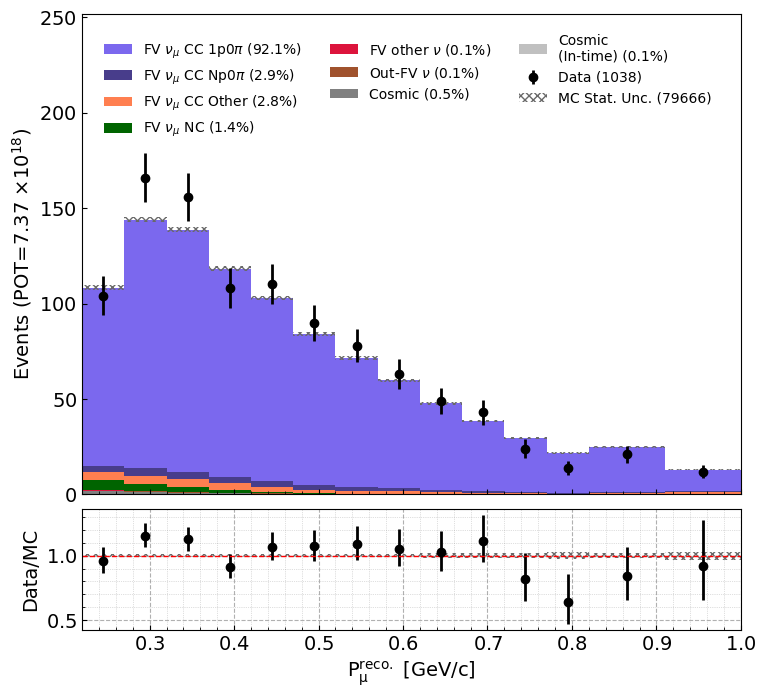

numu NC 1122


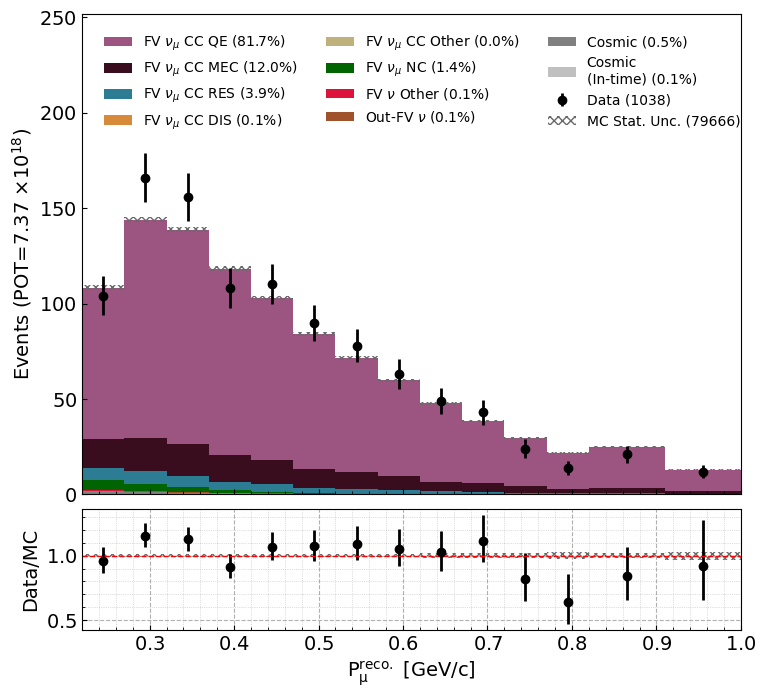

numu NC 1122


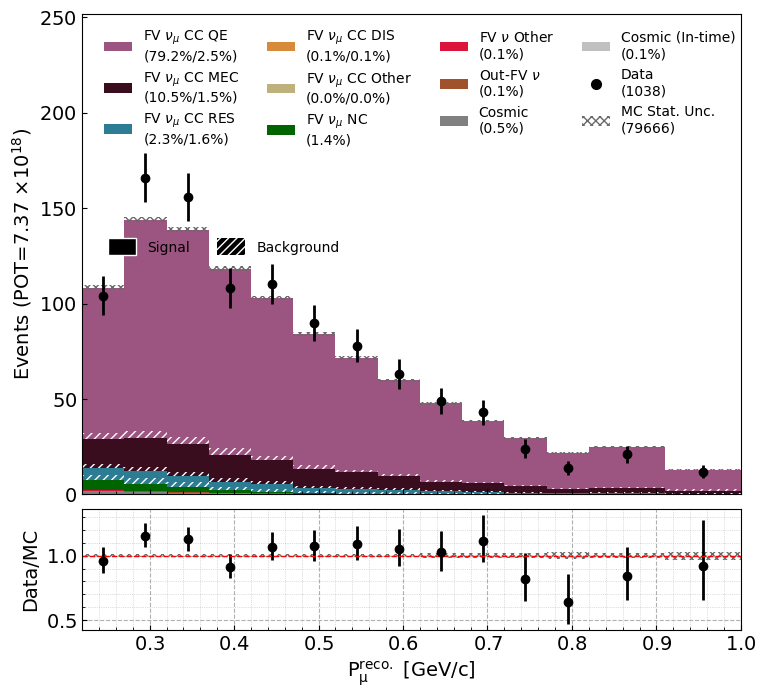

In [40]:
# muon momentum 
var_config = VariableConfig.muon_momentum()
evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.rangeP.p_muon
vardf_data = data_mu_df.pfp.trk.rangeP.p_muon
vardf_intime = intime_mu_df.pfp.trk.rangeP.p_muon
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)

# plot
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

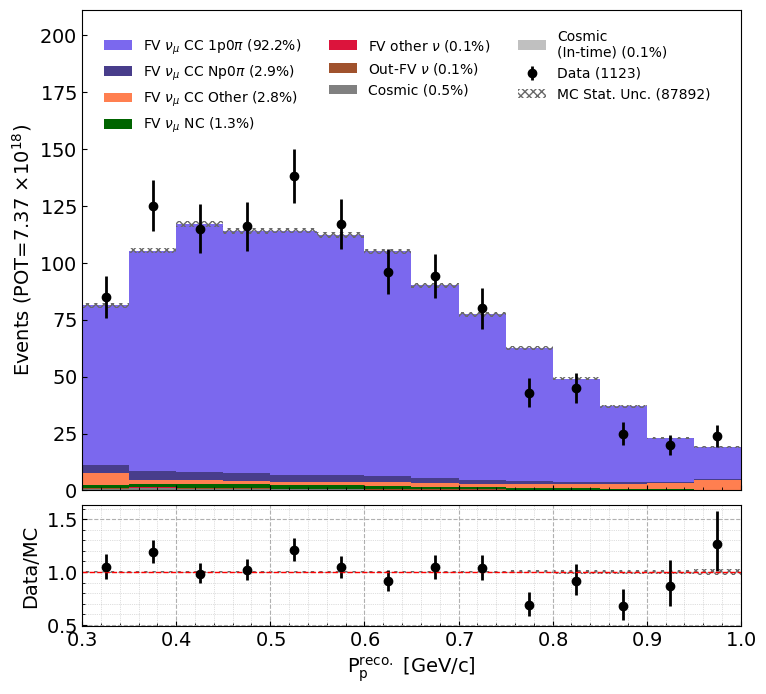

numu NC 1174


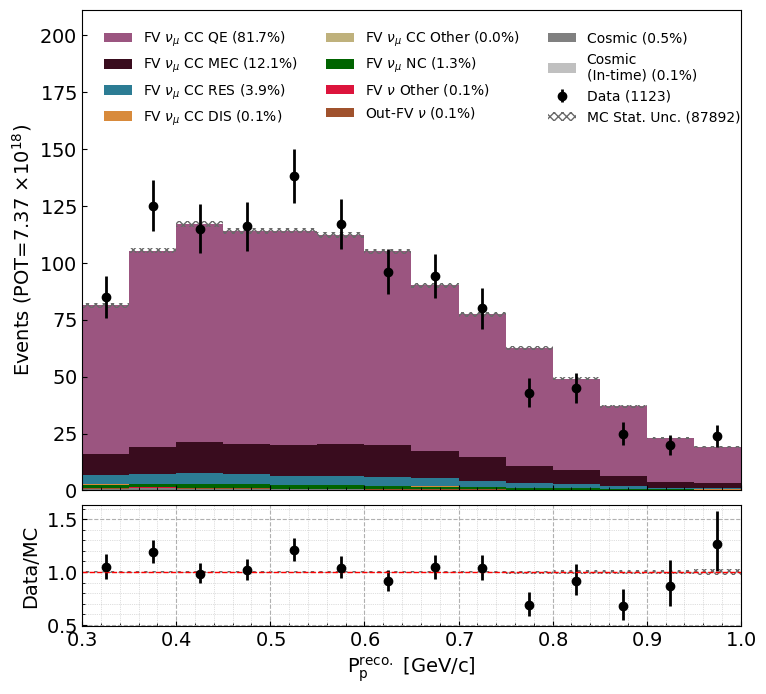

numu NC 1174


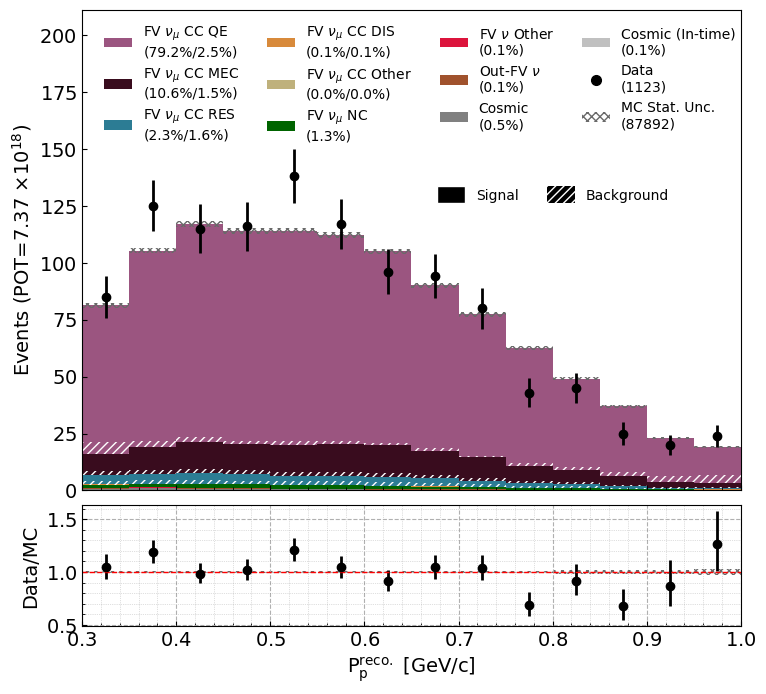

In [138]:
# proton momentum 
var_config = VariableConfig.proton_momentum()
evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.rangeP.p_proton
vardf_data = data_p_df.pfp.trk.rangeP.p_proton
vardf_intime = intime_p_df.pfp.trk.rangeP.p_proton
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

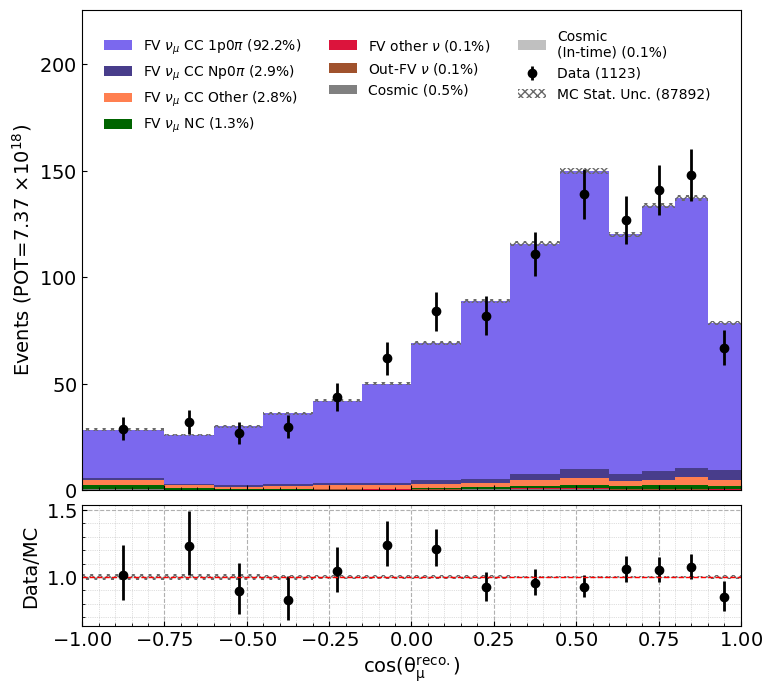

numu NC 1174


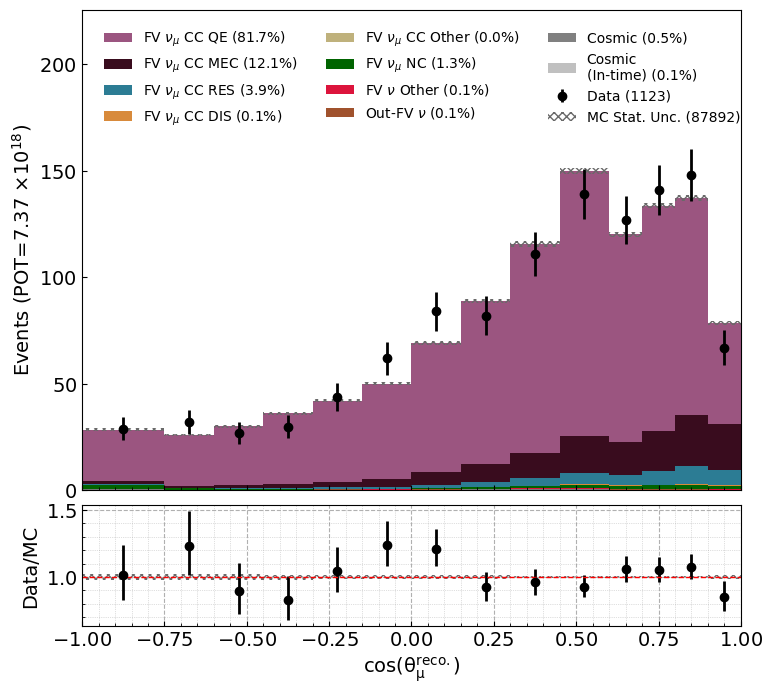

numu NC 1174


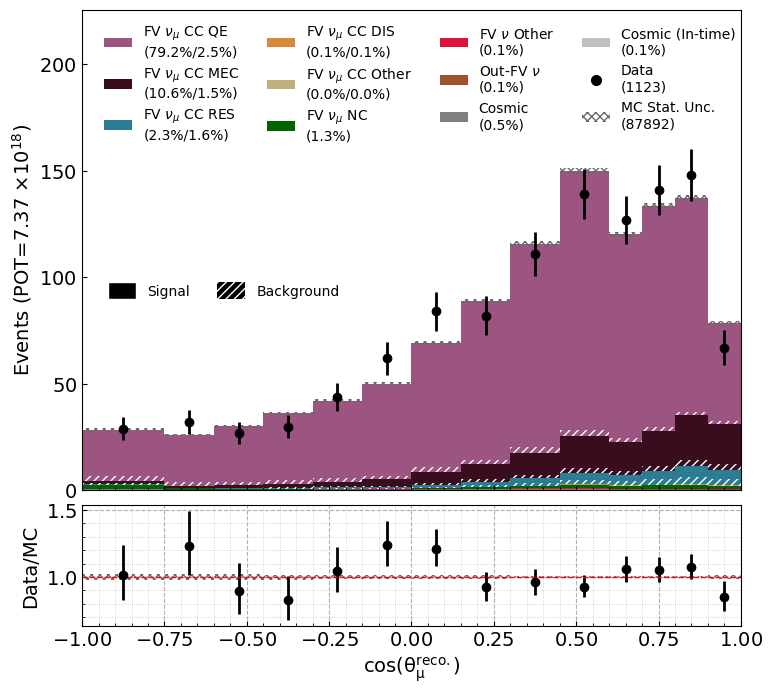

In [146]:
# Muon z-direction
var_config = VariableConfig.muon_direction()
evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.dir.z
vardf_data = data_mu_df.pfp.trk.dir.z
vardf_intime = intime_mu_df.pfp.trk.dir.z
bins = var_config.bins
vardf = np.clip(vardf, var_config.bins[0], var_config.bins[-1] - eps)
vardf_data = np.clip(vardf_data, var_config.bins[0], var_config.bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

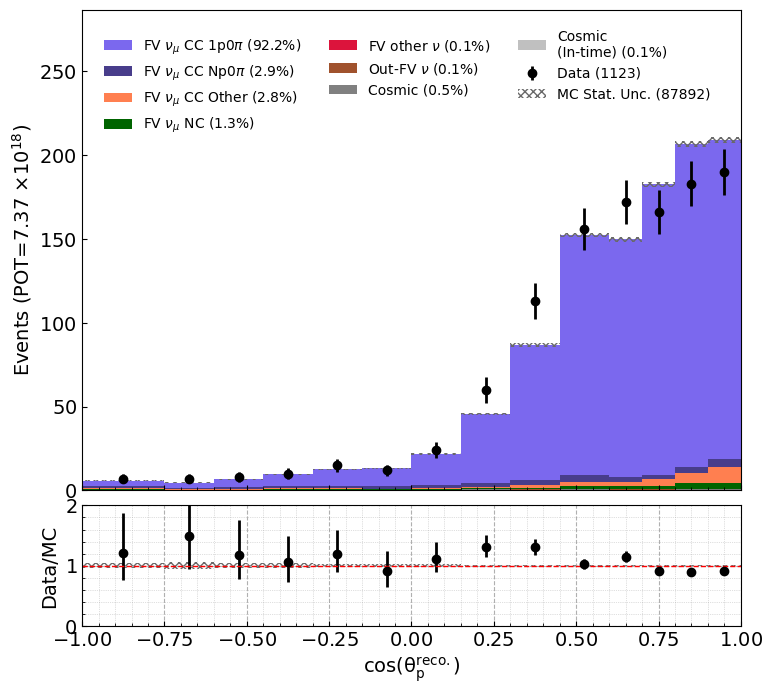

numu NC 1174


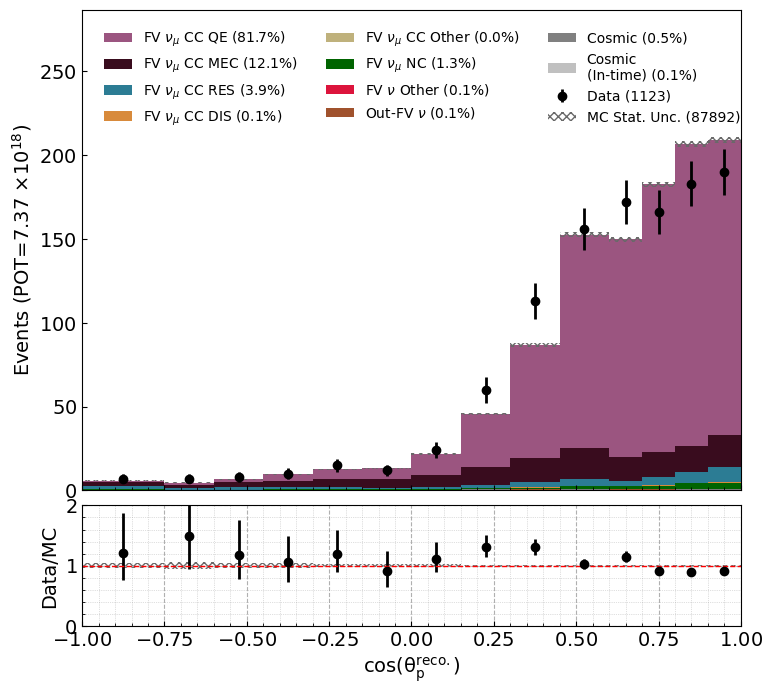

numu NC 1174


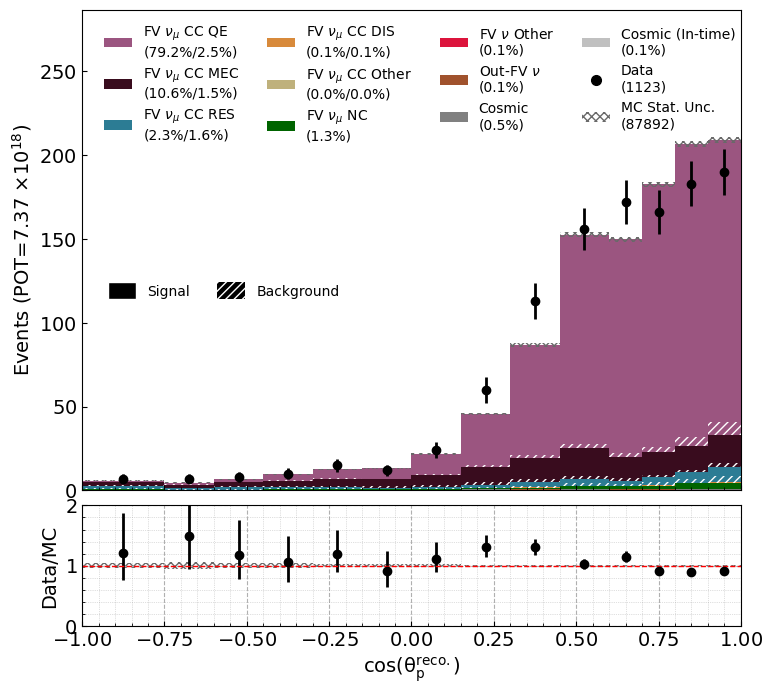

In [147]:
# proton z-direction
var_config = VariableConfig.proton_direction()
evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.dir.z
vardf_data = data_p_df.pfp.trk.dir.z
vardf_intime = intime_p_df.pfp.trk.dir.z
bins = var_config.bins
vardf = np.clip(vardf, var_config.bins[0], var_config.bins[-1] - eps)
vardf_data = np.clip(vardf_data, var_config.bins[0], var_config.bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = [var_config.var_labels[1], 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/{}_{}.png".format(var_config.var_save_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

In [205]:
from pyanalib.pandas_helpers import pad_column_name
from pyanalib.variable_calculator import get_cc1p0pi_tki

mudf = mc_mu_df.reset_index(level=[3])
pdf = mc_p_df.reset_index(level=[3])
P_mu_col = pad_column_name(("rangeP", "p_muon"), mudf.pfp.trk)
P_p_col = pad_column_name(("rangeP", "p_proton"), pdf.pfp.trk)
mc_ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

mudf = data_mu_df.reset_index(level=[3])
pdf = data_p_df.reset_index(level=[3])
data_ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

mudf = intime_mu_df.reset_index(level=[3])
pdf = intime_p_df.reset_index(level=[3])
intime_ret_tki = get_cc1p0pi_tki(mudf.pfp.trk, pdf.pfp.trk, P_mu_col, P_p_col)

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
mc_evt_df_mup["del_Tp_x"] = mc_ret_tki["del_Tp_x"]
mc_evt_df_mup["del_Tp_y"] = mc_ret_tki["del_Tp_y"]
mc_evt_df_mup["del_Tp"] = mc_ret_tki["del_Tp"]
mc_evt_df_mup["del_p"] = mc_ret_tki["del_p"]
mc_evt_df_mup["del_alpha"] = mc_ret_tki["del_alpha"]
mc_evt_df_mup["del_phi"] = mc_ret_tki["del_phi"]

data_evt_df_mup["del_Tp_x"] = data_ret_tki["del_Tp_x"]
data_evt_df_mup["del_Tp_y"] = data_ret_tki["del_Tp_y"]
data_evt_df_mup["del_Tp"] = data_ret_tki["del_Tp"]
data_evt_df_mup["del_p"] = data_ret_tki["del_p"]
data_evt_df_mup["del_alpha"] = data_ret_tki["del_alpha"]
data_evt_df_mup["del_phi"] = data_ret_tki["del_phi"]

intime_evt_df_mup["del_Tp_x"] = intime_ret_tki["del_Tp_x"]
intime_evt_df_mup["del_Tp_y"] = intime_ret_tki["del_Tp_y"]
intime_evt_df_mup["del_Tp"] = intime_ret_tki["del_Tp"]
intime_evt_df_mup["del_p"] = intime_ret_tki["del_p"]
intime_evt_df_mup["del_alpha"] = intime_ret_tki["del_alpha"]
intime_evt_df_mup["del_phi"] = intime_ret_tki["del_phi"]

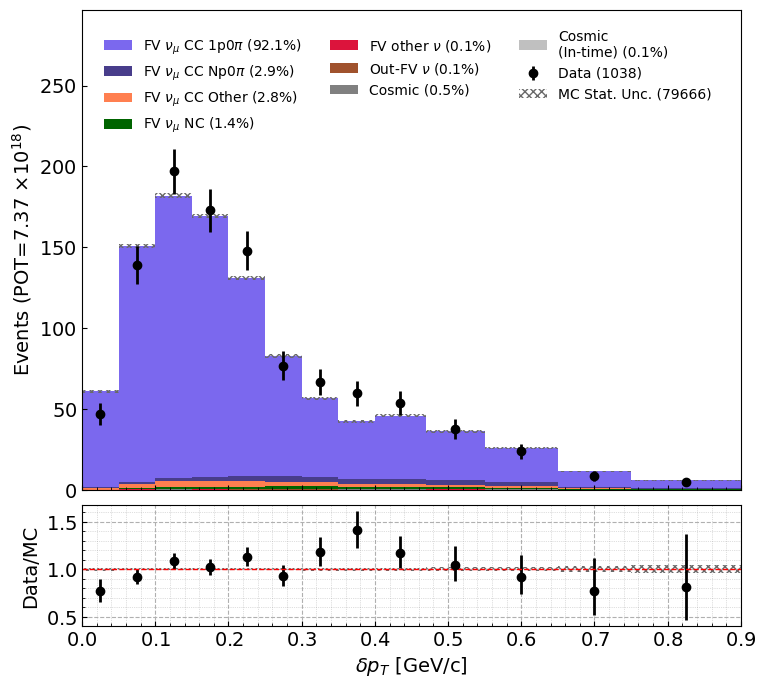

numu NC 1122


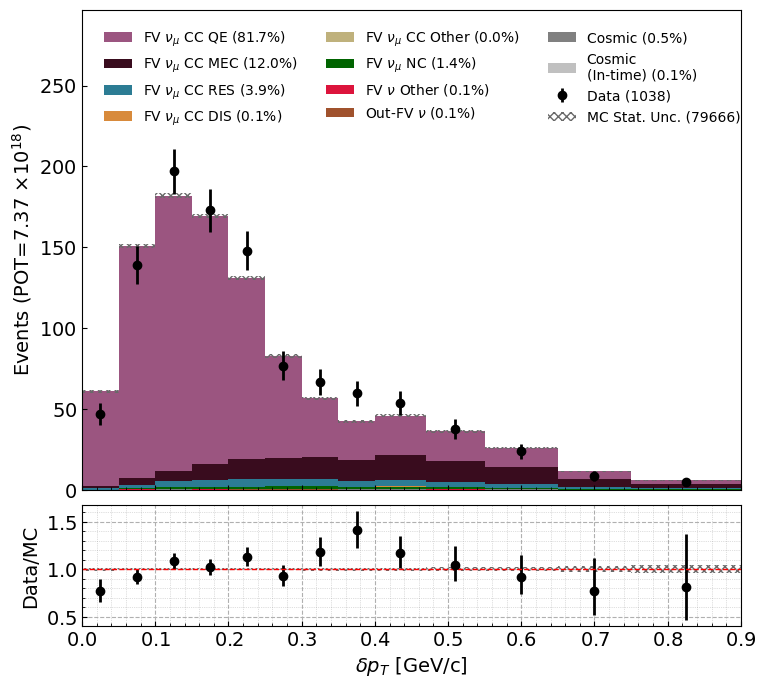

numu NC 1122


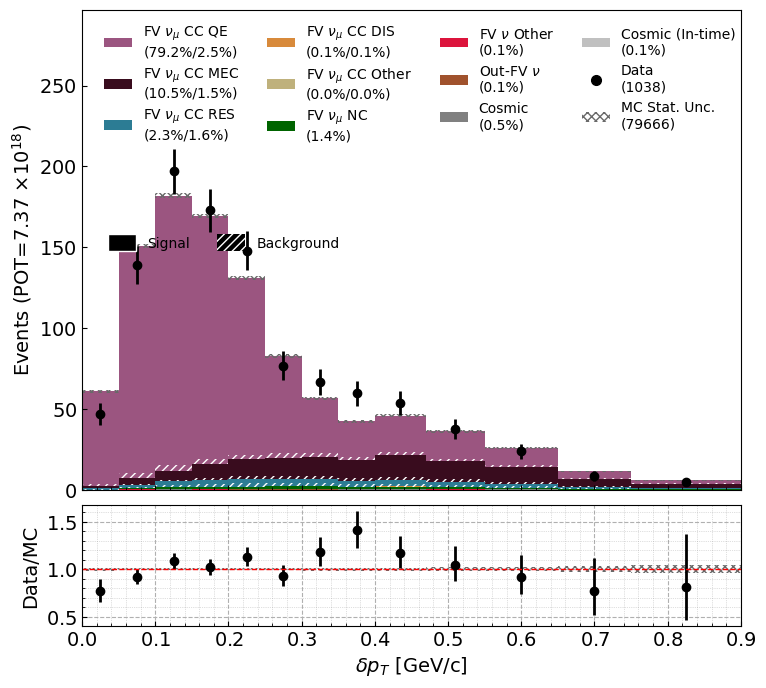

In [43]:
evtdf = mc_evt_df_mup
tki_name = "del_Tp"
var_config = VariableConfig.tki_del_Tp()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_T$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

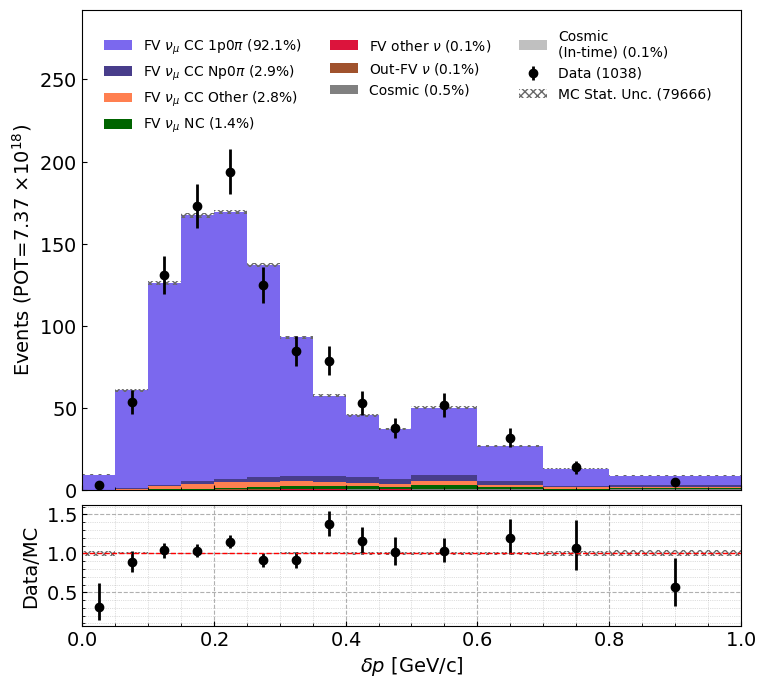

numu NC 1122


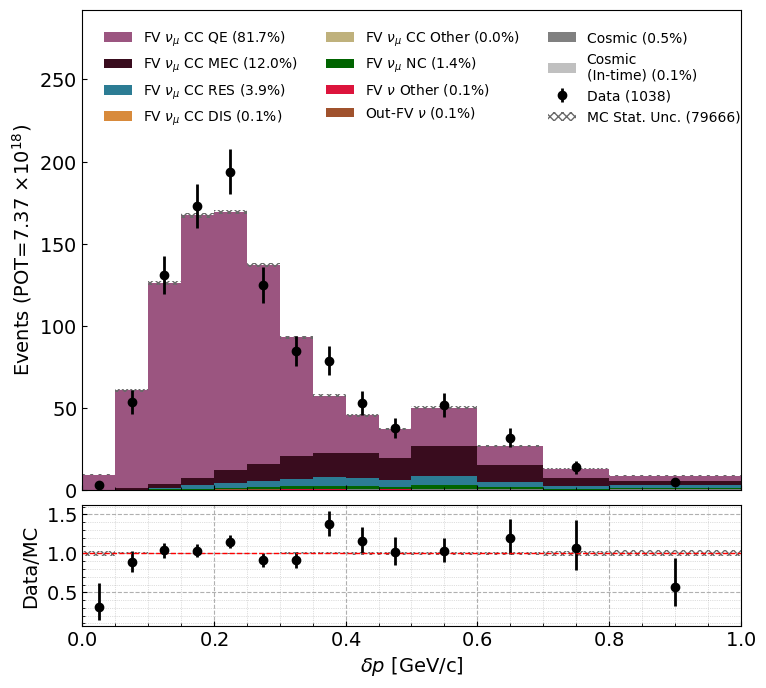

numu NC 1122


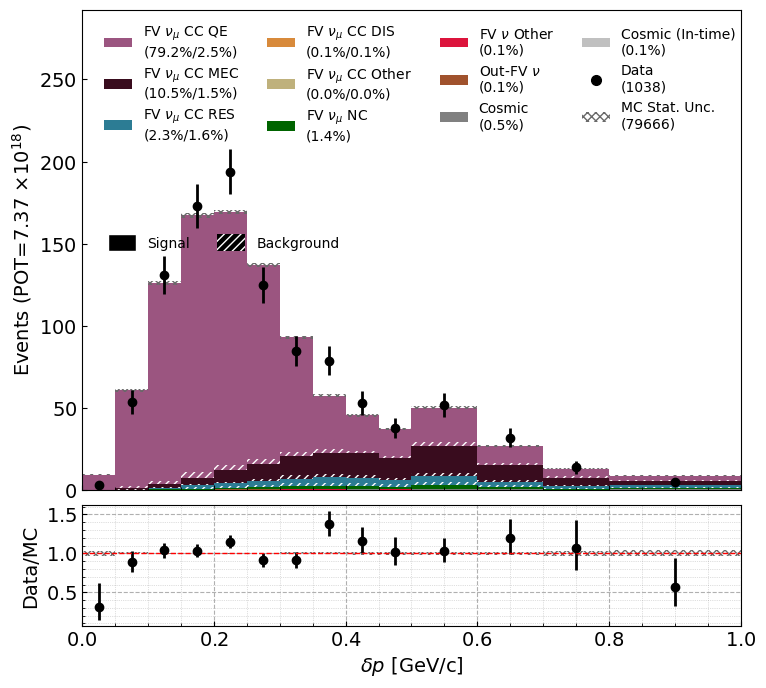

In [44]:
# Muon z-direction
evtdf = mc_evt_df_mup
tki_name = "del_p"
var_config = VariableConfig.tki_del_p()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-del_p_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-del_p_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-del_p_{}.png".format(plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

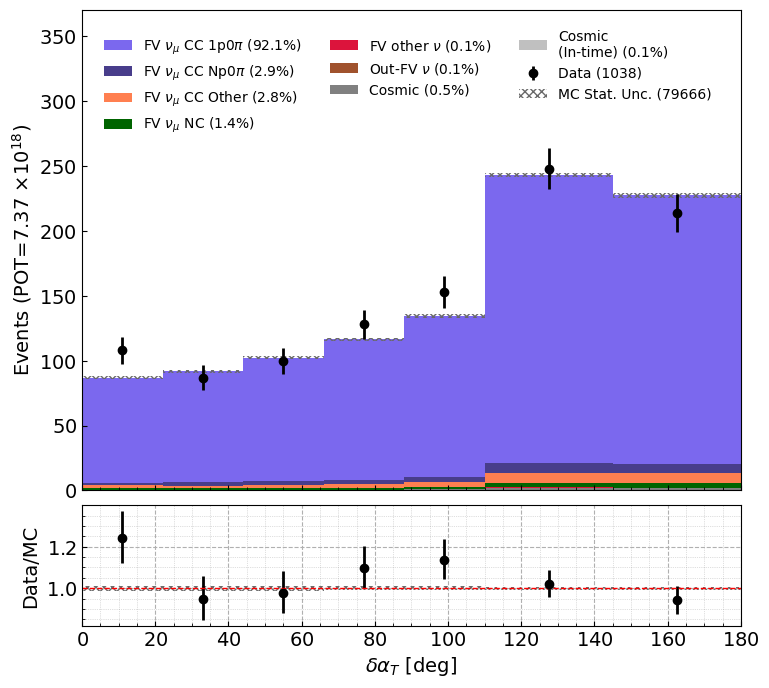

numu NC 1122


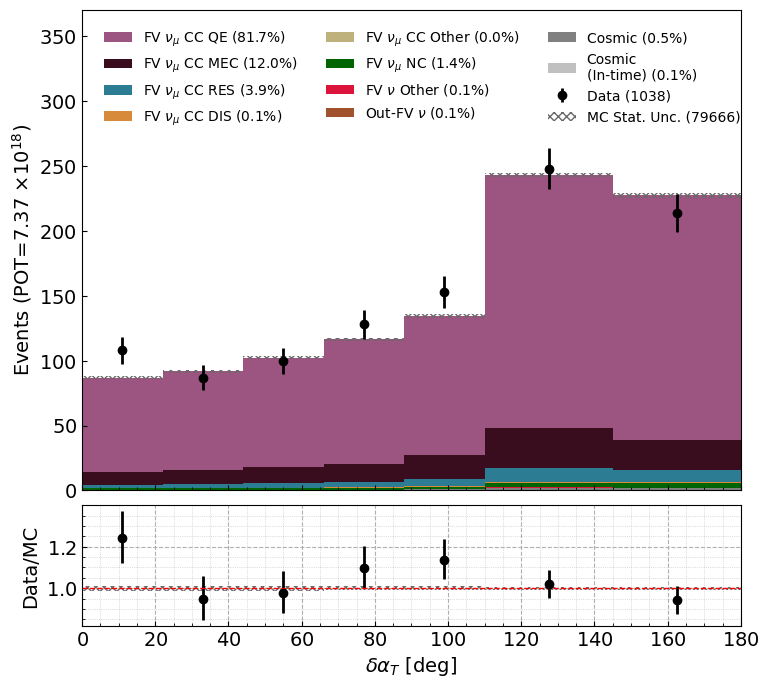

numu NC 1122


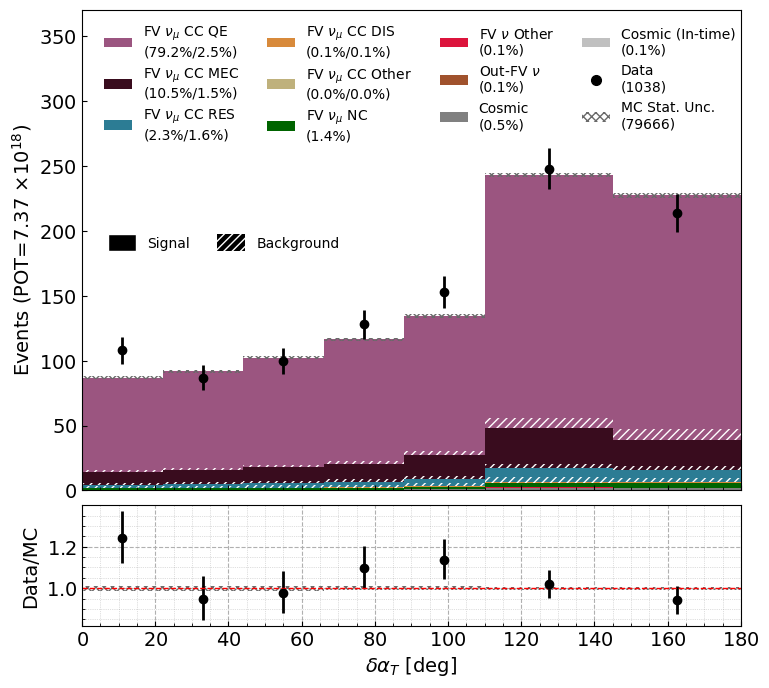

In [45]:
# Muon z-direction
evtdf = mc_evt_df_mup
tki_name = "del_alpha"
var_config = VariableConfig.tki_del_alpha()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta \alpha_T$ [deg]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

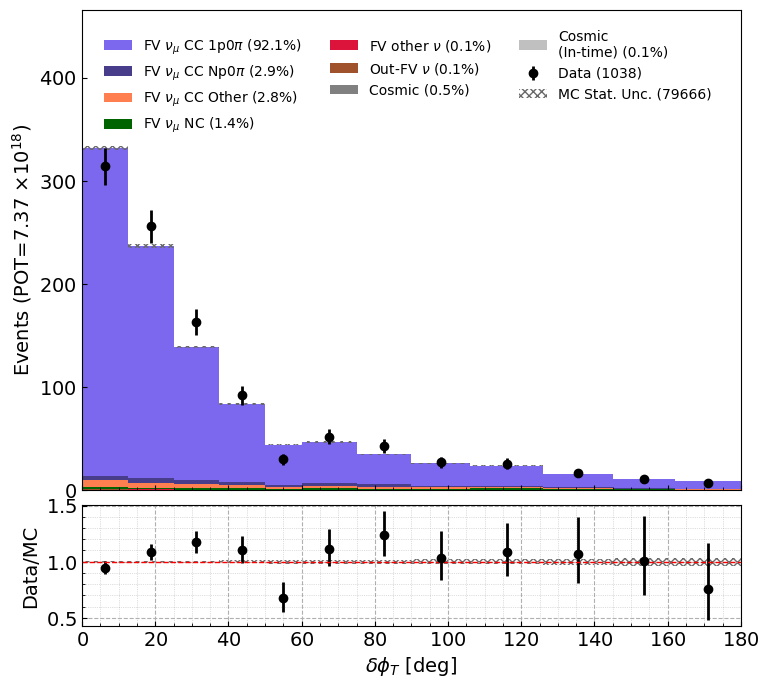

numu NC 1122


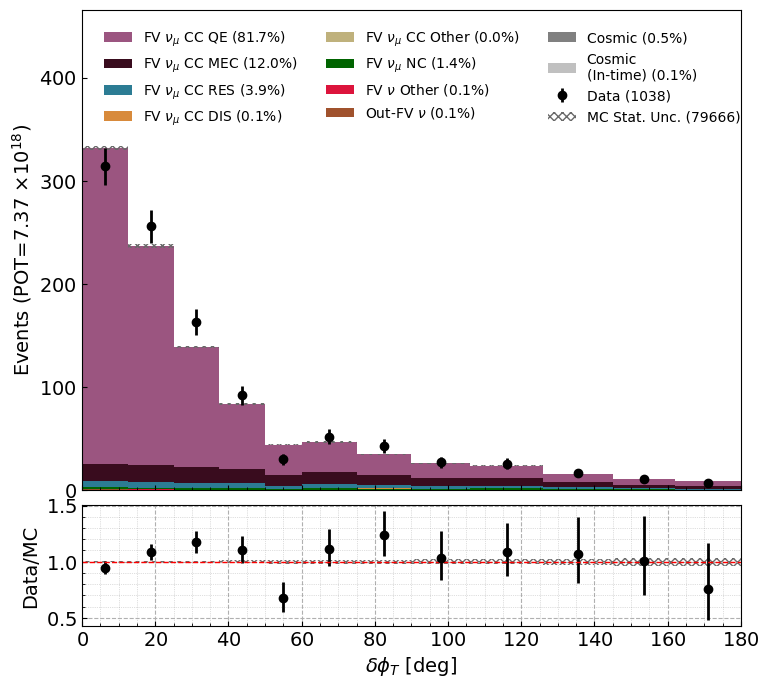

numu NC 1122


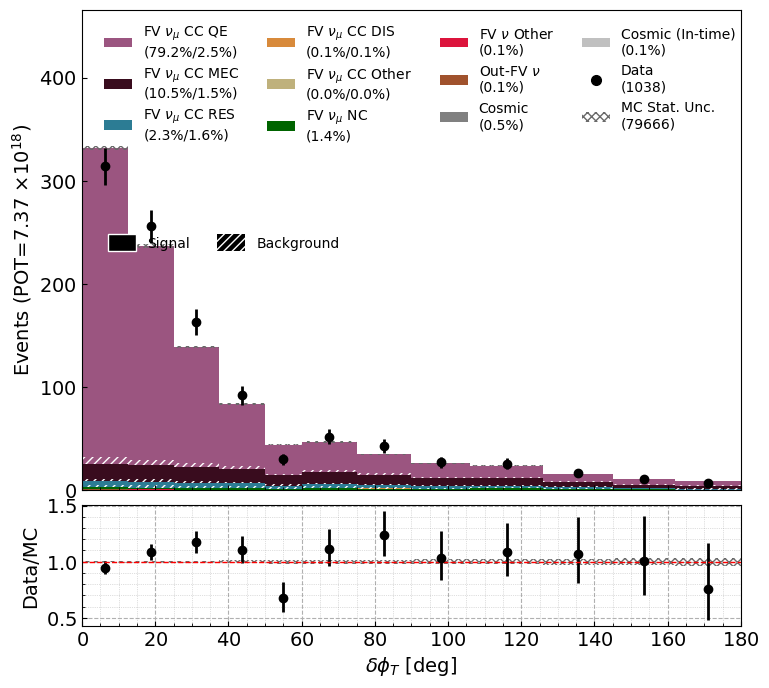

In [46]:
# Muon z-direction
evtdf = mc_evt_df_mup
tki_name = "del_phi"
var_config = VariableConfig.tki_del_phi()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta \phi_T$ [deg]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie_signal_bkgd"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot_genie_sb(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

## Data vs. MC of other variables

/tmp/ipykernel_2439469/1718994079.py:136: RuntimeWarning: invalid value encountered in divide
  mc_stat_err_ratio = mc_stat_err / total_mc
/tmp/ipykernel_2439469/1718994079.py:137: RuntimeWarning: invalid value encountered in divide
  mc_content_ratio = total_mc / total_mc
/tmp/ipykernel_2439469/1718994079.py:155: RuntimeWarning: invalid value encountered in divide
  data_ratio = total_data / total_mc
/tmp/ipykernel_2439469/1718994079.py:156: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eylow = data_eylow / total_mc
/tmp/ipykernel_2439469/1718994079.py:157: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eyhigh = data_eyhigh / total_mc
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/matplotlib/axes/_base.py:2982: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin


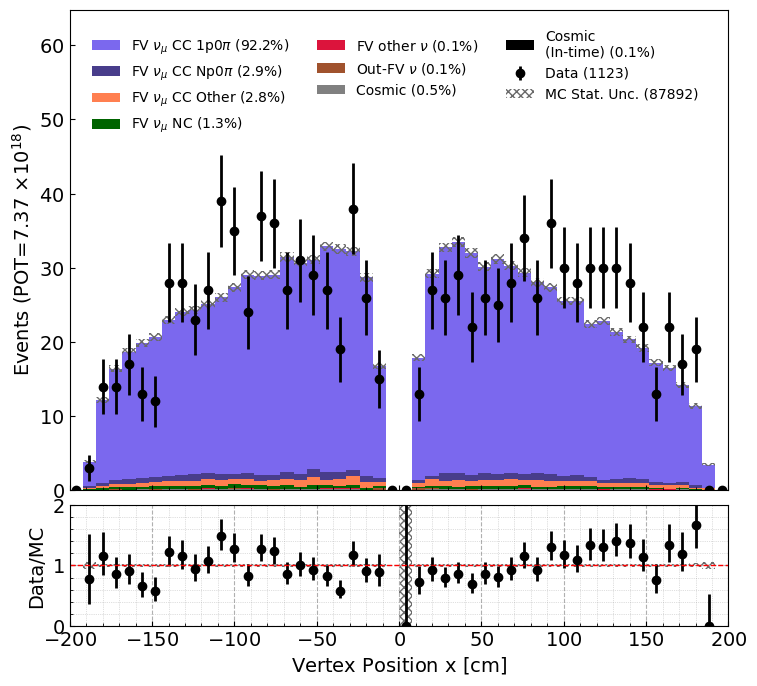

numu NC 1174


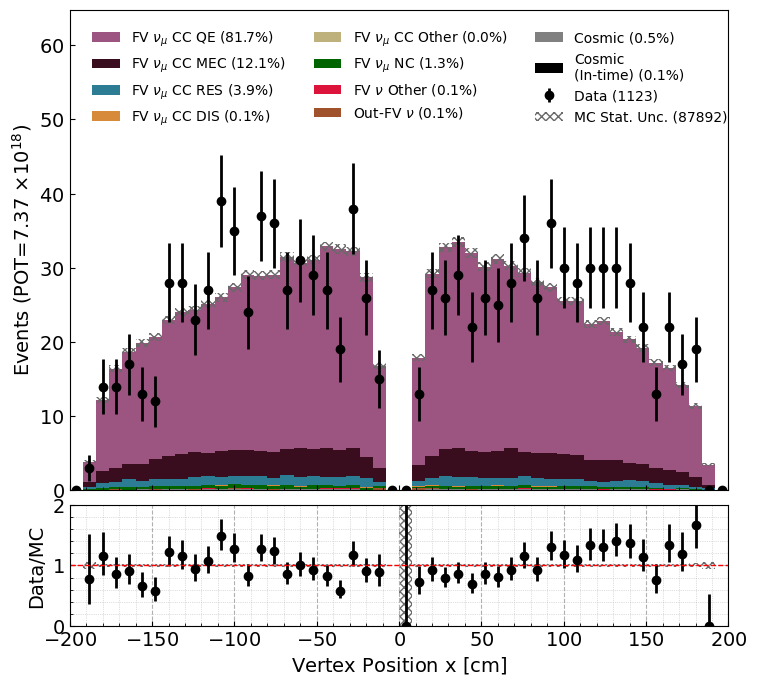

/tmp/ipykernel_2439469/1718994079.py:136: RuntimeWarning: invalid value encountered in divide
  mc_stat_err_ratio = mc_stat_err / total_mc
/tmp/ipykernel_2439469/1718994079.py:137: RuntimeWarning: invalid value encountered in divide
  mc_content_ratio = total_mc / total_mc
/tmp/ipykernel_2439469/1718994079.py:155: RuntimeWarning: invalid value encountered in divide
  data_ratio = total_data / total_mc
/tmp/ipykernel_2439469/1718994079.py:156: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eylow = data_eylow / total_mc
/tmp/ipykernel_2439469/1718994079.py:157: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eyhigh = data_eyhigh / total_mc
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/matplotlib/axes/_base.py:2982: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin


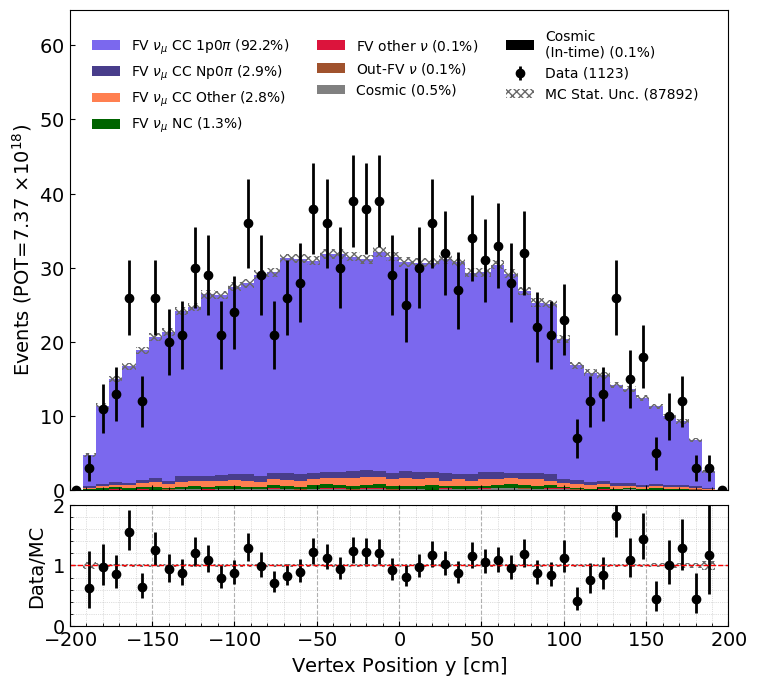

numu NC 1174


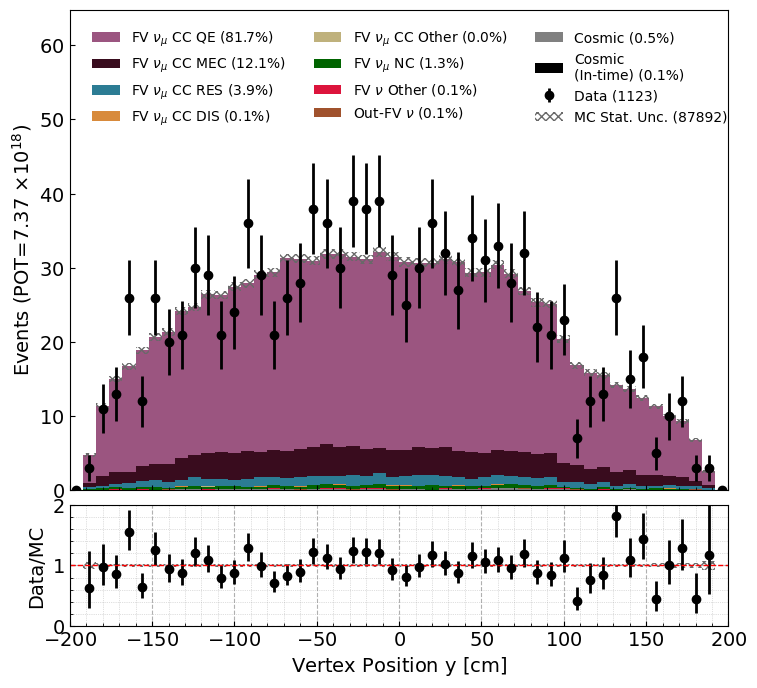

/tmp/ipykernel_2439469/1718994079.py:136: RuntimeWarning: invalid value encountered in divide
  mc_stat_err_ratio = mc_stat_err / total_mc
/tmp/ipykernel_2439469/1718994079.py:137: RuntimeWarning: invalid value encountered in divide
  mc_content_ratio = total_mc / total_mc
/tmp/ipykernel_2439469/1718994079.py:155: RuntimeWarning: invalid value encountered in divide
  data_ratio = total_data / total_mc
/tmp/ipykernel_2439469/1718994079.py:156: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eylow = data_eylow / total_mc
/tmp/ipykernel_2439469/1718994079.py:157: RuntimeWarning: divide by zero encountered in divide
  data_ratio_eyhigh = data_eyhigh / total_mc
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/matplotlib/axes/_base.py:2982: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin


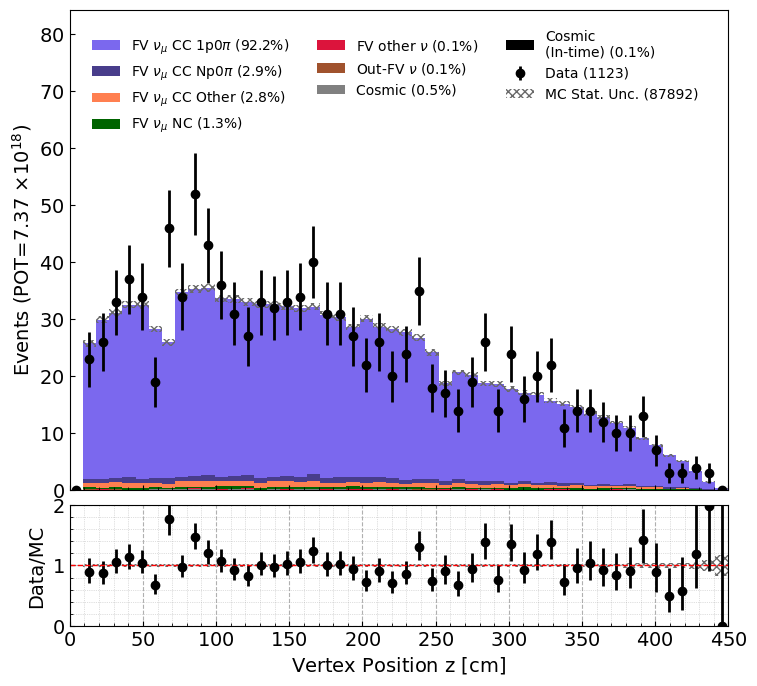

numu NC 1174


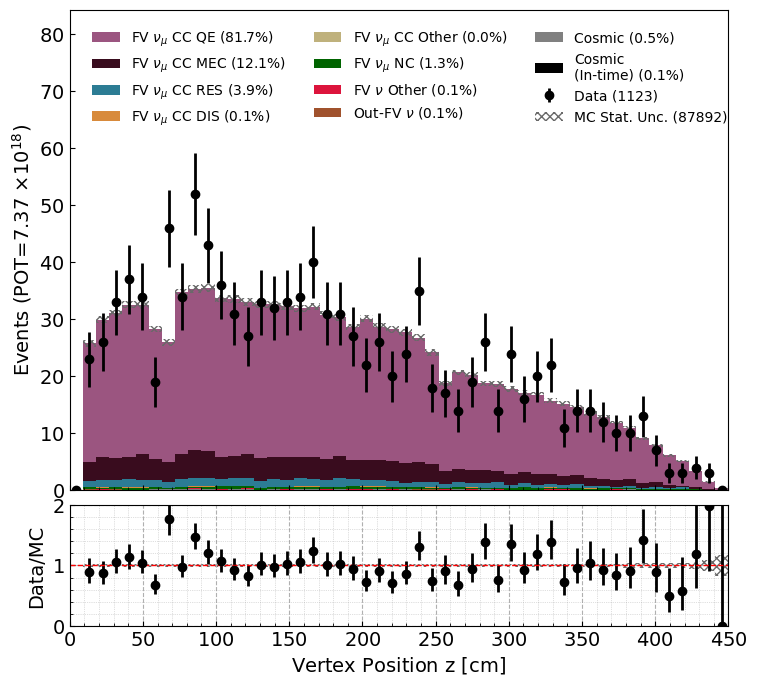

In [ ]:
# slice vertex position
evtdf = mc_evt_df_mup
vardf = evtdf.slc.vertex.x
vardf_data = data_evt_df_mup.slc.vertex.x
vardf_intime = intime_evt_df_mup.slc.vertex.x
bins = np.linspace(-200,200,51)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"Vertex Position $\mathrm{x}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/slice_vertex_x_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/slice_vertex_x_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df_mup
vardf = evtdf.slc.vertex.y
vardf_data = data_evt_df_mup.slc.vertex.y
vardf_intime = intime_evt_df_mup.slc.vertex.y
bins = np.linspace(-200,200,51)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"Vertex Position $\mathrm{y}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/slice_vertex_y_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/slice_vertex_y_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


evtdf = mc_evt_df_mup
vardf = evtdf.slc.vertex.z
vardf_data = data_evt_df_mup.slc.vertex.z
vardf_intime = intime_evt_df_mup.slc.vertex.z
bins = np.linspace(0,450,51)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"Vertex Position $\mathrm{z}$ [cm]", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/slice_vertex_z_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/slice_vertex_z_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

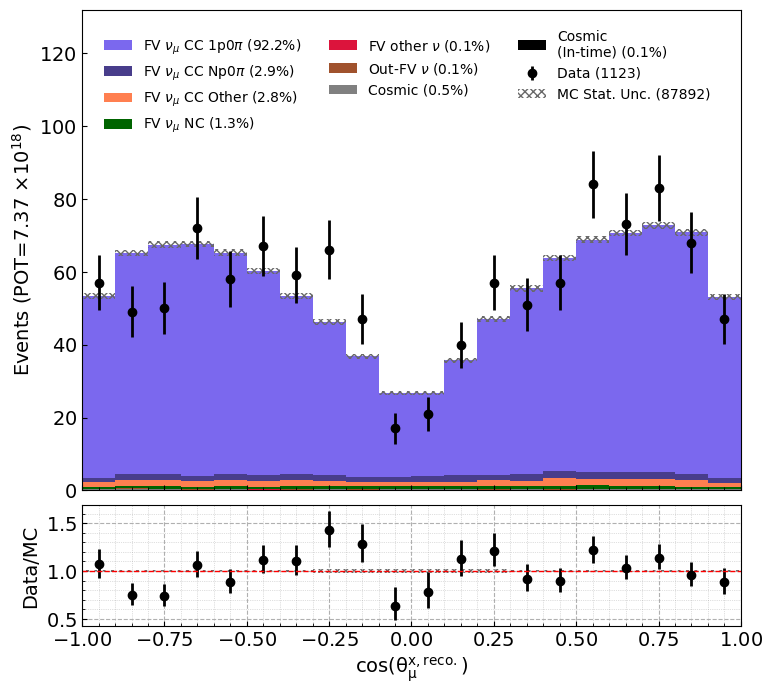

numu NC 1174


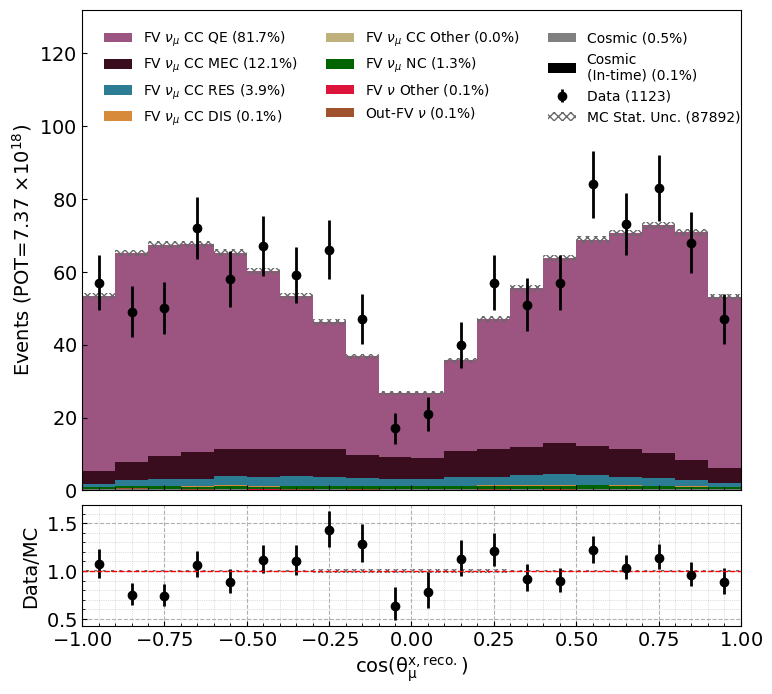

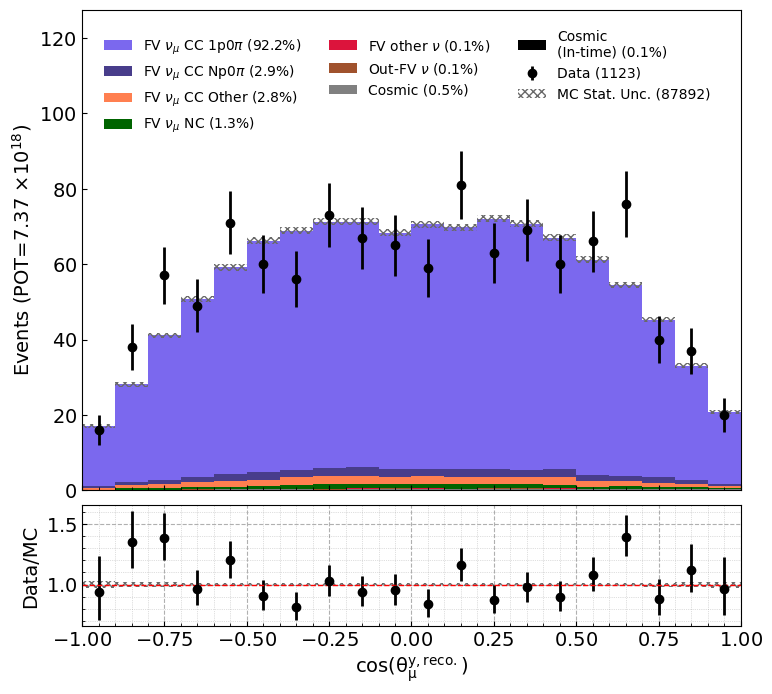

numu NC 1174


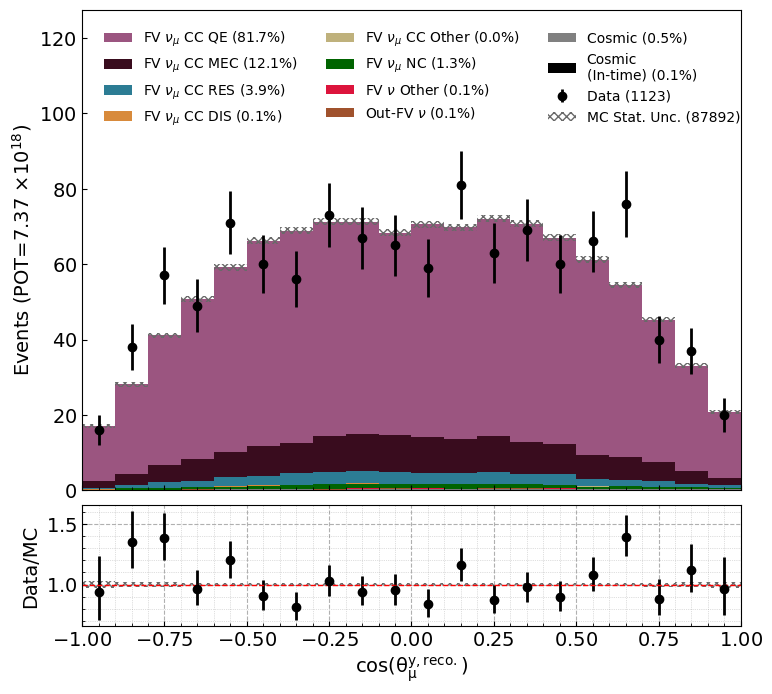

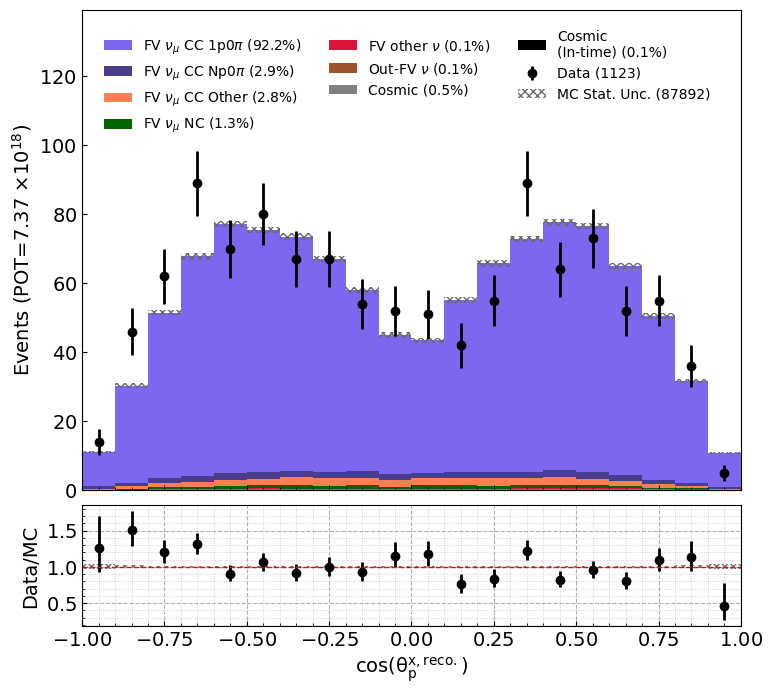

numu NC 1174


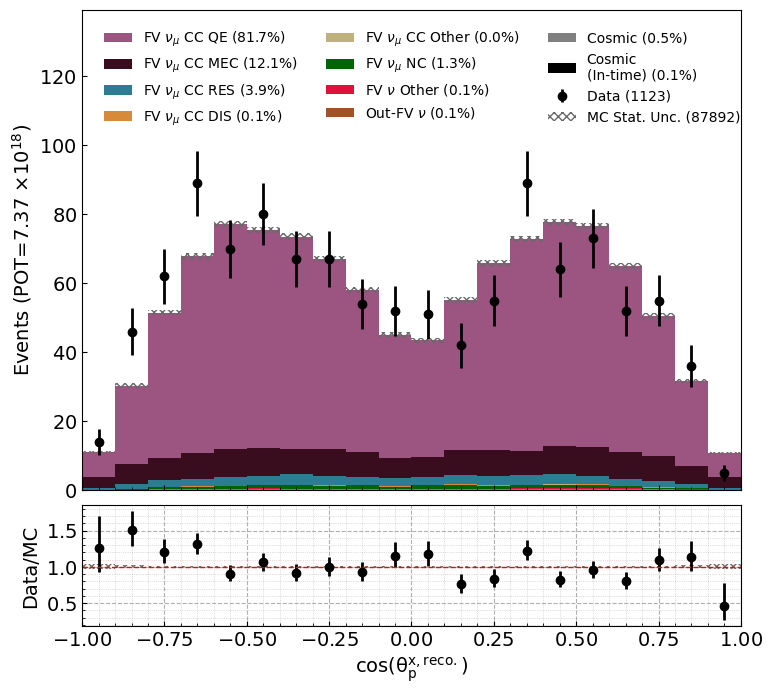

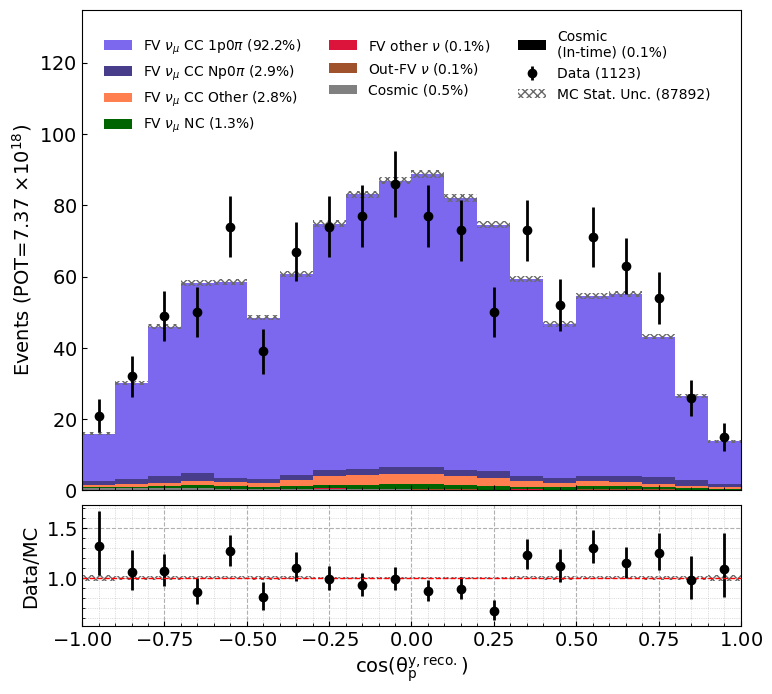

numu NC 1174


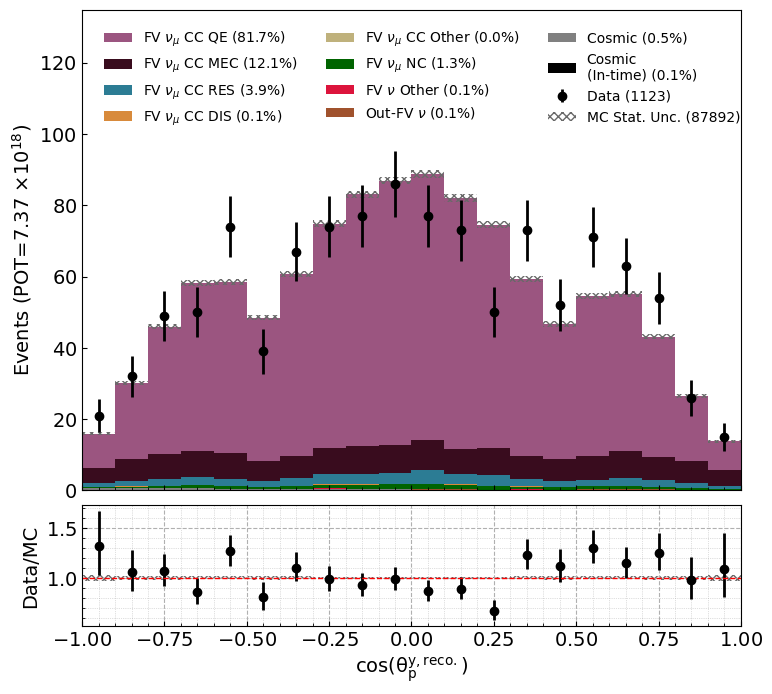

In [ ]:
# mu & p directions

evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.dir.x
vardf_data = data_mu_df.pfp.trk.dir.x
vardf_intime = intime_mu_df.pfp.trk.dir.x
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu}^{x, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/mu_dir_x-{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/mu_dir_x_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df_mup
vardf = mc_mu_df.pfp.trk.dir.y
vardf_data = data_mu_df.pfp.trk.dir.y
vardf_intime = intime_mu_df.pfp.trk.dir.y
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu}^{y, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/mu_dir_y_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/mu_dir_y_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

# proton

evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.dir.x
vardf_data = data_p_df.pfp.trk.dir.x
vardf_intime = intime_p_df.pfp.trk.dir.x
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_p^{x, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/p_dir_x_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/p_dir_x_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df_mup
vardf = mc_p_df.pfp.trk.dir.y
vardf_data = data_p_df.pfp.trk.dir.y
vardf_intime = intime_p_df.pfp.trk.dir.y
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_p^{y, reco.})}$",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/p_dir_y_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/p_dir_y_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

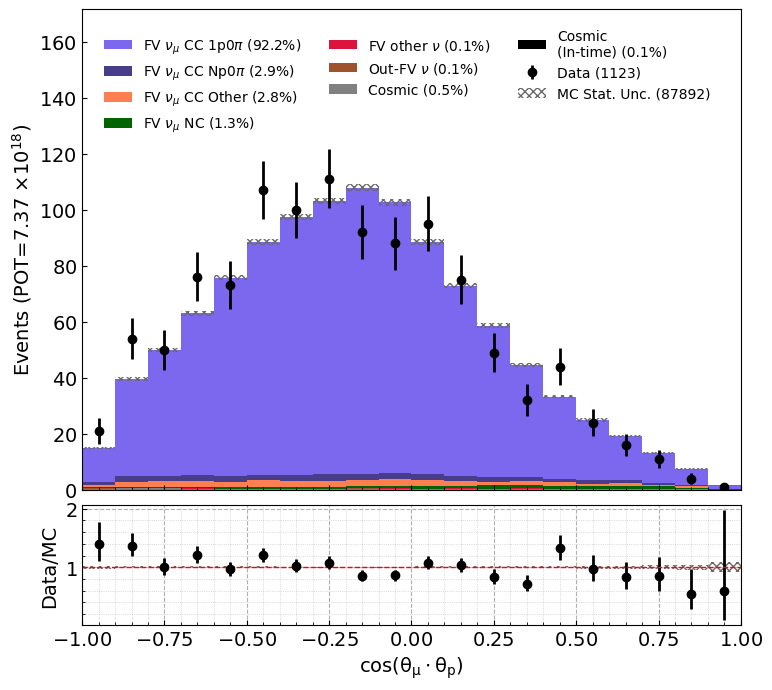

numu NC 1174


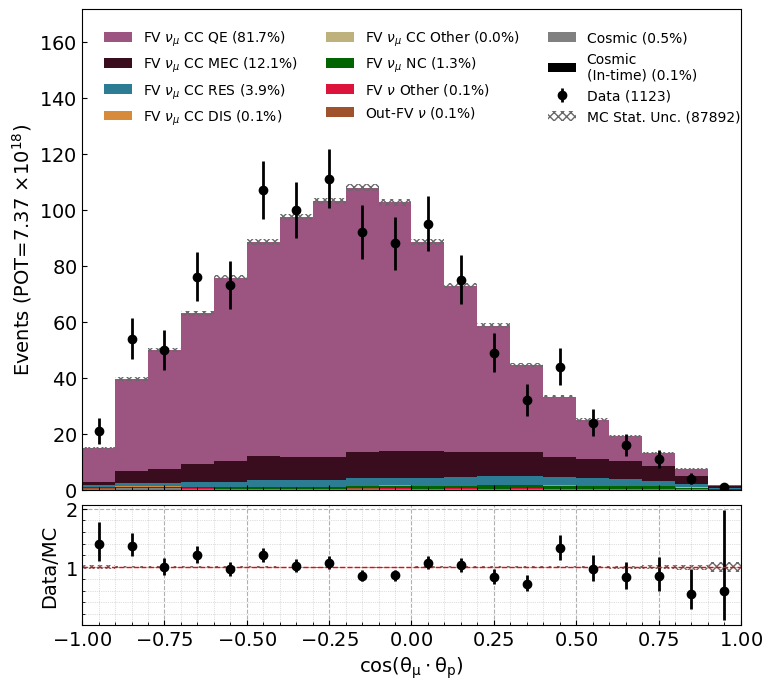

In [ ]:
# opening angle
evtdf = mc_evt_df_mup
mcdf = mc_mu_df.reset_index(level=[3])
pudf = mc_p_df.reset_index(level=[3])
vardf = mcdf.pfp.trk.dir.x * pudf.pfp.trk.dir.x + mcdf.pfp.trk.dir.y * pudf.pfp.trk.dir.y + mcdf.pfp.trk.dir.z * pudf.pfp.trk.dir.z
data_mudf = data_mu_df.reset_index(level=[3])
data_pdf = data_p_df.reset_index(level=[3])
vardf_data = data_mudf.pfp.trk.dir.x * data_pdf.pfp.trk.dir.x + data_mudf.pfp.trk.dir.y * data_pdf.pfp.trk.dir.y + data_mudf.pfp.trk.dir.z * data_pdf.pfp.trk.dir.z
intime_mcdf = intime_mu_df.reset_index(level=[3])
intime_pudf = intime_p_df.reset_index(level=[3])
vardf_intime = intime_mcdf.pfp.trk.dir.x * intime_pudf.pfp.trk.dir.x + intime_mcdf.pfp.trk.dir.y * intime_pudf.pfp.trk.dir.y + intime_mcdf.pfp.trk.dir.z * intime_pudf.pfp.trk.dir.z
bins = np.linspace(-1,1,21)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\mathrm{cos(\theta_{\mu} \cdot \theta_p)}$", 
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/mu_p_opening_angle_{}.png".format(plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/mu_p_opening_angle_{}.png".format(plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

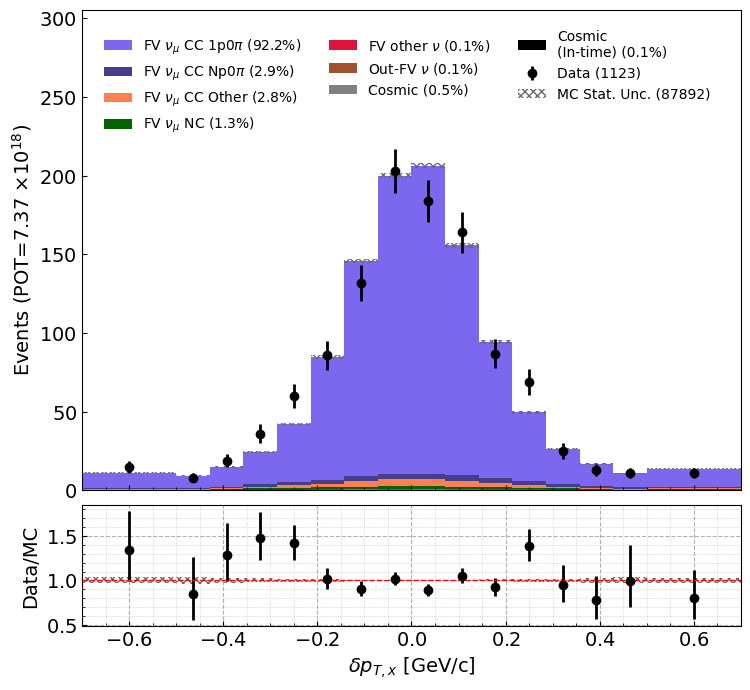

numu NC 1174


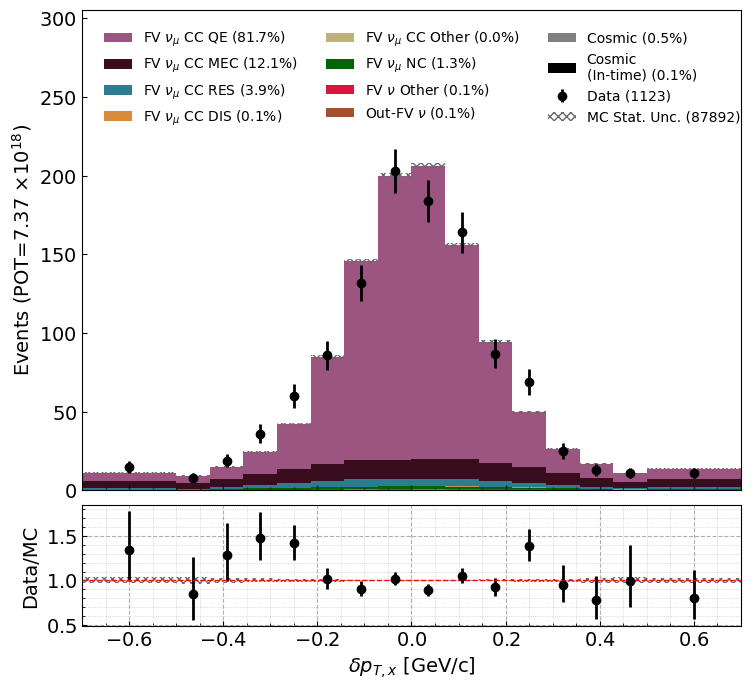

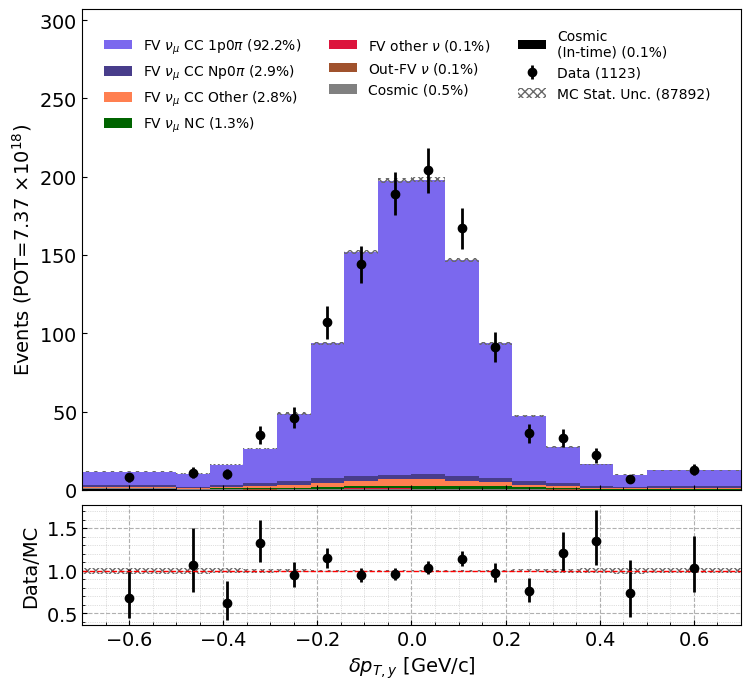

numu NC 1174


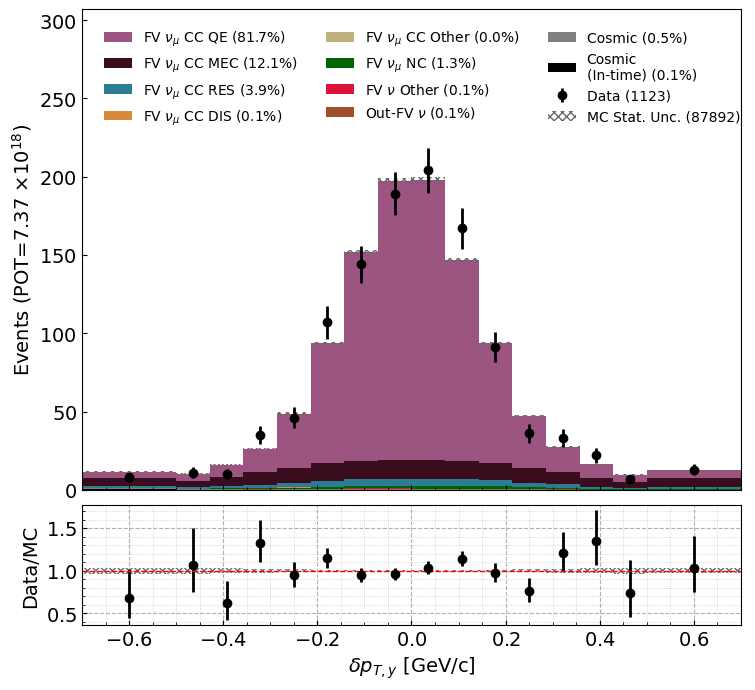

In [ ]:
# delta p_x, delta p_y
evtdf = mc_evt_df_mup
tki_name = "del_Tp_x"
var_config = VariableConfig.tki_del_Tp_x()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
bins = var_config.bins
bins = [-0.7] + list(np.linspace(-0.5,0.5,15)) + [0.7]
bins = np.array(bins)
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_{T,x}$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

evtdf = mc_evt_df_mup
tki_name = "del_Tp_y"
var_config = VariableConfig.tki_del_Tp_y()
vardf = mc_ret_tki[tki_name]
vardf_data = data_ret_tki[tki_name]
vardf_intime = intime_ret_tki[tki_name]
# bins = var_config.bins
vardf = np.clip(vardf, bins[0], bins[-1] - eps)
vardf_data = np.clip(vardf_data, bins[0], bins[-1] - eps)
vardf_intime = np.clip(vardf_intime, bins[0], bins[-1] - eps)
plot_labels = [r"$\delta p_{T,y}$ [GeV/c]",
               "Events (POT={})".format(pot_str), ""]

plot_type = "topology"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_topo = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)

plot_type = "genie"
save_name = save_fig_dir + "/tki-{}_{}.png".format(tki_name, plot_type)
ret_hist_genie = hist_plot(plot_type,
                          evtdf, vardf, 
                          vardf_data, vardf_intime,
                          bins, 
                          plot_labels,
                          save_fig=save_fig, save_name=save_name)


In [ ]:
# Q2
# evtdf = mc_evt_df_mup

In [ ]:
# W

In [ ]:
# E_cal

## Kinematic Reconstruction

### Vertex Position

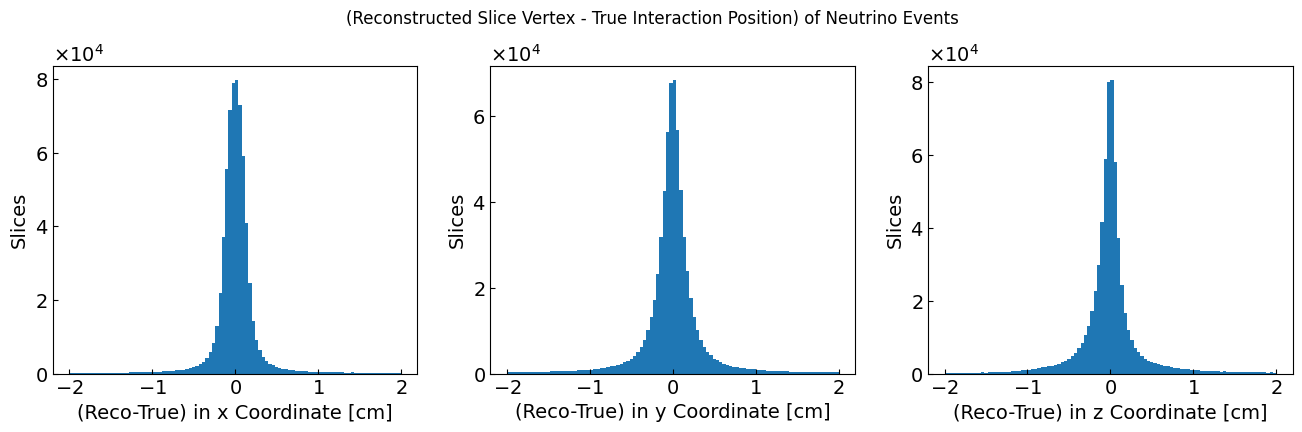

In [ ]:
# vertex reconstruction performance for neutrino slices
fig, axs = plt.subplots(1,3, figsize=(16,4))
for i, axis in enumerate(["x", "y", "z"]):
    var = mc_evt_df[IsNu(mc_evt_df)].slc.vertex[axis] - mc_evt_df[IsNu(mc_evt_df)].slc.truth.position[axis]
    bins = np.linspace(-2, 2, 101)
    # bins = 100
    axs[i].hist(var, bins=bins)
    axs[i].set_xlabel("(Reco-True) in {} Coordinate [cm]".format(axis))
    axs[i].set_ylabel("Slices")

plt.suptitle("(Reconstructed Slice Vertex - True Interaction Position) of Neutrino Events", y=1.02)
save_name = save_fig_dir + "/vertex_reco_res_3d.png"
if save_fig:
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
plt.show()

### Momentum

In [ ]:
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox

In [ ]:
mc_mu_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_mu_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
mc_p_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_p_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
mc_mu_df[("pfp", "trk", "truth", "p", "dir", "z")] = mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")] / mc_mu_df[("pfp", "trk", "truth", "p", "totp")]
mc_p_df[("pfp", "trk", "truth", "p", "dir", "z")] = mc_p_df[("pfp", "trk", "truth", "p", "genp", "z")] / mc_p_df[("pfp", "trk", "truth", "p", "totp")]

/tmp/ipykernel_2439469/1301984053.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_mu_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_mu_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
/tmp/ipykernel_2439469/1301984053.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_p_df[("pfp", "trk", "truth", "p", "totp", "")] = np.sqrt(mc_p_df[("pfp", "trk", "truth", "p", "genp", "x")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "y")]**2 + mc_p_df[("pfp", "trk", "truth", "p", "genp", "z")]**2)
/tmp/ipykernel_2439469/1301984053.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  mc_mu_df[("pfp", "trk", "truth", "p", "dir", "z")] = mc_mu_df[("pfp", "trk", "truth", "p", "genp", "z")] / mc_mu_df[("pfp", "trk", "truth", "p", "totp")]
/tmp/ipykernel_2439469/1301984053.py:4: Perfor

In [ ]:
mc_mu_df.pfp.trk.truth.p

start_process  \
                                                                      
                                                                      
__ntuple entry rec.slc..index (pfp, tindex, , , , , )                 
21       6597  1              0                                   0   
321      4632  0              0                                   0   
109      17098 1              0                                   0   
387      2116  0              0                                   0   
235      15079 0              0                                   0   
...                                                             ...   
229      15032 0              0                                   0   
268      5269  1              0                                   0   
7        4686  0              0                                   0   
273      1348  2              0                                   0   
252      3577  0              0                                   0   

                                                      end_process  pdg  \
                                                                         
                                                                         
__ntuple entry rec.slc..index (pfp, tindex, , , , , )                    
21       6597  1              0                                41   13   
321      4632  0              0                                41   13   
109      17098 1              0                                41   13   
387      2116  0              0                                41   13   
235      15079 0              0                                41   13   
...                                                           ...  ...   
229      15032 0              0                                41   13   
268      5269  1              0                                45 -211   
7        4686  0              0                                41   13   
273      1348  2              0                                41   13   
252      3577  0              0                                41   13   

                                                         startE       start  \
                                                                          x   
                                                                              
__ntuple entry rec.slc..index (pfp, tindex, , , , , )                         
21       6597  1              0                        0.966251   85.915092   
321      4632  0              0                        1.038099  -82.252304   
109      17098 1              0                        0.963152  133.328674   
387      2116  0              0                        0.970958  -13.049406   
235      15079 0              0                        0.983693   98.603752   
...                                                         ...         ...   
229      15032 0              0                        0.240690 -148.371918   
268      5269  1              0                        0.291720   34.197502   
7        4686  0              0                        0.250385  121.957039   
273      1348  2              0                        0.246573  107.838997   
252      3577  0              0                        0.245668  -50.068359   

                                                                               \
                                                                y           z   
                                                                                
__ntuple entry rec.slc..index (pfp, tindex, , , , , )                           
21       6597  1              0                       -111.882736   32.049911   
321      4632  0              0                        -42.302498  109.820915   
109      17098 1              0                        -86.300209  110.207977   
387      2116  0              0                        -44.390472   16.630436   
235      15079 0              0            

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of 

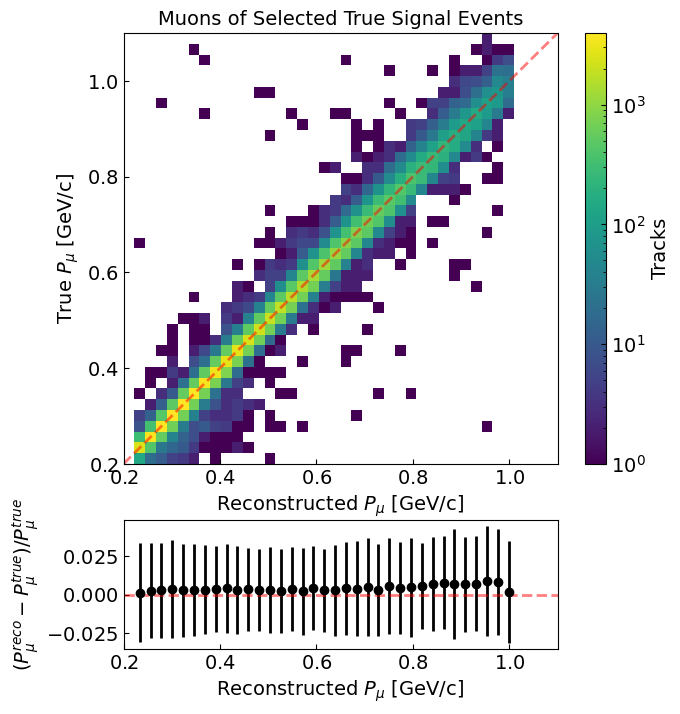

In [ ]:
var_reco = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.rangeP.p_muon
var_true = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.totp
plot_labels = ["Reconstructed $P_{\\mu}$ [GeV/c]", "True $P_{\\mu}$ [GeV/c]", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{\\mu}^{reco} - P_{\\mu}^{true}) / P_{\\mu}^{true}$"]
bins = np.linspace(0.2, 1.1, 41)
bins_frac = np.linspace(-0.1, 0.1, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.2, 0.2)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-P_res-mu_rangeP_mu_candidate.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of 

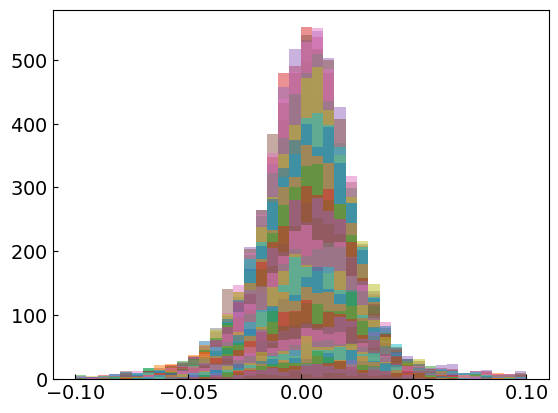

In [ ]:
var_reco = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.rangeP.p_muon
var_true = mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.totp
bins = np.linspace(0.2, 1.1, 41)
bins_frac = np.linspace(-0.1, 0.1, 41)

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -1, 1)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of 

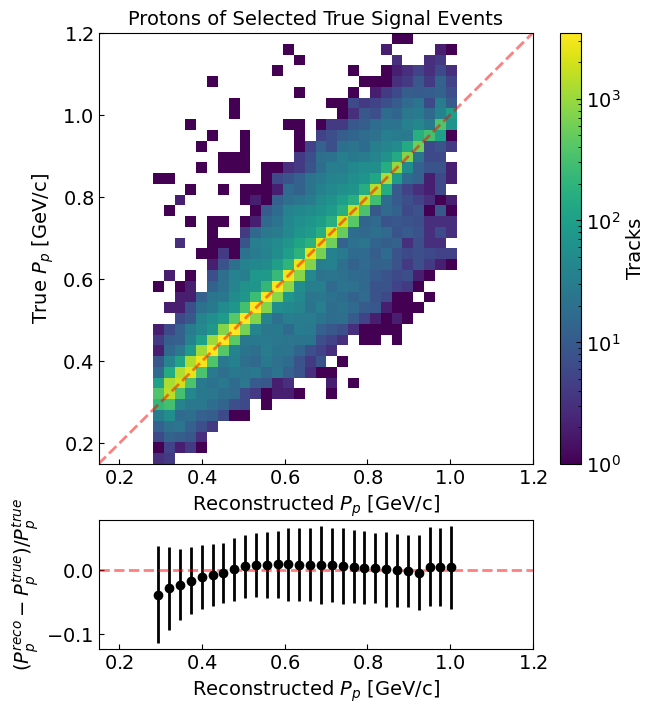

In [ ]:
var_reco = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.rangeP.p_proton
var_true = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.truth.p.totp
plot_labels = ["Reconstructed $P_{p}$ [GeV/c]", "True $P_{p}$ [GeV/c]", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{p}^{reco} - P_{p}^{true}) / P_{p}^{true}$"]
bins = np.linspace(0.15, 1.2, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.2, 0.2)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-P_res-p_rangeP.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of 

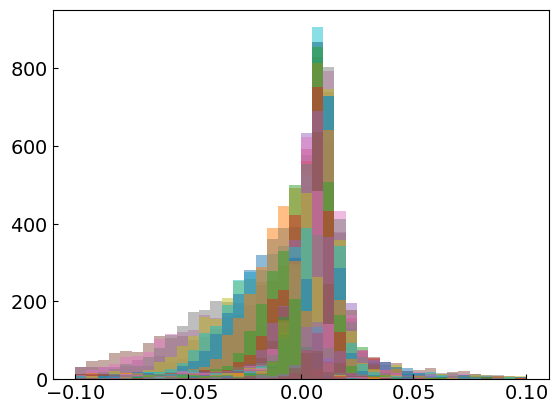

In [ ]:
var_reco = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.rangeP.p_proton
var_true = mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t2.pfp.trk.truth.p.totp
bins = np.linspace(0.2, 1.1, 41)
bins_frac = np.linspace(-0.1, 0.1, 41)

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -1, 1)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))

### Direction

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


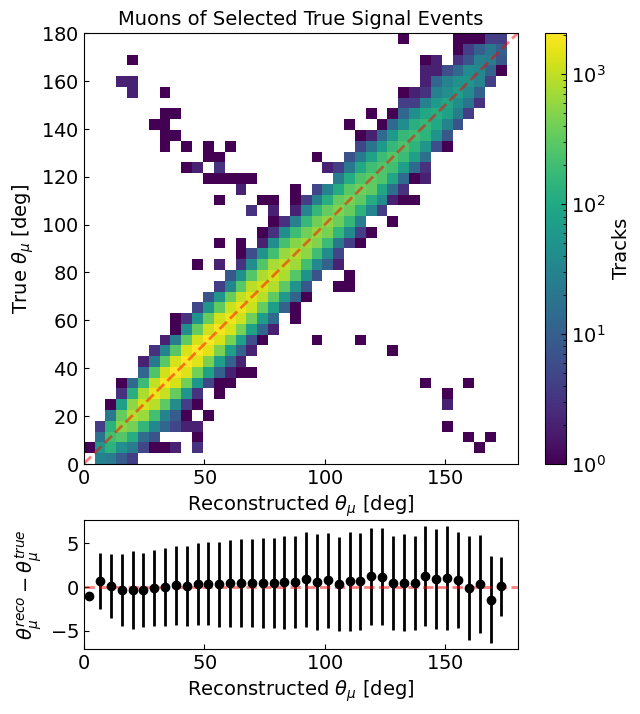

In [ ]:
var_reco = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.dir.z) * 180/np.pi
var_true = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.dir.z) * 180/np.pi
plot_labels = ["Reconstructed $\\theta_{\\mu}$ [deg]", "True $\\theta_{\\mu}$ [deg]", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$\\theta_{\\mu}^{reco} - \\theta_{\\mu}^{true}$"]
# bins = np.linspace(0, np.pi, 41)
bins = np.linspace(0, 180, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -20, 20)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-thetaz_res-mu.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


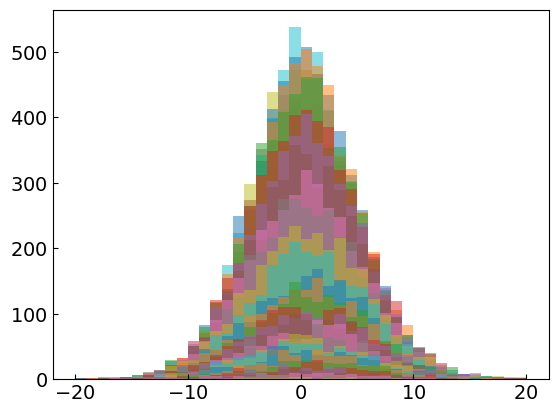

In [ ]:
var_reco = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.dir.z) * 180/np.pi
var_true = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13].t1.pfp.trk.truth.p.dir.z) * 180/np.pi
bins = np.linspace(0, 180, 41)
bins_frac = np.linspace(-20, 20, 41)

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -1, 1)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))

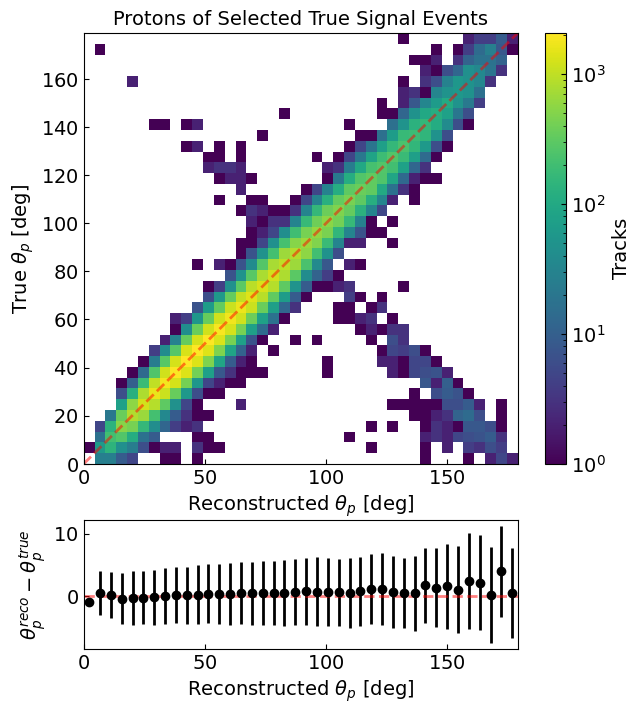

In [ ]:
var_reco = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t1.pfp.trk.dir.z) * 180/np.pi
var_true = np.arccos(mc_evt_df_mup[mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212].t1.pfp.trk.truth.p.dir.z) * 180/np.pi
plot_labels = ["Reconstructed $\\theta_{p}$ [deg]", "True $\\theta_{p}$ [deg]", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$\\theta_{p}^{reco} - \\theta_{p}^{true}$"]
bins = np.linspace(0, 179, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -15, 15)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-thetaz_res-p.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


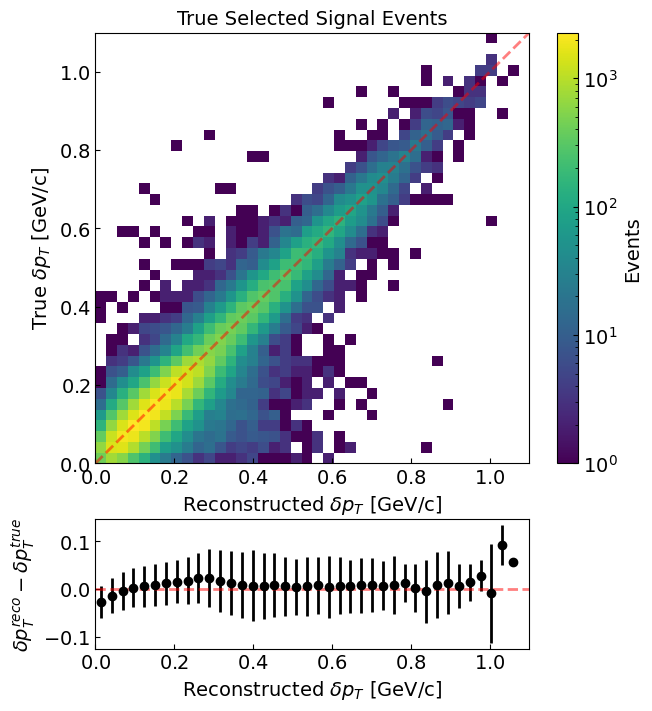

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_Tp
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_Tp
plot_labels = ["Reconstructed $\\delta p_T$ [GeV/c]", "True $\\delta p_T$ [GeV/c]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta p_T^{reco} - \\delta p_T^{true}$"]
bins = np.linspace(0, 1.1, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delTp_res.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

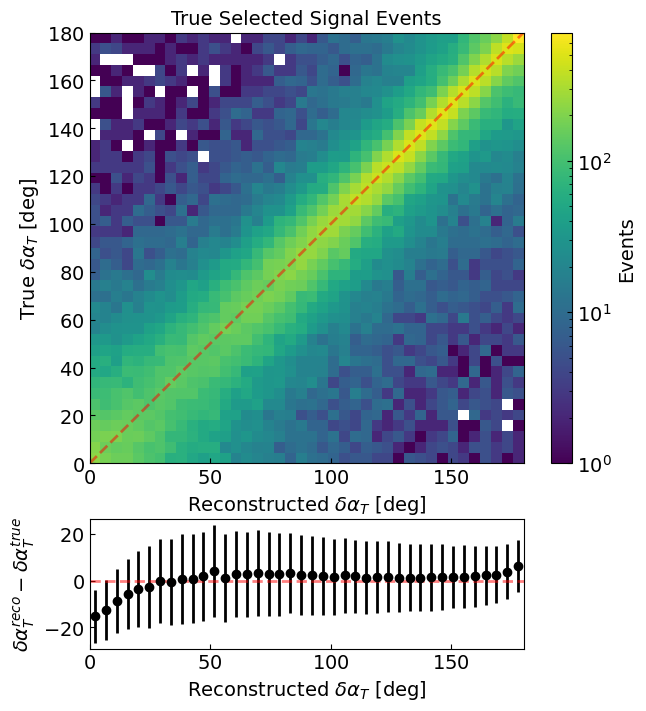

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_alpha 
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_alpha
plot_labels = ["Reconstructed $\\delta \\alpha_T$ [deg]", "True $\\delta \\alpha_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\alpha^{reco}_T - \\delta \\alpha^{true}_T$"]
bins = np.linspace(0, 180, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delalpha_res.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

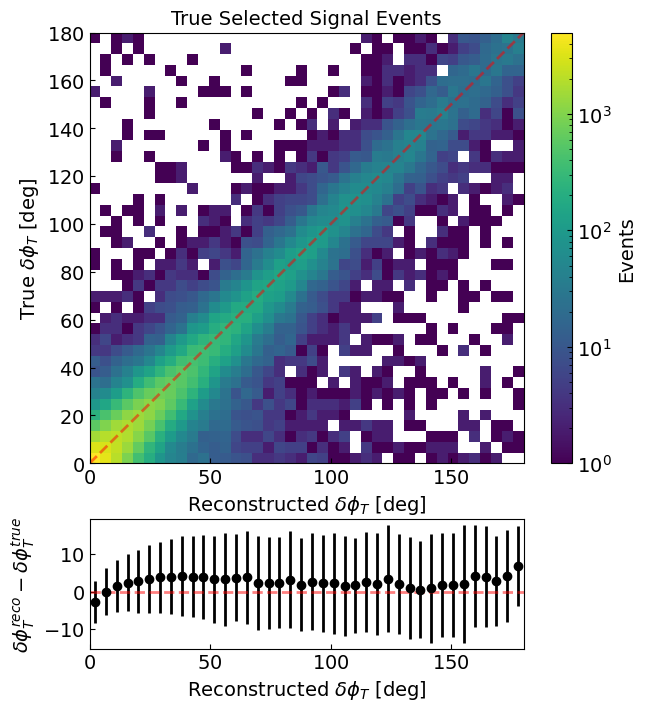

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi 
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi
plot_labels = ["Reconstructed $\\delta \\phi_T$ [deg]", "True $\\delta \\phi_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\phi^{reco}_T - \\delta \\phi^{true}_T$"]
bins = np.linspace(0, 180, 41)

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delalpha_res.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

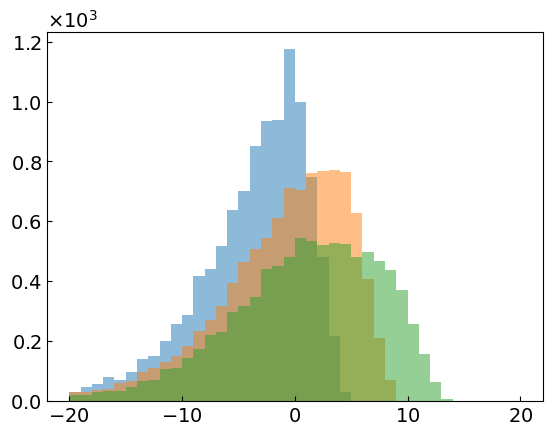

In [ ]:
var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi 
plot_labels = ["Reconstructed $\\delta \\phi_T$ [deg]", "True $\\delta \\phi_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\phi^{reco}_T - \\delta \\phi^{true}_T$"]
bins = np.linspace(0, 180, 41)
bins_frac = np.linspace(-20, 20, 41)

mean_list = []
sig_list = []
# for i in range(len(bins)-1):
for i in range(3):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)

    # this_diff = np.clip(this_diff, -1, 1)
    # mean_list.append(np.median(this_diff))
    # sig_list.append(np.std(this_diff))

### Resolution in Measurement Bins

In [ ]:
def percentage_in_diag(matrix):
    total = np.sum(matrix)
    diag = np.sum(np.diag(matrix))
    return diag/total

Fraction of events in the diagonal: 82.78


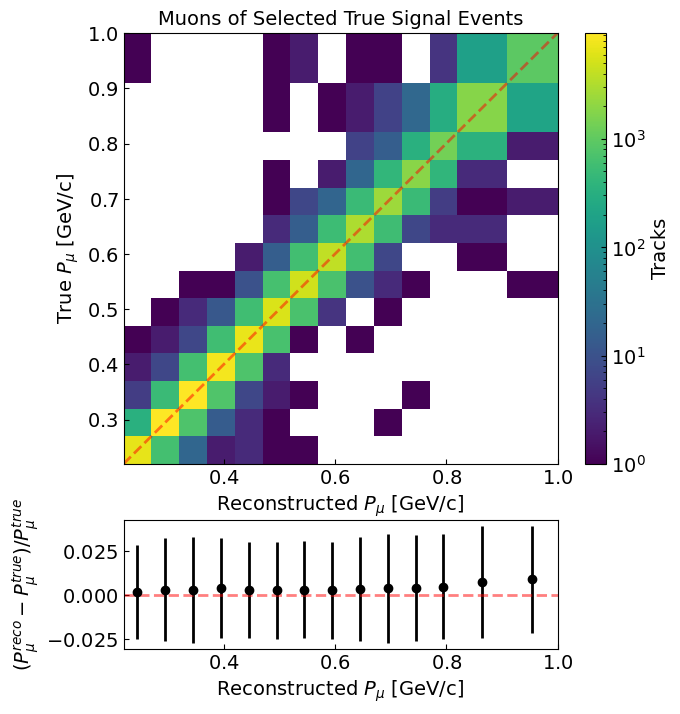

In [ ]:
var_config = VariableConfig.muon_momentum()
bins = var_config.bins
var_reco = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.rangeP.p_muon
var_true = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.truth.p.totp
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $P_{\\mu}$ [GeV/c]", "True $P_{\\mu}$ [GeV/c]", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{\\mu}^{reco} - P_{\\mu}^{true}) / P_{\\mu}^{true}$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-P_res-mu_rangeP_mu_candidate-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 77.40


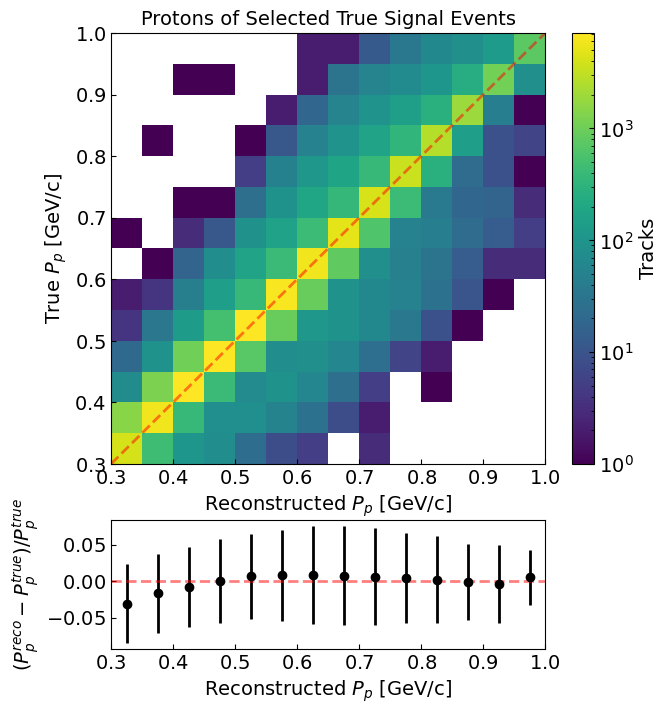

In [ ]:
var_config = VariableConfig.proton_momentum()
bins = var_config.bins

var_reco = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.rangeP.p_proton
var_true = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.truth.p.totp
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $P_{p}$ [GeV/c]", "True $P_{p}$ [GeV/c]", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$(P_{p}^{reco} - P_{p}^{true}) / P_{p}^{true}$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])
im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])/var_true[this_cut]
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-P_res-p_rangeP_p_candidate-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

### Direction

Fraction of events in the diagonal: 61.42


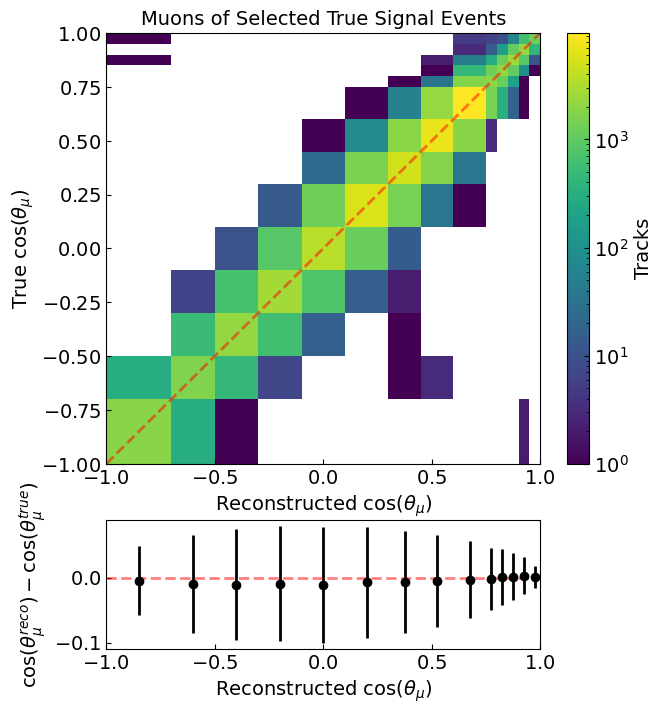

In [ ]:
var_config = VariableConfig.muon_direction()
bins = var_config.bins

var_reco = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.dir.z
var_true = mc_evt_df_mup[(mc_evt_df_mup.t1.pfp.trk.truth.p.pdg == 13) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t1.pfp.trk.truth.p.dir.z
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $\\cos (\\theta_{\\mu})$", "True $\\cos (\\theta_{\\mu})$", "Muons of Selected True Signal Events"]
plot_labels_frac = ["$\\cos (\\theta_{\\mu}^{reco}) - \\cos (\\theta_{\\mu}^{true})$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.2, 0.2)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-thetaz_res-mu-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 66.26


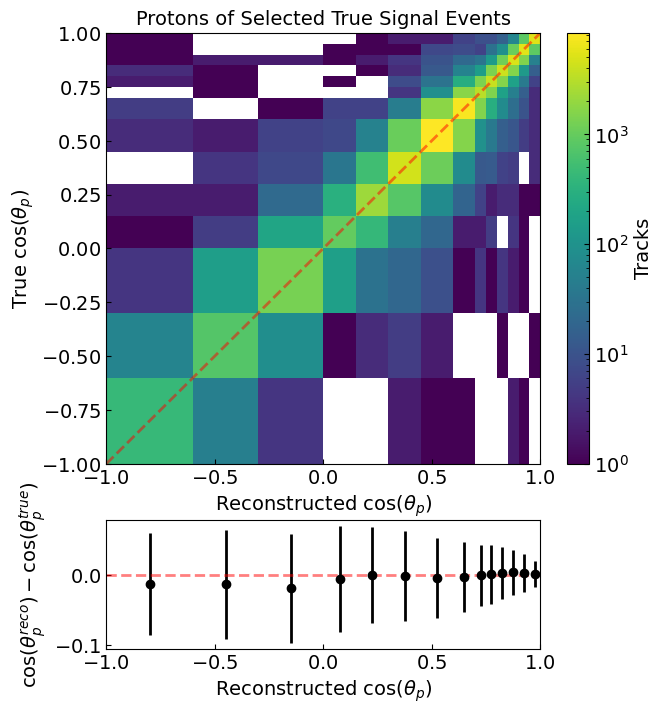

In [ ]:
var_config = VariableConfig.proton_direction()
bins = var_config.bins

var_reco = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.dir.z
var_true = mc_evt_df_mup[(mc_evt_df_mup.t2.pfp.trk.truth.p.pdg == 2212) & IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].t2.pfp.trk.truth.p.dir.z
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $\\cos (\\theta_{p})$", "True $\\cos (\\theta_{p})$", "Protons of Selected True Signal Events"]
plot_labels_frac = ["$\\cos (\\theta_{p}^{reco}) - \\cos (\\theta_{p}^{true})$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Tracks")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.2, 0.2)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-thetaz_res-p-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 44.17


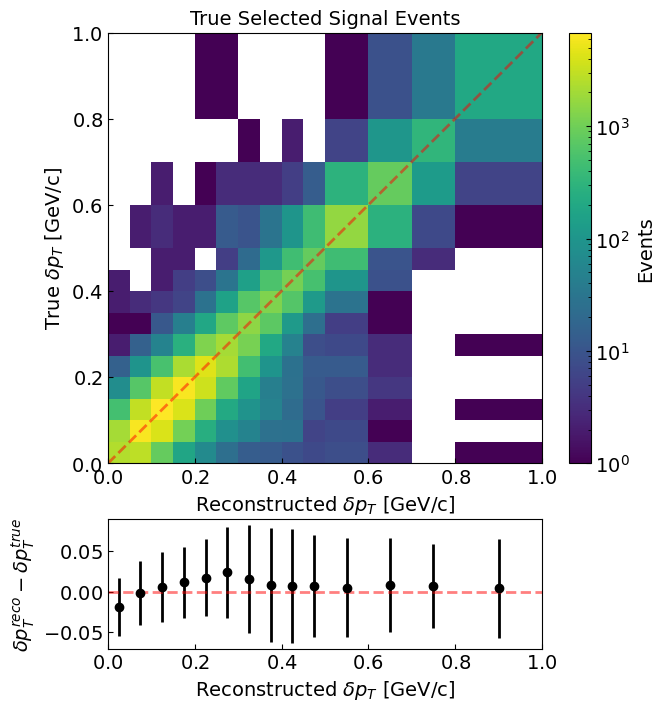

In [ ]:
var_config = VariableConfig.tki_del_Tp()
bins = var_config.bins

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_Tp
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_Tp
var_reco = np.clip(var_reco, var_config.bins[0], var_config.bins[-1] - eps)
var_true = np.clip(var_true, var_config.bins[0], var_config.bins[-1] - eps)
plot_labels = ["Reconstructed $\\delta p_T$ [GeV/c]", "True $\\delta p_T$ [GeV/c]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta p_T^{reco} - \\delta p_T^{true}$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -0.3, 0.3)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-delTp_res-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 35.50


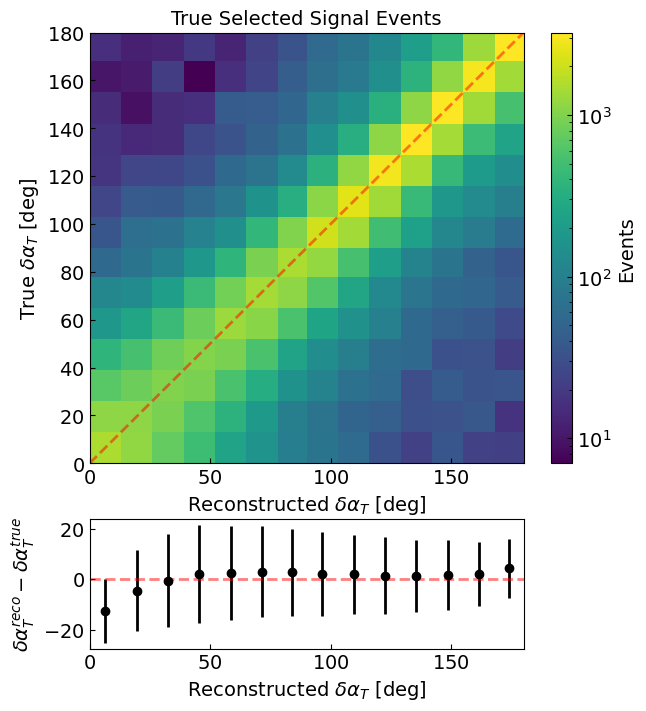

In [ ]:
var_config = VariableConfig.tki_del_alpha()
bins = var_config.bins

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_alpha
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_alpha
plot_labels = ["Reconstructed $\\delta \\alpha_T$ [deg]", "True $\\delta \\alpha_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\alpha^{reco}_T - \\delta \\alpha^{true}_T$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

save_name = save_fig_dir + "/kin_reco-delalpha_res-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

Fraction of events in the diagonal: 50.38


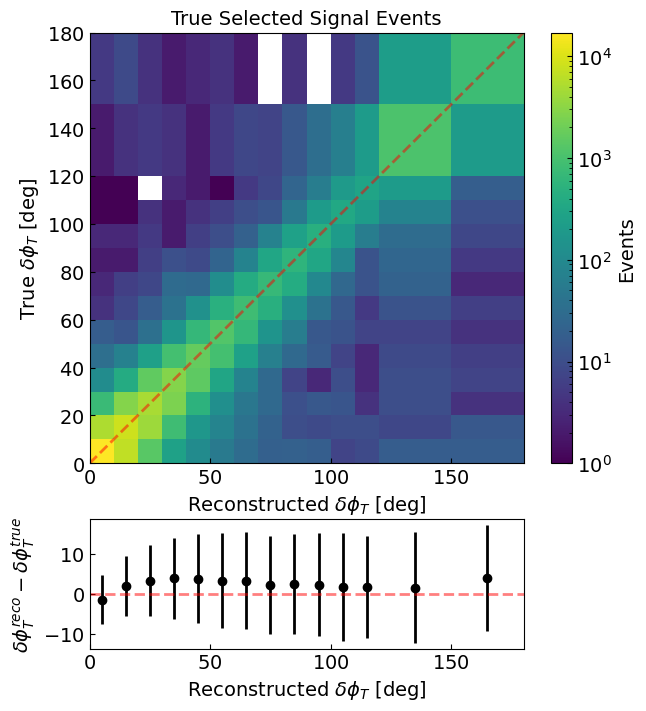

In [ ]:
var_config = VariableConfig.tki_del_phi()
bins = var_config.bins

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi
plot_labels = ["Reconstructed $\\delta \\phi_T$ [deg]", "True $\\delta \\phi_T$ [deg]", "True Selected Signal Events"]
plot_labels_frac = ["$\\delta \\phi^{reco}_T - \\delta \\phi^{true}_T$"]

fig, ax = plt.subplots(2,1, figsize=(7,8), height_ratios=[4,1.2])

im = ax[0].hist2d(var_reco, var_true, bins=bins, norm=mcolors.LogNorm(), cmap="viridis")
ax[0].set_xlabel(plot_labels[0])
ax[0].set_ylabel(plot_labels[1])
ax[0].plot(bins, bins, color="red", linestyle="--", alpha=0.5)
ax[0].set_title(plot_labels[2])
plt.colorbar(im[3], ax=ax[0], label="Events")

mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))
bin_centers = (bins[:-1] + bins[1:])/2
ax[1].errorbar(bin_centers, mean_list, yerr=sig_list, fmt="o", color="black")
# Match the size and position of the lower subplot to the upper subplot

diag_frac = percentage_in_diag(im[0]) * 1e2
print(f"Fraction of events in the diagonal: {diag_frac:.2f}")

# Set x-limits to match
ax[1].set_xlim(ax[0].get_xlim())

# Match subplot width and position
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()
ax[1].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
ax[1].axhline(0, color="red", linestyle="--", alpha=0.5)
ax[1].set_xlabel(plot_labels[0])
ax[1].set_ylabel(plot_labels_frac[0])

save_name = save_fig_dir + "/kin_reco-delphi_res-measurement_bins.pdf"
if save_fig:
    plt.savefig(save_name, bbox_inches="tight")
plt.show();

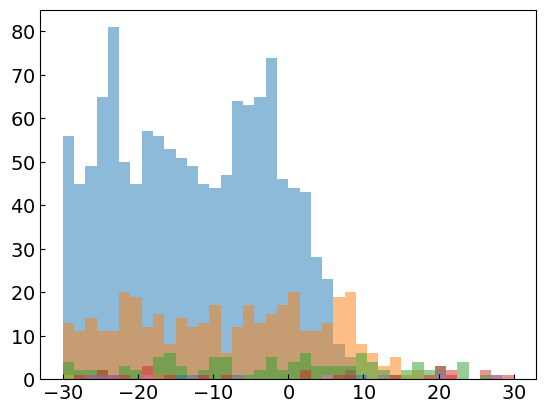

In [ ]:
var_config = VariableConfig.tki_del_phi()
bins = var_config.bins
bins_frac = np.linspace(-30, 30, 41)

var_reco = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].del_phi
var_true = mc_evt_df_mup[IsNuInFV_NumuCC_1p0pi(mc_evt_df_mup)].mc_del_phi * 180/np.pi
mean_list = []
sig_list = []
for i in range(len(bins)-1):
    this_cut = (var_reco > bins[i]) & (var_reco < bins[i+1])
    this_diff = (var_reco[this_cut] - var_true[this_cut])
    plt.hist(this_diff, bins=bins_frac, alpha=0.5)
    this_diff = this_diff[~np.isnan(this_diff) & ~np.isinf(this_diff)]
    this_diff = np.clip(this_diff, -30, 30)
    mean_list.append(np.median(this_diff))
    sig_list.append(np.std(this_diff))

# Save fully selected df

In [ ]:
from pyanalib.pandas_helpers import *

In [ ]:
save_df = False

In [ ]:
mc_evt_df_mup
mc_mu_df
len(data_evt_df_mup) * 20 * 10

In [ ]:
mc_mu_df.columns = pd.MultiIndex.from_tuples([tuple(["mu"] + list(c)) for c in mc_mu_df.columns])
mc_evt_df_mup = multicol_merge(mc_evt_df_mup, mc_mu_df, left_index=True, right_index=True, how="left", validate="one_to_one")

mc_p_df.columns = pd.MultiIndex.from_tuples([tuple(["p"] + list(c)) for c in mc_p_df.columns])
mc_evt_df_mup = multicol_merge(mc_evt_df_mup, mc_p_df, left_index=True, right_index=True, how="left", validate="one_to_one")

In [ ]:
mc_evt_df_mup.mu

In [ ]:
# if save_df:
#     mc_evt_df_mup.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/MC_bnb_cosmics-final.df", key="evt_0")
#     mc_hdr_df.to_hdf("/exp/sbnd/data/users/munjung/xsec/2025B/MC_bnb_cosmics-final.df", key="hdr_0")

# Get selected event metadata for hand scanning

## Get kinematics of some events

In [ ]:
topo_categ = get_int_category(mc_evt_df_mup)
topo_categ.value_counts()
# mc_evt_df_mup[topo_categ == 3][mult_colnames]

 1    81123
 2     2528
 3     2438
 4     1174
-1      423
 5      111
 0       95
Name: count, dtype: int64

In [ ]:
mult_colnames = ["nmu", "np", "npi", "npi0", "nmu_220MeVc", "np_300MeVc", "npi_70MeVc"]

In [ ]:
badkin_df = mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.nmu_220MeVc == 1) & (mc_evt_df_mup.np_300MeVc == 1) & (mc_evt_df_mup.npi_70MeVc == 0)]
# ((badkin_df.mu.totp < 0.220) | (badkin_df.mu.totp > 1)).sum()
# ((badkin_df.p.totp < 0.30) | (badkin_df.p.totp > 1)).sum()
(badkin_df.npi0 > 0).sum()

172

In [ ]:
mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.npi_70MeVc > 0)]
mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.npi0 > 1)].npi0

__ntuple  entry  rec.slc..index
298       5386   0                 2.0
Name: npi0, dtype: float64

In [ ]:
has_pic = mc_evt_df_mup[(topo_categ == 3) & (mc_evt_df_mup.npi_70MeVc > 0) & (mc_evt_df_mup.genie_mode == 2)]
# has_pi0 = mc_evt_df_mup[mc_evt_df_mup.npi0 > 1]
mc_hdr_df.loc[has_pic.reset_index(level=[2]).index]
# mc_evt_df_mup.loc[has_pic.index].genie_mode.value_counts()

pot  first_in_subrun  ismc   run  subrun  ngenevt  \
__ntuple entry                                                               
108      12223  0.000000e+00                0     1  2262      77      100   
375      6462   0.000000e+00                0     1  2361      28      100   
122      5884   0.000000e+00                0     1  3588      55      100   
130      15369  0.000000e+00                0     1  4408      46      100   
283      3351   0.000000e+00                0     1  2197      59      100   
227      15767  0.000000e+00                0     1  3160      62      100   
321      1445   0.000000e+00                0     1  2794      29      100   
177      3261   0.000000e+00                0     1   386      45      100   
77       8796   0.000000e+00                0     1  3112      82      100   
149      11283  0.000000e+00                0     1   107       6      100   
331      6499   0.000000e+00                0     1  4323      46      100   
199      2871   0.000000e+00                0     1  3587       2      100   
152      3102   1.477005e+15                1     1  3773       8      100   
264      13541  0.000000e+00                0     1  1075      47      100   
319      6318   0.000000e+00                0     1  3981      92      100   
355      16669  0.000000e+00                0     1  3938      51      100   
102      3472   0.000000e+00                0     1  3190      29      100   
115      3052   0.000000e+00                0     1  1066      44      100   
46       16525  0.000000e+00                0     1  3438      22      100   
350      11383  0.000000e+00                0     1  2166      85      100   
325      5196   0.000000e+00                0     1  1345      69      100   
143      7044   0.000000e+00                0     1  4281      37      100   
20       11180  0.000000e+00                0     1  2699      70      100   
117      11360  0.000000e+00                0     1  3998      67      100   
268      7119   0.000000e+00                0     1  3426      31      100   
54       13722  0.000000e+00                0     1  4027      93      100   
1        7900   0.000000e+00                0     1   282      96      100   
327      10989  0.000000e+00                0     1  3573      63      100   

                evt  proc   cluster  fno  noffbeambnb  
__ntuple entry                                         
108      12223   69     0  64543392    0          0.0  
375      6462    76     0  64609846    0          0.0  
122      5884    63     0  22479050    0          0.0  
130      15369   76     0  64547212    0          0.0  
283      3351     5     0  64588636    0          0.0  
227      15767   63     0  78914699    0          0.0  
321      1445    22     0  22483652    0          0.0  
177      3261    55     0  64564215    0          0.0  
77       8796    54     0  78879024    0          0.0  
149      11283   61     0  22594519    0          0.0  
331      6499    49     0  22495487    0          0.0  
199      2871    32     0  22487032    0          0.0  
152      3102     3     0  22529325    0          0.0  
264      13541   18     0  64535502    0          0.0  
319      6318    54     0  64561052    0          0.0  
355      16669   16     0  22504328    0          0.0  
102      3472    35     0  22541573    0          0.0  
115      3052    98     0  64531159    0          0.0  
46       16525   51     0  22485872    0          0.0  
350      11383   89     0  22505431    0          0.0  
325      5196    41     0  64627819    0          0.0  
143      7044    56     0  22623177    0          0.0  
20       11180    6     0  78856781    0          0.0  
117      11360   14     0  78912243    0          0.0  
268      7119     3     0  22511191    0          0.0  
54       13722   18     0  78926055    0          0.0  
1        7900    19     0  22480075    0          0.0  
327      10989   91     0  78933097    0          0.0

In [ ]:
meta = (3998, 67, 14)
this_evt = mc_hdr_df[(mc_hdr_df.run == meta[0]) & (mc_hdr_df.subrun == meta[1]) & (mc_hdr_df.evt == meta[2])]
this_evt

pot  first_in_subrun  ismc   run  subrun  ngenevt  evt  proc  \
__ntuple entry                                                                 
117      11360  0.0                0     1  3998      67      100   14     0   

                 cluster  fno  noffbeambnb  
__ntuple entry                              
117      11360  78912243    0          0.0

In [ ]:
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].mu.length)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].p.length)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].genie_mode)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].pdg)
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index].iscc)
# print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index][["nmu", "np", "npi", "npi0"]])
print(mc_evt_df.reset_index(level=[2]).loc[this_evt.index][mult_colnames])
mc_evt_df.reset_index(level=[2]).loc[this_evt.index] #.t1.pfp.trk.len

__ntuple  entry
117       11360    60.789013
Name: length, dtype: float32
__ntuple  entry
117       11360    4.617738
Name: length, dtype: float32
__ntuple  entry
117       11360    2.0
Name: genie_mode, dtype: float64
__ntuple  entry
117       11360    14.0
Name: pdg, dtype: float64
__ntuple  entry
117       11360    1.0
Name: iscc, dtype: float64
                nmu   np  npi npi0 nmu_220MeVc np_300MeVc npi_70MeVc
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
                                                                    
__ntuple entry                                                      
117      11360  1.0  1.0  1.

rec.slc..index             slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry                                                          
117      11360              1               0  100.055382  147.781525   

                                                                   ...  \
                           self    tmatch                producer  ...   
                         z            eff       pur  idx           ...   
                                                                   ...   
                                                                   ...   
                                                                   ...   
                                                                   ...   
                                                                   ...   
__ntuple entry                                                     ...   
117      11360  214.261841   92  0.833961  0.956946  0.0        0  ...   

                       p            ind mc_del_alpha  mc_del_phi mc_del_Tp  \
                     dir                                                     
                       y         z                                           
                                                                             
                                                                             
                                                                             
                                                                             
                                                                             
__ntuple entry                                                               
117      11360  0.202857  0.977887  0.0   177.400436  171.653152  0.253169   

                mc_del_p mc_del_Tp_x mc_del_Tp_y pot_weight  
                                                             
                                                             
                                                             
                                                             
                                                             
                                                             
                                                             
__ntuple entry                                               
117      11360  0.375676    0.085846     0.23817   0.012585  

[1 rows x 324 columns]

In [ ]:
colnames = ["run", "subrun", "evt"]

## MC

In [ ]:
topo_categ = get_int_category(mc_evt_df_mup)
topo_categ.value_counts()

# genie_categ = get_genie_category(mc_evt_df_mup)
# genie_categ.value_counts()

 1    81123
 2     2528
 3     2438
 4     1174
-1      423
 5      111
 0       95
Name: count, dtype: int64

In [ ]:
save_meta = False

In [ ]:
if save_meta:
    # signal
    signal_meta = mc_hdr_df.loc[topo_categ[topo_categ == 1].reset_index(level=[2]).index][colnames]
    signal_meta.to_csv("signal_meta.csv", index=False)

    # cosmic
    cosmic_meta = mc_hdr_df.loc[topo_categ[topo_categ == -1].reset_index(level=[2]).index][colnames]
    cosmic_meta.to_csv("cosmic_meta.csv", index=False)

    # nu out of FV
    nu_outfv_meta = mc_hdr_df.loc[topo_categ[topo_categ == 0].reset_index(level=[2]).index][colnames]
    nu_outfv_meta.to_csv("nu_outfv_meta.csv", index=False)

    # numu cc np0pi
    numucc_np0pi_meta = mc_hdr_df.loc[topo_categ[topo_categ == 2].reset_index(level=[2]).index][colnames]
    numucc_np0pi_meta.to_csv("numucc_np0pi_meta.csv", index=False)

    # numu cc other
    numucc_other_meta = mc_hdr_df.loc[topo_categ[topo_categ == 3].reset_index(level=[2]).index][colnames]
    numucc_other_meta.to_csv("numucc_other_meta.csv", index=False)

    # numu nc
    numucc_nc_meta = mc_hdr_df.loc[topo_categ[topo_categ == 4].reset_index(level=[2]).index][colnames]
    numucc_nc_meta.to_csv("numucc_nc_meta.csv", index=False)

    # nu other
    nu_other_meta = mc_hdr_df.loc[topo_categ[topo_categ == 5].reset_index(level=[2]).index][colnames]
    nu_other_meta.to_csv("nu_other_meta.csv", index=False)

## Data

In [ ]:
data_meta = data_hdr_df.loc[data_evt_df_mup.reset_index(level=[2]).index][colnames]
data_meta.to_csv("data_meta.csv", index=False)

# Event Breakdown

In [ ]:
# final state topology detailed breakdown
this_df = mc_evt_df_mup[IsNuInFV_NumuCC_Np0pi(mc_evt_df_mup)]
this_df = mc_evt_df_mup[IsNuInFV_NumuCC_Other(mc_evt_df_mup)]
print(len(this_df))
this_df[["nmu_220MeVc", "np_300MeVc", "npi_70MeVc", "npi0"]]
# get unique combinations of nmu_27MeV, np_50MeV, npi_30MeV, npi0 and count how many events have each combination
unique_combinations = this_df[["nmu_220MeVc", "np_300MeVc", "npi_70MeVc", "npi0"]].drop_duplicates()
unique_combinations_list = []
for i in unique_combinations.index:
    nmu_27MeV_val = unique_combinations.loc[i].nmu_220MeVc
    np_50MeV_val = unique_combinations.loc[i].np_300MeVc
    npi_30MeV_val = unique_combinations.loc[i].npi_70MeVc
    npi0_val = unique_combinations.loc[i].npi0
    unique_combinations_list.append((int(nmu_27MeV_val), int(np_50MeV_val), int(npi_30MeV_val), int(npi0_val)))
print(len(unique_combinations_list), "unique combinations")

# count how many events have each combination
perc_list = []
for uc in unique_combinations_list:
    n_this_type = len(this_df[(this_df.nmu_220MeVc == uc[0]) & (this_df.np_300MeVc == uc[1]) & (this_df.npi_70MeVc == uc[2]) & (this_df.npi0 == uc[3])])
    perc = n_this_type/len(mc_evt_df_mup)
    print(uc, perc*100, n_this_type)
    perc_list.append(perc)
print(perc_list)
print(sum(perc_list))

2438
26 unique combinations
(1, 1, 0, 0) 1.232194056341874 1083
(1, 1, 1, 0) 0.3652209529877577 321
(1, 0, 0, 0) 0.45396623128384833 399
(1, 2, 1, 0) 0.030719519410185227 27
(1, 1, 0, 1) 0.19455695626450642 171
(1, 0, 1, 0) 0.18545487643926636 163
(1, 1, 2, 0) 0.0022755199563100166 2
(1, 2, 0, 1) 0.019341919628635143 17
(0, 2, 0, 0) 0.020479679606790153 18
(0, 1, 1, 0) 0.026168479497565192 23
(1, 0, 0, 1) 0.0034132799344650257 3
(1, 0, 1, 1) 0.0022755199563100166 2
(0, 4, 1, 0) 0.0011377599781550083 1


/tmp/ipykernel_2439469/4290504341.py:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  unique_combinations_list.append((int(nmu_27MeV_val), int(np_50MeV_val), int(npi_30MeV_val), int(npi0_val)))


(0, 1, 0, 0) 0.19569471624266144 172
(1, 2, 2, 0) 0.0011377599781550083 1
(1, 1, 1, 1) 0.0022755199563100166 2
(0, 0, 1, 0) 0.018204159650480133 16
(1, 1, 0, 2) 0.0011377599781550083 1
(1, 0, 2, 0) 0.0034132799344650257 3
(0, 1, 0, 1) 0.004551039912620033 4
(1, 3, 1, 0) 0.0022755199563100166 2
(1, 3, 0, 1) 0.0011377599781550083 1
(0, 2, 2, 0) 0.0011377599781550083 1
(0, 2, 1, 0) 0.0034132799344650257 3
(0, 1, 2, 0) 0.0011377599781550083 1
(0, 0, 0, 0) 0.0011377599781550083 1
[0.01232194056341874, 0.003652209529877577, 0.004539662312838483, 0.0003071951941018523, 0.0019455695626450643, 0.0018545487643926637, 2.2755199563100167e-05, 0.00019341919628635144, 0.00020479679606790152, 0.0002616847949756519, 3.4132799344650256e-05, 2.2755199563100167e-05, 1.1377599781550084e-05, 0.0019569471624266144, 1.1377599781550084e-05, 2.2755199563100167e-05, 0.00018204159650480134, 1.1377599781550084e-05, 3.4132799344650256e-05, 4.5510399126200334e-05, 2.2755199563100167e-05, 1.1377599781550084e-05, 1.1